# Data Analysis and Predictions Using the Morningstar European Funds Dataset

### Project Brief

Cardinal Stone’s executive team is looking to launch a new investment product and wants to analyse the performance of existing products in the market. The task is to gather relevant data from various sources, clean and organize the data, and identify trends and patterns. We'll then create a visual report and dashboard that highlights key findings, such as risk-adjusted returns, market share, and customer satisfaction. This information will help the company make data-driven decisions to improve the product and its marketing strategies.

**Potential Analysis Questions to Explore**
- What are the top-performing investment products in the market, based on risk-adjusted returns, over the past 1, 3, and 5 years?
- How do the risk levels of different investment products correlate with their performance?
- Are there any seasonal or cyclical trends in the performance of investment products that can be leveraged for marketing strategies?
- Which investment products have the highest customer satisfaction ratings?
- Are there any correlations between customer satisfaction and the performance of the investment products?
- How do the fees (management and expense fees) of different investment products impact their overall performance and customer satisfaction rate?
- Other relevant questions... [risk-adjusted returns, market share, and customer satisfaction]

**ML Question**

There are a number of prediction options in this dataset:
- Predict funds' annual and quarterly returns. This is a regression problem.
- Predict a fund's rating. This is a multi-class classification problem.

### Frame the Problem

- This is a supervised learning task, with existing target labels.
- This is a combined regression and multi-class classification task.
- We'll be using a static dataset and performing batch offline learning.
- We'll be conducting hypothesis testing on portions of the data to derive responses to data analysis questions.

### Select a Performance Measure

We'll be using accuracy, confusion matrix, ROC curve and precision/recall metrics as for the classification performance measures and MSE, RMSE and R-squared for the regression performance.

For data analysis, we'll be using chi-square and f-tests for our hypothesis.

### Check Assumptions

### Create Workspace

In [1]:
# Analytics Libraries
import numpy as np
import pandas as pd
import datetime as dt
import re
from collections import Counter
from scipy import stats
import math
import bisect

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
import seaborn as sns

# ML Libraries
from sklearn.model_selection import train_test_split

# Evaluation Libraries


### Load the Data

In [2]:
mutual_funds = pd.read_csv('Morningstar - European Mutual Funds.csv')
etfs = pd.read_csv('Morningstar - European ETFs.csv')

### Preview Data Structures

In [3]:
mutual_funds.head()

ticker          isin  \
0  0P00000BOW  LU0011983433   
1  0P00000ESH  LU0757425763   
2  0P00000ESL  LU0011818076   
3  0P00000FI7  LU0152882725   
4  0P00000FIA  LU0114999294   

                                           fund_name inception_date  \
0  Morgan Stanley Investment Funds - Global Bond ...     1989-11-01   
1  Threadneedle (Lux) - American Select Class AU ...     2000-07-28   
2  HSBC Global Investment Funds - Economic Scale ...     1987-01-16   
3           Capital Group Global Equity Fund (LUX) B     2000-10-06   
4           Capital Group Global Equity Fund (LUX) B     2000-10-06   

                         category  rating analyst_rating  risk_rating  \
0                     Global Bond     5.0            NaN          3.0   
1      US Large-Cap Growth Equity     2.0            NaN          3.0   
2          Japan Large-Cap Equity     2.0            NaN          1.0   
3  Global Large-Cap Growth Equity     2.0            NaN          2.0   
4  Global Large-Cap Growth Equity     2.0            NaN          2.0   

   performance_rating                                investment_strategy  \
0                 5.0  The Global Bond Fund's investment objective is...   
1                 2.0  The American Select Portfolio seeks to achieve...   
2                 2.0  The sub-fund aims to provide long term total r...   
3                 2.0  Long-term capital growth through investment pr...   
4                 2.0  Long-term capital growth through investment pr...   

                                 investment_managers dividend_frequency  \
0  James Caron, Christian Roth, Michael Kushma, R...                NaN   
1                                      Ashish Kochar                NaN   
2                                                NaN           Annually   
3  Philip Winston, William Robbins, Gregory Fuss,...                NaN   
4  Philip Winston, William Robbins, Gregory Fuss,...                NaN   

                    fund_benchmark            morningstar_benchmark  \
0  BBgBarc Global Aggregate TR USD  BBgBarc Global Aggregate TR USD   
1                   S&P 500 TR USD       Russell 1000 Growth TR USD   
2                MSCI Japan NR USD                     TOPIX TR JPY   
3                MSCI World NR USD          MSCI ACWI Growth NR USD   
4                MSCI World NR USD          MSCI ACWI Growth NR USD   

  equity_style  equity_style_score equity_size  equity_size_score  \
0        Value               16.43       Small              42.89   
1       Growth              187.85       Large             332.11   
2        Value               94.85       Large             262.64   
3        Blend              164.14       Large             297.60   
4        Blend              164.14       Large             297.60   

   price_prospective_earnings  price_book_ratio  price_sales_ratio  \
0                         NaN              0.40               1.07   
1                       28.43              4.19               4.40   
2                       13.81              0.72               0.42   
3                       24.88              2.80               2.68   
4                       24.88              2.80               2.68   

   price_cash_flow_ratio  dividend_yield_factor  \
0                   2.02                   0.00   
1                  19.13                   0.74   
2                   4.36                   3.65   
3                  13.58                   2.11   
4                  13.58                   2.11   

   long_term_projected_earnings_growth  historical_earnings_growth  \
0                                  NaN                        0.00   
1                                12.09                       32.12   
2                                 9.43                       -7.16   
3                                 9.39                        3.03   
4                                 9.39                        3.03   

   sales_growth  cash_flow_growth  book_value_growth   

In [4]:
etfs.head()

ticker          isin  \
0  0P00000C5S  CH0008899764   
1  0P00000FYY  SE0000693293   
2  0P00000GCE  DE000A0H08N1   
3  0P00000GF2  DE0006289465   
4  0P00000GKU  IE0032523478   

                                           fund_name inception_date  \
0                              iShares SMI® ETF (CH)     1999-10-06   
1                              XACT OMXS30 UCITS ETF     2000-10-30   
2  iShares STOXX Europe 600 Personal & Household ...     2002-07-08   
3  iShares eb.rexx® Government Germany UCITS ETF ...     2003-02-04   
4  iShares € Corp Bond Large Cap UCITS ETF EUR (D...     2003-03-17   

                                  category  rating analyst_rating  \
0                       Switzerland Equity     3.0       Negative   
1                            Sweden Equity     2.0            NaN   
2  Sector Equity Consumer Goods & Services     3.0            NaN   
3                      EUR Government Bond     2.0            NaN   
4                       EUR Corporate Bond     3.0            NaN   

   risk_rating  performance_rating  \
0          3.0                 3.0   
1          2.0                 2.0   
2          3.0                 3.0   
3          2.0                 2.0   
4          3.0                 3.0   

                                 investment_strategy investment_managers  \
0  The Fund aims to achieve a return on your inve...                 NaN   
1  The fund is an exchange-traded index fund and ...       Anders Dolata   
2  iShares STOXX Europe 600 Personal & Household ...                 NaN   
3  iShares eb.rexx Government Germany (DE) is an ...                 NaN   
4  The investment objective of this Fund is to pr...                 NaN   

  dividend_frequency                         fund_benchmark  \
0           Annually                         SIX SMI TR CHF   
1                NaN                                    NaN   
2          Quarterly                                    NaN   
3          Quarterly    FSE Eb.Rexx Gov Germ Overall TR EUR   
4          Quarterly  Markit iBoxx EUR Liquid Corp Large TR   

                     morningstar_benchmark equity_style  equity_style_score  \
0                  MSCI Switzerland NR CHF        Blend              161.43   
1                       MSCI Sweden NR SEK        Blend              154.89   
2  Cat 50%MSCI Wld/CD NR&50%MSCI Wld/CS NR        Blend              165.71   
3                         FTSE EMU GBI EUR          NaN                 NaN   
4            BBgBarc Euro Agg Corps TR EUR          NaN                 NaN   

  equity_size  equity_size_score  price_prospective_earnings  \
0       Large             328.15                       15.73   
1       Large             248.09                       14.90   
2       Large             308.52                       17.64   
3         NaN                NaN                         NaN   
4         NaN                NaN                         NaN   

   price_book_ratio  price_sales_ratio  price_cash_flow_ratio  \
0              2.46               2.21                  14.80   
1              1.87               1.77                  10.26   
2              2.54               2.38                  14.41   
3               NaN                NaN                    NaN   
4               NaN                NaN                    NaN   

   dividend_yield_factor  long_term_projected_earnings_growth  \
0                   3.23                                 6.99   
1                   1.45                                 7.60   
2                   2.59                                 4.95   
3                    NaN                                  NaN   
4                    NaN                                  NaN   

   historical_earnings_growth  sales_growth  cash_flow_growth  \
0                        6.24          1.25              5.94   
1                        8.97          2.66              7.23   
2                      -10.14          5.86              6.15   
3          

**Preview the Data**

In [5]:
for i in mutual_funds.columns:
    print(i)

ticker
isin
fund_name
inception_date
category
rating
analyst_rating
risk_rating
performance_rating
investment_strategy
investment_managers
dividend_frequency
fund_benchmark
morningstar_benchmark
equity_style
equity_style_score
equity_size
equity_size_score
price_prospective_earnings
price_book_ratio
price_sales_ratio
price_cash_flow_ratio
dividend_yield_factor
long_term_projected_earnings_growth
historical_earnings_growth
sales_growth
cash_flow_growth
book_value_growth
roa
roe
roic
bond_interest_rate_sensitivity
bond_credit_quality
average_coupon_rate
average_credit_quality
modified_duration
effective_maturity
asset_stock
asset_bond
asset_cash
asset_other
country_exposure
sector_basic_materials
sector_consumer_cyclical
sector_financial_services
sector_real_estate
sector_consumer_defensive
sector_healthcare
sector_utilities
sector_communication_services
sector_energy
sector_industrials
sector_technology
market_cap_giant
market_cap_large
market_cap_medium
market_cap_small
market_cap_micr

In [6]:
for i in mutual_funds.columns:
    print('Mutual Funds')
    print(mutual_funds[i].value_counts(dropna=False))
    print('\nETFs')
    print(etfs[i].value_counts(dropna=False))
    print('*'*40)

Mutual Funds
0P00000BOW    1
F00000ZV9G    1
F00000ZVFC    1
F00000ZVFJ    1
F00000ZVFM    1
             ..
F00000PXU1    1
F00000PXWN    1
F00000PXY9    1
F00000PY4P    1
FOUSA09F2G    1
Name: ticker, Length: 57603, dtype: int64

ETFs
0P00000C5S    1
0P0001BVG4    1
0P0001BVG6    1
0P0001BVG7    1
0P0001BVG8    1
             ..
0P0000ZRZ4    1
0P0000ZS01    1
0P0000ZS49    1
0P0000ZSDZ    1
0P0001KJPH    1
Name: ticker, Length: 9495, dtype: int64
****************************************
Mutual Funds
LU1709305095    8
LU1140592186    8
LU1689525621    8
LU1689525977    8
LU1649340558    8
               ..
GB00BGDF8C13    1
GB00BGDF8D20    1
GB00BGDF8F44    1
GB00BGDF8G50    1
IE00B4N0BT09    1
Name: isin, Length: 54824, dtype: int64

ETFs
LU0136234068    12
LU0136240974    12
IE00B3YLTY66    11
LU0340285161    11
LU0635178014    11
                ..
CH0221616417     1
JE00B3NXB475     1
JE00B3LGQQ51     1
IE00BG0J8M66     1
DE000A1ZK3W9     1
Name: isin, Length: 2697, dtype: int64


This value counts section gives us a brief analysis of missing data distribution in both datasets. Some features have the same or similar number of missing data.

In [7]:
for i in mutual_funds.columns:
    print(i)
    print('Mutual Funds')
    print(mutual_funds[i].isnull().sum())
    print('ETFs')
    print(etfs[i].isnull().sum())
    print('*'*40)

ticker
Mutual Funds
0
ETFs
0
****************************************
isin
Mutual Funds
0
ETFs
0
****************************************
fund_name
Mutual Funds
0
ETFs
0
****************************************
inception_date
Mutual Funds
0
ETFs
0
****************************************
category
Mutual Funds
0
ETFs
0
****************************************
rating
Mutual Funds
23242
ETFs
3777
****************************************
analyst_rating
Mutual Funds
49874
ETFs
8097
****************************************
risk_rating
Mutual Funds
23242
ETFs
3777
****************************************
performance_rating
Mutual Funds
23242
ETFs
3777
****************************************
investment_strategy
Mutual Funds
1282
ETFs
176
****************************************
investment_managers
Mutual Funds
7419
ETFs
7430
****************************************
dividend_frequency
Mutual Funds
31196
ETFs
7641
****************************************
fund_benchmark
Mutual Funds
15438
ETFs
9

The spread of missing values across df columns:

In [8]:
mf_missing_value_counts = dict()
etf_missing_value_counts = dict()

for i in mutual_funds.columns:
    mf_missing_value_counts.setdefault(mutual_funds[i].isnull().sum(), []).append(i)
    etf_missing_value_counts.setdefault(etfs[i].isnull().sum(), []).append(i)

mf_missing_value_counts

{0: ['ticker',
  'isin',
  'fund_name',
  'inception_date',
  'category',
  'asset_stock',
  'asset_bond',
  'asset_cash',
  'asset_other',
  'latest_nav_date',
  'nav_per_share_currency',
  'nav_per_share',
  'quarters_up',
  'quarters_down'],
 23242: ['rating', 'risk_rating', 'performance_rating'],
 49874: ['analyst_rating'],
 1282: ['investment_strategy'],
 7419: ['investment_managers'],
 31196: ['dividend_frequency'],
 15438: ['fund_benchmark'],
 16386: ['morningstar_benchmark'],
 18771: ['equity_style',
  'equity_style_score',
  'equity_size',
  'equity_size_score',
  'dividend_yield_factor'],
 19176: ['price_prospective_earnings'],
 19102: ['price_book_ratio', 'sales_growth'],
 18809: ['price_sales_ratio'],
 19594: ['price_cash_flow_ratio'],
 20266: ['long_term_projected_earnings_growth'],
 19014: ['historical_earnings_growth'],
 19790: ['cash_flow_growth'],
 19309: ['book_value_growth'],
 18948: ['roa'],
 19327: ['roe'],
 21758: ['roic'],
 42595: ['bond_interest_rate_sensitivity

In [9]:
etf_missing_value_counts

{0: ['ticker',
  'isin',
  'fund_name',
  'inception_date',
  'category',
  'asset_stock',
  'asset_bond',
  'asset_cash',
  'asset_other',
  'quarters_up',
  'quarters_down'],
 3777: ['rating', 'risk_rating', 'performance_rating'],
 8097: ['analyst_rating'],
 176: ['investment_strategy'],
 7430: ['investment_managers'],
 7641: ['dividend_frequency'],
 989: ['fund_benchmark'],
 2318: ['morningstar_benchmark'],
 3502: ['equity_style',
  'equity_style_score',
  'equity_size',
  'equity_size_score',
  'dividend_yield_factor'],
 3559: ['price_prospective_earnings'],
 3566: ['price_book_ratio'],
 3552: ['price_sales_ratio'],
 3658: ['price_cash_flow_ratio', 'long_term_projected_earnings_growth'],
 3585: ['historical_earnings_growth'],
 3588: ['sales_growth'],
 3673: ['cash_flow_growth'],
 3573: ['book_value_growth'],
 3535: ['roa'],
 3619: ['roe'],
 3993: ['roic'],
 8448: ['bond_interest_rate_sensitivity', 'bond_credit_quality'],
 7234: ['average_coupon_rate'],
 8439: ['average_credit_quali

### Create a Test Set

In order to ensure that our testing data is unique and new to us and any models, we'll separate a testing set at this point, which we'll only use during Testing and Evaluation stage of this Project.

In [10]:
mf_train, mf_test = train_test_split(mutual_funds, test_size=0.3, random_state=0)
etf_train, etf_test = train_test_split(etfs, test_size=0.3, random_state=0)

### Data Cleaning

We'll be proceeding with the train sets.

For this dataset, our cleaning process involves the following data processes:
- Removing duplicates
- Setting the date columns to the appropriate format
- Clean the country exposure feature and convert to separate features per country
- Create a Region column based on the countries' features which provides how much exposure a fund has per region
- Assign major categories: The dataset has a category section that includes 7 major categories. We'll create a major_categories feature and assign a category to each fund.
- impute missing data

Data cleaning will be done using functions that can be applied to both datasets.

**Remove Duplicates**

In [11]:
def remove_duplicates(df):
    df = df.drop_duplicates(keep='last')
    return df

Check for duplicates:

In [12]:
mf_train.duplicated().sum(), etf_train.duplicated().sum()

(0, 0)

We have no duplicates in our dataset. We won't be using our remove_duplicates function.

**Clean Dates**

Let's convert the date features to the approporate datetime format.

In [13]:
def clean_dates(date_col):
    date_col = pd.to_datetime(date_col)
    return date_col

In [14]:
mf_train['inception_date'] = clean_dates(mf_train['inception_date'])
etf_train['inception_date'] = clean_dates(etf_train['inception_date'])

mf_train['latest_nav_date'] = clean_dates(mf_train['latest_nav_date'])
etf_train['latest_nav_date'] = clean_dates(  etf_train['latest_nav_date'])

In [15]:
date_cols = ['inception_date', 'latest_nav_date']
mf_train[date_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40322 entries, 41051 to 2732
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   inception_date   40322 non-null  datetime64[ns]
 1   latest_nav_date  40322 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 945.0 KB


In [16]:
etf_train[date_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6646 entries, 2242 to 2732
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   inception_date   6646 non-null   datetime64[ns]
 1   latest_nav_date  6613 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 155.8 KB


There's some missing data in the latest_nave_date feature of the etf_train dataset. We'll explore further later.

**Clean the Country Column**

Each fund has a percentage of its portfolio invested in companies from one or more countries. This information is presently contained in the country exposure column. We'll need to create a feature for each country and include the fund's percentage exposure for that country.

We'll prepare our functions first:

In [17]:
def replace_nulls_country_exposure(country_exposure_col):
    # Use the most frequent value to replace nulls
    mode_val = country_exposure_col.mode().values[0]
    country_exposure_col.loc[country_exposure_col.isnull()] = mode_val
    return country_exposure_col

In [18]:
def set_countries_cols(df):
    # Create a list of all the countries in the dataset, using the longest country_exposure value:
    long_index = mutual_funds['country_exposure'].str.len().sort_values(ascending=False).reset_index().iloc[0][0]
    countries = [i[:3] for i in mutual_funds['country_exposure'].str.split(', ')[long_index]]

    # Use the list of countries to create new features in the dataset:
    x_frame = pd.DataFrame()
    for i in sorted(countries):
        x_frame[i] = 0.0
    df = pd.concat([df, x_frame], axis=1)

    # Assign exposure values per fund to each country feature:
    for country in countries:
        for index, val in df['country_exposure'].dropna().str.split(', ').items():
            for item in val:
                if country in item:
                    df.loc[index, country] = item

    # Final cleaning
    df[countries] = df[countries].applymap(lambda x: x[5:] if isinstance(x, str) else x)
    df[countries] = df[countries].astype(float)

    return df

First, we'll replace the missing values in the country_exposure, in order to use boolean masks in our further cleaning:

In [19]:
mf_train.country_exposure.isnull().sum(), etf_train.country_exposure.isnull().sum()

(414, 996)

In [20]:
mf_train.country_exposure = replace_nulls_country_exposure(mf_train.country_exposure)
etf_train.country_exposure = replace_nulls_country_exposure(etf_train.country_exposure)

mf_train.country_exposure.isnull().sum(), etf_train.country_exposure.isnull().sum()

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/3349259873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_exposure_col.loc[country_exposure_col.isnull()] = mode_val
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/3349259873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_exposure_col.loc[country_exposure_col.isnull()] = mode_val


(0, 0)

Next, we'll set the countries as features in the dataframe:

In [21]:
mf_train.shape, etf_train.shape

((40322, 132), (6646, 132))

In [22]:
mf_train = set_countries_cols(mf_train)
etf_train = set_countries_cols(etf_train)

We've added 96 columns:

In [23]:
mf_train.shape, etf_train.shape

((40322, 228), (6646, 228))

**Sort by Regions**

There are 96 country features in the dataset. Only 2 funds are exposed to all 96 countries. This makes the country features dataset a sparse matrix which will be difficult to process by an ML algorithm and visually analyze.

However, morningstar groups funds exposure by regions as well. The dataset includes a feature 'top5_regions' showing the top 5 regions a fund is exposed to. We'll create a form of this column which shows how much exposure each fund has to a region.

*Process*
- First, we visit morningstar website to get information about the subregion classifications used in their funds data.
- Then we load a dataset that includes countries and their country codes. We need country codes because our country features are in code form.
- Then we create a function that assigns countries to regions, computes fund exposure per country in each region and sums it.

In [24]:
def assign_regions(country_name):
    if country_name in united_kingdom:
        return 'United Kingdom'
    elif country_name in japan:
        return 'Japan'
    elif country_name in north_america:
        return 'North America'
    elif country_name in latin_america:
        return 'Latin America'
    elif country_name in europe_emerging:
        return 'Europe Emerging'
    elif country_name in europe_developed:
        return 'Europe Developed'
    elif country_name in africa_middle_east:
        return 'Africa Middle East'
    elif country_name in australasia:
        return 'Australasia'
    elif country_name in asia_emerging:
        return 'Asia Emerging'
    elif country_name in asia_developed:
        return 'Asia Developed'
    else:
        return 'Other'

In [25]:
def assign_region_cols(df):
    x_frame = pd.DataFrame()
    for i in country_codes.region.unique():
        x_frame[i] = 0.0

    df = pd.concat([df, x_frame], axis=1)
    return df

def assign_region_values(df, region_list, code_list):
    for region, code in zip(region_list, code_list):
        if region.lower() == 'other':
            pass
        else:
            df[region] = df[code].sum(skipna=True, axis=1).iloc[:]
        return df

def df_col_clean(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df

def df_region_clean(df, region_list, code_list):
    df = assign_region_cols(df)
    df = assign_region_values(df, region_list, code_list)
    return df

Region list with countries from morningstar website:

In [26]:
united_kingdom = ['United Kingdom of Great Britain and Northern Ireland', 'Isle of Man']

japan = ['Japan']

north_america = ['United States of America', 'Canada']

latin_america = ['Anguilla', 'Antigua and Barbuda', 'Argentina' , 'Aruba', 'Bahamas', 'Barbados', 'Belize', 'Bermuda', 'Bolivia (Plurinational State of)', 'Bonaire, Sint Eustatius and Saba', 'Brazil', 'Virgin Islands (British)', 'Cayman Islands', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Curaçao', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Falkland Islands (Malvinas)', 'French Antilles', 'French Guiana', 'Grenada', 'Guadeloupe', 'Guatemala', 'Guyana', 'Haiti', 'Honduras', 'Jamaica', 'Martinique', 'Mexico', 'Montserrat', 'Netherlands Antilles', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Puerto Rico', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Suriname', 'Trinidad and Tobago', 'Turks and Caicos Islands', 'Uruguay', 'Virgin Islands (U.S.)', 'Venezuela (Bolivarian Republic of)']

europe_developed = ['Andorra', 'Austria', 'Belgium', 'Cyprus', 'Denmark', 'Faroe Islands', 'Finland', 'France', 'Germany', 'Gibraltar', 'Greece', 'Greenland', 'Iceland', 'Ireland', 'Italy', 'Liechtenstein', 'Luxembourg', 'Malta', 'Monaco', 'Netherlands', 'Norway', 'Portugal', 'San Marino', 'Slovenia', 'Spain', 'Svalbard and Jan Mayen', 'Sweden', 'Switzerland', 'Holy See']

europe_emerging = ['Albania', 'Belarus', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czechia', 'Estonia', 'Hungary', 'Latvia', 'Lithuania', 'North Macedonia', 'Moldova, Republic of', 'Poland', 'Romania', 'Russian Federation', 'Serbia', 'Montenegro', 'Slovakia', 'Turkey', 'Ukraine']

africa_middle_east =  ['Algeria', 'Angola', 'Bahrain', 'Benin', 'Botswana', 'Bouvet Island', 'Burkina Faso', 'Burundi', 'Cameroon', 'Cabo Verde', 'Central African Republic', 'Chad', 'Comoros', 'Congo', "Côte d'Ivoire", 'Congo, Democratic Republic of the', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Iran (Islamic Republic of)', 'Iraq', 'Israel', 'Jordan', 'Kenya', 'Kuwait', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mayotte', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Oman', 'Qatar', 'Réunion', 'Rwanda', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'Saint Helena, Ascension and Tristan da Cunha', 'Sudan', 'Swaziland', 'Syrian Arab Republic', 'Tanzania, United Republic of', 'Togo', 'Tunisia', 'Uganda', 'United Arab Emirates', 'Western Sahara', 'Yemen', 'Zambia', 'Zimbabwe']

australasia = ['Australia', 'New Zealand']

asia_developed = ['Brunei Darussalam', 'French Polynesia', 'Guam', 'Hong Kong', 'Macao', 'New Caledonia', 'Singapore', "Korea (Democratic People's Republic of)", 'Taiwan, Province of China']

asia_emerging = ['Afghanistan', 'American Samoa', 'Armenia', 'Azerbaijan', 'Bangladesh', 'Bhutan', 'Myanmar', 'Cambodia', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Cook Islands', 'Timor-Leste', 'Fiji', 'Georgia', 'Heard Island and McDonald Islands', 'India', 'Indonesia', 'Kazakhstan', 'Kiribati', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Malaysia', 'Maldives', 'Marshall Islands', 'Micronesia (Federated States of)', 'Mongolia', 'Nauru', 'Nepal', 'Niue', 'Norfolk Island', 'Korea, Republic of', 'Northern Mariana Islands', 'Pakistan', 'Palau', 'Papua New Guinea', 'Philippines', 'Pitcairn', 'Samoa', 'Solomon Islands', 'Sri Lanka', 'Tajikistan', 'Thailand', 'Tokelau', 'Tonga', 'Turkmenistan', 'Tuvalu', 'Uzbekistan', 'Vanuatu', 'Viet Nam', 'Wallis and Futuna']

Load the country codes dataset:

In [27]:
country_codes = pd.read_csv('all.csv')

We create a map of codes based on each country in our morningstar countries per region lists:

In [28]:
uk_codes = ['GBR']

jpn_codes = [country_codes.loc[ind, 'alpha-3'] for ind, val in country_codes['name'].items() if val in japan]

na_codes = [country_codes.loc[ind, 'alpha-3'] for ind, val in country_codes['name'].items() if val in north_america]

latam_codes = [country_codes.loc[ind, 'alpha-3'] for ind, val in country_codes['name'].items() if val in latin_america]

eudev_codes = [country_codes.loc[ind, 'alpha-3'] for ind, val in country_codes['name'].items() if val in europe_developed]

euemg_codes = [country_codes.loc[ind, 'alpha-3'] for ind, val in country_codes['name'].items() if val in europe_emerging]

ame_codes = [country_codes.loc[ind, 'alpha-3'] for ind, val in country_codes['name'].items() if val in africa_middle_east]

aul_codes = [country_codes.loc[ind, 'alpha-3'] for ind, val in country_codes['name'].items() if val in australasia]

asdev_codes = [country_codes.loc[ind, 'alpha-3'] for ind, val in country_codes['name'].items() if val in asia_developed]

asemg_codes = [country_codes.loc[ind, 'alpha-3'] for ind, val in country_codes['name'].items() if val in asia_emerging]

Clean the codes list to make sure they only contain codes that are features in our original datasets:

In [29]:
asemg_codes = list(set(asemg_codes) - {'AFG', 'ASM', 'ARM', 'BGD', 'BTN', 'KHM', 'CXR', 'CCK', 'COK', 'FJI', 'HMD','KIR', 'KGZ', 'LAO', 'MDV', 'MHL', 'FSM', 'MMR', 'NRU', 'NPL', 'NIU', 'NFK','MNP', 'PLW', 'PNG', 'PCN', 'WSM', 'SLB', 'TJK', 'TLS', 'TKL', 'TON', 'TKM', 'TUV', 'UZB', 'VUT', 'WLF'})
euemg_codes = list(set(euemg_codes) - {'BIH', 'BGR', 'MDA'})
ame_codes = list(set(ame_codes) - {'DZA', 'AGO', 'BEN', 'BWA', 'BVT', 'BFA', 'BDI', 'CPV', 'CAF', 'TCD', 'COM', 'COG', 'COD', 'DJI', 'GNQ', 'ERI', 'GMB', 'GIN', 'GNB', 'IRN', 'LBN', 'LSO', 'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 'MUS', 'MYT', 'MOZ', 'NER', 'OMN', 'REU', 'RWA', 'SHN', 'STP', 'SYC', 'SLE', 'SOM', 'SDN', 'SYR', 'TZA', 'TGO', 'UGA', 'ESH', 'YEM', 'ZWE'})
eudev_codes = list(set(ame_codes) - {'AND', 'CYP', 'FRO', 'GIB', 'GRL', 'VAT', 'ISL', 'LIE', 'MLT', 'MCO', 'SMR', 'SVN', 'SJM'})
latam_codes = list(set(ame_codes) - {'AIA', 'ATG', 'ABW', 'BHS', 'BRB', 'BLZ', 'BMU', 'BES', 'CYM', 'CUB', 'CUW', 'DMA', 'FLK', 'GUF', 'GRD', 'GLP', 'GUY', 'HTI', 'MTQ', 'MSR', 'NIC', 'PRI', 'KNA', 'LCA', 'VCT', 'SUR', 'TTO', 'TCA', 'VGB', 'VIR'})
asdev_codes = list(set(ame_codes) - {'BRN', 'PYF', 'GUM', 'PRK', 'MAC', 'NCL', 'TWN'})

In [30]:
codes = [asemg_codes, euemg_codes, ame_codes, eudev_codes, latam_codes, aul_codes, asdev_codes, na_codes, uk_codes, jpn_codes]

Let's map each country to its morningstar-designated region:

In [31]:
country_codes['region'] = country_codes['name'].apply(assign_regions)
country_codes.region.value_counts(dropna=False)

Africa Middle East    70
Asia Emerging         51
Latin America         48
Europe Developed      29
Europe Emerging       20
Other                 15
Asia Developed         9
Australasia            2
North America          2
United Kingdom         2
Japan                  1
Name: region, dtype: int64

We add each region as a column to the 2 original datasets:

In [32]:
regions = np.delete(country_codes.region.unique(), 1)
regions

array(['Asia Emerging', 'Europe Emerging', 'Africa Middle East',
       'Europe Developed', 'Latin America', 'Australasia',
       'Asia Developed', 'North America', 'United Kingdom', 'Japan'],
      dtype=object)

We use our country codes list and our country features to reflect how much each fund is exposed/ invested per region:

In [33]:
mf_train = df_region_clean(mf_train, regions, codes)
etf_train = df_region_clean(etf_train, regions, codes)

We've added 11 new columns:

In [34]:
mf_train.shape, etf_train.shape

((40322, 239), (6646, 239))

Compute country exposure per region:

In [35]:
def assign_region_vals(df, region_list, code_list):
    df.drop(columns='Other', inplace=True)
    for region, code in zip(region_list, code_list):
        df[region] = df[code].sum(axis=1)
    return df

mf_train = assign_region_values(mf_train, regions, codes)
etf_train = assign_region_values(etf_train, regions, codes)

In [36]:
# This code is not running from within the function
mf_train.drop(columns='Other', inplace=True)
etf_train.drop(columns='Other', inplace=True)

for region, code in zip(regions, codes):
    mf_train[region] = mf_train[code].sum(axis=1)
    etf_train[region] = etf_train[code].sum(axis=1)

In [37]:
mf_train.iloc[:, -10:].isnull().sum(), etf_train.iloc[:, -10:].isnull().sum()

(Asia Emerging         0
 Europe Emerging       0
 Africa Middle East    0
 Europe Developed      0
 Latin America         0
 Australasia           0
 Asia Developed        0
 North America         0
 United Kingdom        0
 Japan                 0
 dtype: int64,
 Asia Emerging         0
 Europe Emerging       0
 Africa Middle East    0
 Europe Developed      0
 Latin America         0
 Australasia           0
 Asia Developed        0
 North America         0
 United Kingdom        0
 Japan                 0
 dtype: int64)

**Missing Values**

Most of the columns have null values. We have to consider how to fill them. It seems that cleaning the missing data will be more meaningful during EDA as the data cannot simply be imputed. We will consider grouping different funds into categories to determine which features apply and how much missing data exists in each grouping.

**Grouping Funds**

We have 7 major categories:
- Equity
- Bonds
- Commodities
- Money Market securities
- Property
- Currency
- Other

We'll be working with Equity, Bonds and Other.

We'll add a column called major_category and assign these values:

In [38]:
def assign_major_category(category_series):
    if 'Equity' in category_series:
        return 'Equity'
    elif 'Bond' in category_series:
        return 'Bond'
    else:
        return 'Other'

In [39]:
mf_train['major_category'] = mf_train.category.apply(assign_major_category)
etf_train['major_category'] = etf_train.category.apply(assign_major_category)

In [40]:
mf_train['major_category'].value_counts(normalize=True)

Equity    0.455632
Bond      0.328902
Other     0.215466
Name: major_category, dtype: float64

In [41]:
etf_train['major_category'].value_counts(normalize=True)

Equity    0.644598
Bond      0.232772
Other     0.122630
Name: major_category, dtype: float64

**Convert Currency Values to USD**

Use function to convert currencies to USD:

In [42]:
def currency_converter(value, curr):
    if curr == 'EUR':
        return value * 1.089927
    elif curr == 'GBP':
        return value * 1.268621
    elif curr == 'DKK':
        return value * 0.146338
    elif curr == 'CHF':
        return value * 1.114518
    elif curr == 'JPY':
        return value * 0.006913
    elif curr == 'NOK':
        return value * 0.093424
    elif curr == 'CNY':
        return value * 0.138259
    elif curr == 'AUD':
        return value * 0.664766
    elif curr == 'SGD':
        return value * 0.740078
    elif curr == 'CNH':
        return value * 0.137809
    elif curr == 'HKD':
        return value * 0.127718
    elif curr == 'CAD':
        return value * 0.754572
    elif curr == 'SEK':
        return value * 0.092188
    else:
        return value


Apply currency converter to currency columns:

In [43]:
mf_train['fund_size_usd'] = mf_train.apply(lambda x: currency_converter(x['fund_size'], x['fund_size_currency']), axis=1)
etf_train['fund_size_usd'] = etf_train.apply(lambda x: currency_converter(x['fund_size'], x['fund_size_currency']), axis=1)

In [44]:
mf_train['nav_per_share_usd'] = mf_train.apply(lambda x: currency_converter(x['nav_per_share'], x['nav_per_share_currency']), axis=1)
etf_train['fund_size_usd'] = etf_train.apply(lambda x: currency_converter(x['nav_per_share'], x['nav_per_share_currency']), axis=1)

In [45]:
mf_train['shareclass_size_usd'] = mf_train.apply(lambda x: currency_converter(x['shareclass_size'], x['shareclass_size_currency']), axis=1)
etf_train['fund_size_usd'] = etf_train.apply(lambda x: currency_converter(x['shareclass_size'], x['shareclass_size_currency']), axis=1)

**Segment Data by Major Category and Relevant Columns**

We've seen that some columns are specific to certain major categories. In order to conduct comparatative analysis and approppriate ML processes, we need to segement funds by their relevant features.

In [46]:
long_index = mutual_funds['country_exposure'].str.len().sort_values(ascending=False).reset_index().iloc[0][0]

countries = [i[:3] for i in mutual_funds['country_exposure'].str.split(', ')[long_index]]

In [47]:
bond_specific = ['bond_interest_rate_sensitivity', 'bond_credit_quality', 'average_coupon_rate', 'average_credit_quality', 'modified_duration', 'credit_aaa', 'credit_aa', 'credit_a', 'credit_bbb', 'credit_bb', 'credit_b', 'credit_below_b', 'credit_not_rated', 'holdings_n_bonds', 'effective_maturity']

equity_specific = ['equity_style', 'equity_style_score', 'equity_size', 'equity_size_score', 'price_prospective_earnings', 'price_book_ratio', 'price_sales_ratio', 'price_cash_flow_ratio', 'dividend_yield_factor', 'long_term_projected_earnings_growth', 'historical_earnings_growth', 'sales_growth', 'cash_flow_growth', 'book_value_growth', 'roa', 'roe', 'roic', 'market_cap_giant', 'market_cap_large', 'market_cap_medium', 'market_cap_small', 'market_cap_micro', 'holdings_n_stock', 'top5_regions', 'sector_basic_materials', 'sector_consumer_cyclical', 'sector_financial_services', 'sector_real_estate', 'sector_consumer_defensive', 'sector_healthcare', 'sector_utilities', 'sector_communication_services', 'sector_energy', 'sector_industrials', 'sector_technology', 'environmental_score', 'social_score', 'governance_score', 'sustainability_score', 'sustainability_rank', 'sustainability_percentage_rank']

irrel_cols = ['ticker', 'isin', 'fund_name', 'category', 'investment_managers', 'fund_benchmark', 'morningstar_benchmark', 'country_exposure', 'investment_strategy', 'top5_regions', 'analyst_rating'] + countries

gen_cols = [col for col in mf_train.columns if col not in equity_specific + bond_specific + irrel_cols]

fund_cols = [col for col in mf_train.columns if 'fund' in col]

ratings_cols = [col for col in mf_train.columns if 'rating' in col]

sector_cols = [col for col in mf_train.columns if 'sector' in col]

credit_cols = [col for col in mf_train.columns if 'credit' in col]

invest_cols = [col for col in mf_train.columns if 'involvement' in col]

In [48]:
print(f'Number of Bond specific features: {len(bond_specific)}')
print(f'Number of Equity specific features: {len(equity_specific)}')
print(f'Number of Fund return features: {len(fund_cols)}')
print(f'Number of Ratings features: {len(ratings_cols)}')
print(f'Number of Sector-based features: {len(sector_cols)}')
print(f'Number of Investment-based features: {len(invest_cols)}')
print(f'Number of Credit-based features: {len(credit_cols)}')
print(f'Number of General features: {len(gen_cols)}')

Number of Bond specific features: 15
Number of Equity specific features: 41
Number of Fund return features: 37
Number of Ratings features: 4
Number of Sector-based features: 11
Number of Investment-based features: 13
Number of Credit-based features: 10
Number of General features: 80


In [49]:
equity_cols = equity_specific + gen_cols
bond_cols = bond_specific + gen_cols

**Initial Findings**

1. The features are categorized into Equity, Bond and Others.
2. Funds have been converted to USD, so they're analyzed on the same scale.
3. Funds are also sorted into exposure per region, investment types, and sectors.
4. The important features for analysis and prediction are ratings and fund returns.
5. Significant portions of the data across features include null values. They will be addressed based on category segments.

**Addressing Missing Values**

Now that we have cleaned the data and have created relevant new columns, we can address missing data.

Missing data will be treated according to the following imputation formula:
- Numeric variables will be filled with mean or median depending on which is reasonable based on domain.
- Categorical variables will be filled with mode.
- Where column requires order, we may instead choose to back or forward fill.
- If no formula applies, the missing value rows will be dropped.

*Details*
For equity funds, all equity-specific columns will be filled with the mean value except the following which will be filled with the median value:
- market_cap_small
- market_cap_micro
- holdings_n_stock
- all rating columns

The following columns will be filled with 0 to reflect inactivity or non-exposure by the fund to that sector:
- involvement columns
- dividend_yield_factor

For the sector columns, all the features have 1 or 2 outliers in the positive and/or negative direction. These outliers will be replaced by the true maximum or minimum value, which should give us a range between 0 and 100 or -100 to 100.

The records without fund size data will be dropped since they have no fund size information, they represent only 1% of the dataset

For bond-specific columns, missing values will be filled using the mean except the following which will be filled with median:
- average_credit_quality
- holdings_n_bonds

Credit features will be filled with 0, reflecting that is rated under another credit feature.

Categorical values will be imputed using feature modes.

While the majority of the 'Other' funds are clearly equity-based, some cleaning is required to separate those from the Bond-based funds.

**Cleaning Missing Values**

We'll create functions for imputing numeric columns:

In [50]:
eq_median_cols = ['market_cap_small', 'market_cap_micro', 'holdings_n_stock'] + ratings_cols
eq_0_cols = ['dividend_yield_factor'] + invest_cols
eq_mean_cols = [col for col in equity_specific if col not in eq_median_cols + eq_0_cols + sector_cols and mf_train[col].dtype != 'object'] + ['ongoing_cost', 'management_fees']

eqs_cols = {'eq_median_cols':eq_median_cols, 'eq_0_cols':eq_0_cols, 'eq_mean_cols':eq_mean_cols}

In [51]:
bond_median_cols = ['average_credit_quality', 'holdings_n_bonds'] + ratings_cols
bond_0_cols = credit_cols + invest_cols
bond_mean_cols = [col for col in bond_specific if col not in bond_median_cols + bond_0_cols and mf_train[col].dtype != 'object'] + ['ongoing_cost', 'management_fees']

bds_cols = {'bond_median_cols':bond_median_cols, 'bond_0_cols':bond_0_cols, 'bond_mean_cols':bond_mean_cols}

In [52]:
eq_cat_cols = [col for col in equity_specific if mf_train[col].dtype == 'object'] + ['dividend_frequency']
bd_cat_cols = [col for col in bond_specific if mf_train[col].dtype == 'object'] + ['dividend_frequency']

In [53]:
def feature_imputer(df, feature_type):
    for key, val in feature_type.items():
        if 'median_col' in key:
            for col in val:
                if col in df.columns and df[col].dtype in [float, int]:
                    df.loc[df[col].isnull(), col] = df[col].median()
        elif 'mean_col' in key:
            for col in val:
                if col in df.columns and df[col].dtype in [float, int]:
                    df.loc[df[col].isnull(), col] = df[col].mean()
        elif '0_col' in key:
            for col in val:
                if col in df.columns and df[col].dtype in [float, int]:
                    df.loc[df[col].isnull(), col] = 0

    return df

In [54]:
def feature_imputer2(df, feature_type):
    for col in feature_type:
        df.loc[df[col].isnull(), col] = df[col].mode()[0]

    return df

In [55]:
# mf_train.loc[mf_train.major_category=='Equity'] = feature_imputer(mf_train.loc[mf_train.major_category=='Equity'], eqs_cols)
# mf_train.loc[mf_train.major_category=='Bond'] = feature_imputer(mf_train.loc[mf_train.major_category=='Bond'], bds_cols)

In [56]:
# mf_train.loc[mf_train.major_category=='Equity'] = feature_imputer2(mf_train.loc[mf_train.major_category=='Equity'], eq_cat_cols)
# mf_train.loc[mf_train.major_category=='Bond'] = feature_imputer2(mf_train.loc[mf_train.major_category=='Bond'], bd_cat_cols)

In [57]:
# mf_train.loc[mf_train.major_category=='Equity', equity_cols].isnull().sum()

In [58]:
# etf_train.loc[etf_train.major_category=='Equity'] = feature_imputer(etf_train.loc[etf_train.major_category=='Equity'], eqs_cols)
# etf_train.loc[etf_train.major_category=='Bond'] = feature_imputer(etf_train.loc[etf_train.major_category=='Bond'], bds_cols)

In [59]:
# etf_train.loc[etf_train.major_category=='Equity'] = feature_imputer2(etf_train.loc[etf_train.major_category=='Equity'], eq_cat_cols)
# etf_train.loc[etf_train.major_category=='Bond'] = feature_imputer2(etf_train.loc[etf_train.major_category=='Bond'], bd_cat_cols)

In [60]:
# mf_train.loc[mf_train.major_category=='Equity', equity_cols].isnull().sum()

In [61]:
# etf_train.loc[etf_train.major_category=='Bond', bond_mean_cols].isnull().sum()

Removing outliers in sector_cols:

In [62]:
mf_train[sector_cols].describe()

sector_basic_materials  sector_consumer_cyclical  \
count            22418.000000              24553.000000   
mean                 7.534385                 12.826262   
std                 11.571556                 14.399495   
min               -385.370000                -71.930000   
25%                  3.370000                  7.850000   
50%                  5.580000                 11.350000   
75%                  8.407500                 15.090000   
max                100.000000               1392.790000   

       sector_financial_services  sector_real_estate  \
count               24123.000000        19747.000000   
mean                   17.018326            7.425380   
std                    20.032136           17.159061   
min                 -1867.030000          -10.300000   
25%                    10.910000            1.730000   
50%                    14.420000            2.980000   
75%                    18.550000            5.670000   
max                   100.000000          100.000000   

       sector_consumer_defensive  sector_healthcare  sector_utilities  \
count               23021.000000       23376.000000      18435.000000   
mean                    9.653510          12.698806          5.121508   
std                    13.019943          11.172365         12.742162   
min                   -11.930000        -454.000000      -1227.000000   
25%                     5.270000           7.247500          1.580000   
50%                     8.290000          11.940000          3.020000   
75%                    11.980000          15.530000          5.440000   
max                  1663.570000         109.910000        100.000000   

       sector_communication_services  sector_energy  sector_industrials  \
count                   23522.000000   19206.000000        24210.000000   
mean                        9.605576       6.489897           12.453746   
std                         9.507639      16.362152           11.629484   
min                      -380.700000    -284.600000          -67.970000   
25%                         5.732500       1.750000            7.220000   
50%                         9.020000       3.030000           10.710000   
75%                        11.980000       4.990000           15.560000   
max                       101.710000     432.740000         1078.890000   

       sector_technology  
count       24004.000000  
mean           17.285261  
std            12.942676  
min          -502.450000  
25%            10.200000  
50%            16.600000  
75%            22.380000  
max           317.840000

In [63]:
for i in sector_cols:
    print(mf_train.nlargest(10, i)[i])
    print(mf_train.nsmallest(10, i)[i])

39884    100.0
4572     100.0
15458    100.0
57555    100.0
22580    100.0
49684    100.0
36436    100.0
14540    100.0
5106     100.0
15310    100.0
Name: sector_basic_materials, dtype: float64
7365    -385.37
43417   -243.14
43399   -243.14
44869   -243.14
43400   -243.14
43398   -243.14
43402   -243.14
37159    -18.14
45423    -18.14
37157    -18.14
Name: sector_basic_materials, dtype: float64
7365     1392.79
43417     286.39
43399     286.39
44869     286.39
43400     286.39
43398     286.39
43402     286.39
37159     129.60
45423     129.60
37157     129.60
Name: sector_consumer_cyclical, dtype: float64
36183   -71.93
36632   -71.93
36633   -71.93
43527   -71.93
36181   -71.93
42736   -71.93
42426   -71.93
36630   -71.93
37373   -71.93
37124   -71.93
Name: sector_consumer_cyclical, dtype: float64
5821     100.0
22555    100.0
8516     100.0
10555    100.0
16791    100.0
8392     100.0
41501    100.0
37566    100.0
44323    100.0
50562    100.0
Name: sector_financial_services, dty

Indices 7365, 43417, 43399, 44869, 43400, 43398, 43402 have outliers throughout the sector columns. Let's review:

In [64]:
indices = [7365, 43417, 43399, 44869, 43400, 43398, 43402]
mf_train.loc[indices]

ticker          isin  \
7365   F000003ST3  IT0004485121   
43417  F000011IEV  LU1893892643   
43399  F000011IA7  LU1896772602   
44869  F000013C1G  LU1896772867   
43400  F000011IAF  LU1893892486   
43398  F000011IA6  LU1896772784   
43402  F000011IAI  LU1896773329   

                                               fund_name inception_date  \
7365                                 8a+ Gran Paradiso R     2009-06-08   
43417  Artemis Funds (Lux) - US Absolute Return I GBP...     2018-11-26   
43399  Artemis Funds (Lux) - US Absolute Return A EUR...     2018-11-26   
44869  Artemis Funds (Lux) - US Absolute Return B EUR...     2019-03-07   
43400  Artemis Funds (Lux) - US Absolute Return FI EU...     2018-11-26   
43398  Artemis Funds (Lux) - US Absolute Return A USD...     2018-11-26   
43402  Artemis Funds (Lux) - US Absolute Return FI US...     2018-11-26   

                            category  rating analyst_rating  risk_rating  \
7365   Alt - Market Neutral - Equity     NaN            NaN          NaN   
43417   Alt - Long/Short Equity - US     NaN            NaN          NaN   
43399   Alt - Long/Short Equity - US     NaN            NaN          NaN   
44869   Alt - Long/Short Equity - US     NaN            NaN          NaN   
43400   Alt - Long/Short Equity - US     NaN            NaN          NaN   
43398   Alt - Long/Short Equity - US     NaN            NaN          NaN   
43402   Alt - Long/Short Equity - US     NaN            NaN          NaN   

       performance_rating                                investment_strategy  \
7365                  NaN                                                NaN   
43417                 NaN  To achieve a positive return on Shareholders i...   
43399                 NaN  To achieve a positive return on Shareholders i...   
44869                 NaN  To achieve a positive return on Shareholders i...   
43400                 NaN  To achieve a positive return on Shareholders i...   
43398                 NaN  To achieve a positive return on Shareholders i...   
43402                 NaN  To achieve a positive return on Shareholders i...   

      investment_managers dividend_frequency         fund_benchmark  \
7365    Andrea Pastorelli                NaN                    NaN   
43417      William Warren                NaN  ICE LIBOR 3 Month EUR   
43399      William Warren                NaN  ICE LIBOR 3 Month EUR   
44869      William Warren                NaN  ICE LIBOR 3 Month EUR   
43400      William Warren                NaN  ICE LIBOR 3 Month EUR   
43398      William Warren                NaN  ICE LIBOR 3 Month EUR   
43402      William Warren                NaN  ICE LIBOR 3 Month EUR   

      morningstar_benchmark equity_style  equity_style_score equity_size  \
7365                    NaN        Value               89.06       Large   
43417                   NaN       Growth              180.60       Large   
43399                   NaN       Growth              180.60       Large   
44869                   NaN       Growth              180.60       Large   
43400                   NaN       Growth              180.60       Large   
43398                   NaN       Growth              180.60       Large   
43402                   NaN       Growth              180.60       Large   

       equity_size_score  price_prospective_earnings  price_book_ratio  \
7365              237.18                       14.91              0.86   
43417             220.94                       23.04              3.53   
43399             220.94                       23.04              3.53   
44869             220.94                       23.04              3.53   
43400             220.94                       23.04              3.53   
43398             220.94                       23.04              3.53   
43402             220.94                       23.04              3.53   

       price_sales_ratio  price_cash_flow_ratio  dividend_yield_factor  \
7365                0.35          

We'll drop these indices as they seem to be repititions:

In [65]:
mf_train.drop(index=indices, inplace=True)

There are no outliers in the etf dataset:

In [66]:
for i in sector_cols:
    print(etf_train.nlargest(10, i)[i])
    print(etf_train.nsmallest(10, i)[i])

4016    100.0
2815    100.0
252     100.0
738     100.0
1120    100.0
4310    100.0
130     100.0
555     100.0
4316    100.0
4490    100.0
Name: sector_basic_materials, dtype: float64
9467    0.00
8315    0.02
8314    0.02
8344    0.02
9411    0.02
8343    0.02
6857    0.05
6869    0.05
6421    0.05
5826    0.06
Name: sector_basic_materials, dtype: float64
4306    100.0
783     100.0
741     100.0
4938    100.0
1148    100.0
8012    100.0
45      100.0
1115    100.0
5329    100.0
4345    100.0
Name: sector_consumer_cyclical, dtype: float64
8315    0.02
8314    0.02
8344    0.02
9411    0.02
8343    0.02
7727    0.06
7740    0.06
7741    0.06
7726    0.06
7742    0.06
Name: sector_consumer_cyclical, dtype: float64
4927    100.0
4069    100.0
302     100.0
235     100.0
7661    100.0
2493    100.0
7067    100.0
567     100.0
7066    100.0
5285    100.0
Name: sector_financial_services, dtype: float64
9467    0.02
9177    0.06
8916    0.06
8903    0.06
8315    0.07
8314    0.07
5308    0.

Convert dividend frequency 'Four times a year' to 'Quarterly.'

In [67]:
mf_train.dividend_frequency.value_counts(dropna=False)

NaN                   21755
Annually              11826
Quarterly              4127
Monthly                2576
Four times a year        18
Three times a year       11
Weekly                    2
Name: dividend_frequency, dtype: int64

In [68]:
for ind, val in mf_train.dividend_frequency.items():
    if val == np.nan:
        mf_train.dividend_frequency.loc[ind] = 'Annually'
    elif val not in ['Annually', 'Quarterly', 'Monthly']:
        mf_train.dividend_frequency.loc[ind]  = 'Quarterly'

mf_train.dividend_frequency.value_counts(dropna=False)

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/3653578962.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mf_train.dividend_frequency.loc[ind]  = 'Quarterly'


Quarterly    25913
Annually     11826
Monthly       2576
Name: dividend_frequency, dtype: int64

In [69]:
etf_train.dividend_frequency.value_counts(dropna=False)

NaN          5364
Annually      940
Quarterly     303
Monthly        39
Name: dividend_frequency, dtype: int64

In [70]:
for ind, val in etf_train.dividend_frequency.items():
    if val == np.nan:
        etf_train.dividend_frequency.loc[ind] = 'Annually'
    elif val not in ['Annually', 'Quarterly', 'Monthly']:
        etf_train.dividend_frequency.loc[ind]  = 'Quarterly'

etf_train.dividend_frequency.value_counts(dropna=False)

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/4270809352.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etf_train.dividend_frequency.loc[ind]  = 'Quarterly'


Quarterly    5667
Annually      940
Monthly        39
Name: dividend_frequency, dtype: int64

Separate equity and bond funds:

In [71]:
mf_equity = mf_train.loc[mf_train.major_category=='Equity', equity_cols]

mf_bond = mf_train.loc[mf_train.major_category=='Bond', bond_cols]

In [72]:
etf_equity = etf_train.loc[etf_train.major_category=='Equity', [col for col in equity_cols if col not in ['nav_per_share_usd', 'shareclass_size_usd']]]

etf_bond = etf_train.loc[etf_train.major_category=='Bond', [col for col in equity_cols if col not in ['nav_per_share_usd', 'shareclass_size_usd']]]

In [73]:
mf_equity.head()

equity_style  equity_style_score equity_size  equity_size_score  \
50274       Growth              210.09       Large             365.40   
13760       Growth              200.33       Large             252.84   
21323        Blend              139.81      Medium             178.23   
38960       Growth              216.07       Large             207.20   
4557        Growth              205.40       Large             344.76   

       price_prospective_earnings  price_book_ratio  price_sales_ratio  \
50274                       37.97              8.29               5.58   
13760                       25.99              2.61               1.55   
21323                       13.63              1.59               0.83   
38960                       31.30              2.93               2.20   
4557                        33.43              6.56               4.86   

       price_cash_flow_ratio  dividend_yield_factor  \
50274                  25.64                   0.74   
13760                  10.12                   2.03   
21323                   7.72                   3.34   
38960                  10.76                   1.96   
4557                   21.46                   1.13   

       long_term_projected_earnings_growth  historical_earnings_growth  \
50274                                14.16                       16.22   
13760                                 8.44                        8.74   
21323                                 9.70                       -9.39   
38960                                11.96                       -2.14   
4557                                 13.52                       13.10   

       sales_growth  cash_flow_growth  book_value_growth   roa    roe   roic  \
50274         12.62              4.91              11.45  8.69  28.46   7.28   
13760          0.08             18.16              10.58  7.59  21.70  15.05   
21323          2.55              1.97               3.40  4.43  13.86   7.88   
38960          5.23             17.50               5.34  9.38  23.88  18.02   
4557           9.82              8.67              12.11  7.87  22.50  11.45   

       market_cap_giant  market_cap_large  market_cap_medium  \
50274             78.25             17.36               4.39   
13760             25.90             50.84              19.33   
21323             16.34             21.17              32.54   
38960              9.97             47.99              34.20   
4557              65.39             29.78               4.83   

       market_cap_small  market_cap_micro  holdings_n_stock  \
50274              0.00              0.00              57.0   
13760              3.93              0.00              39.0   
21323             25.90              4.04              83.0   
38960              6.36              1.48              31.0   
4557               0.00              0.00              41.0   

                                            top5_regions  \
50274  United States: 70.56, Asia - Emerging: 22.91, ...   
13760  Eurozone: 52.10, Europe - ex Euro: 33.50, Unit...   
21323  United Kingdom: 96.31, United States: 2.49, Eu...   
38960            Europe - ex Euro: 97.64, Eurozone: 2.36   
4557   United States: 61.82, Asia - Emerging: 10.00, ...   

       sector_basic_materials  sector_consumer_cyclical  \
50274                     NaN                     30.36   
13760                    2.53                     21.38   
21323                    5.01                      4.72   
38960                    5.58                      2.58   
4557                      NaN                     15.04   

       sector_financial_services  sector_real_estate  \
50274                      17.10                 NaN   
13760                      10.78                 NaN   
21323                      20.59                3.21   
38960                      11.82                 NaN   
4557                       16.88                2.07   

       sector_consumer_defensive  sector_healthc

In [74]:
etf_equity.head()

equity_style  equity_style_score equity_size  equity_size_score  \
2242          NaN                 NaN         NaN                NaN   
290         Blend              159.90       Large             225.57   
8434        Value              100.32       Large             243.64   
5061        Blend              147.67       Large             286.81   
4426          NaN                 NaN         NaN                NaN   

      price_prospective_earnings  price_book_ratio  price_sales_ratio  \
2242                         NaN               NaN                NaN   
290                        14.95              2.38               2.04   
8434                       13.72              1.41               1.56   
5061                       17.77              1.20               0.89   
4426                         NaN               NaN                NaN   

      price_cash_flow_ratio  dividend_yield_factor  \
2242                    NaN                    NaN   
290                   10.78                   1.03   
8434                   9.96                   3.46   
5061                   8.38                   2.74   
4426                    NaN                    NaN   

      long_term_projected_earnings_growth  historical_earnings_growth  \
2242                                  NaN                         NaN   
290                                 11.16                        9.87   
8434                                 7.60                       -0.07   
5061                                 9.43                       -4.00   
4426                                  NaN                         NaN   

      sales_growth  cash_flow_growth  book_value_growth   roa    roe   roic  \
2242           NaN               NaN                NaN   NaN    NaN    NaN   
290          12.68            -10.41              18.16  8.00  17.26    NaN   
8434         -2.03              2.89               3.02  4.61  17.76  10.13   
5061          3.53              2.91               4.93  4.79   8.84   7.26   
4426           NaN               NaN                NaN   NaN    NaN    NaN   

      market_cap_giant  market_cap_large  market_cap_medium  market_cap_small  \
2242               NaN               NaN                NaN               NaN   
290               0.00             72.47              22.82              3.26   
8434             24.37             47.28              26.28              2.07   
5061             52.00             38.02               9.98              0.00   
4426               NaN               NaN                NaN               NaN   

      market_cap_micro  holdings_n_stock  \
2242               NaN               NaN   
290               1.45               NaN   
8434              0.00             100.0   
5061              0.00             320.0   
4426               NaN               NaN   

                                           top5_regions  \
2242                                                NaN   
290                             Asia - Emerging: 100.00   
8434  United States: 48.03, Eurozone: 14.32, Austral...   
5061                                      Japan: 100.00   
4426                                                NaN   

      sector_basic_materials  sector_consumer_cyclical  \
2242                     NaN                       NaN   
290                    12.22                       NaN   
8434                    2.88                     11.87   
5061                    5.18                     15.17   
4426                     NaN                       NaN   

      sector_financial_services  sector_real_estate  \
2242                        NaN                 NaN   
290                        9.58               42.09   
8434                      28.69                8.95   
5061                       8.90                3.47   
4426                        NaN                 NaN   

      sector_consumer_defensive  sector_healthcare  sector_utilities  \
2242                        NaN    

### Exploratory Analysis

### Visualizing the Data

**Inception Dates**

The mutual funds are significantly older and have more funds than the ETFs. However, it seems like funds older than the year 2000 may be outliers.

Also most funds are recent.

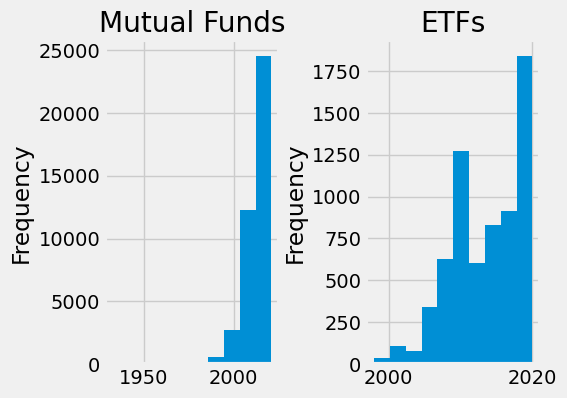

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 4))
plt.subplots_adjust(wspace=.5)
mf_train.inception_date.dt.year.plot.hist(ax=ax1, xlabel='Year', title='Mutual Funds')
etf_train.inception_date.dt.year.plot.hist(ax=ax2, xlabel='Year', title='ETFs')
plt.show()

In [76]:
print(f'The oldest ETF is from the year {etf_train.inception_date.dt.year.min()}.')
print(f'Count of Mutual Funds older than the oldest ETF: {(mf_train.inception_date.dt.year < 1998).sum()}')

The oldest ETF is from the year 1998.
Count of Mutual Funds older than the oldest ETF: 1170


Estimates of Location and Variability:

The maximum date of the Mutual Funds dataframe is September 2021 but for the ETFs is June 2020. This has implications for interpreting the YTD Returns feature.

In [77]:
pd.concat([mf_train.inception_date.describe(datetime_is_numeric=True).rename('Mutual Funds'), 
           etf_train.inception_date.describe(datetime_is_numeric=True).rename('ETFs')], 
           axis=1)

Mutual Funds                           ETFs
count                          40315                           6646
mean   2013-01-14 14:17:02.091033088  2013-10-31 19:35:00.631959040
min              1933-03-24 00:00:00            1998-01-13 00:00:00
25%              2010-09-20 00:00:00            2010-01-12 00:00:00
50%              2014-04-11 00:00:00            2014-11-12 00:00:00
75%              2017-09-06 00:00:00            2018-02-28 00:00:00
max              2021-09-06 00:00:00            2020-06-26 00:00:00

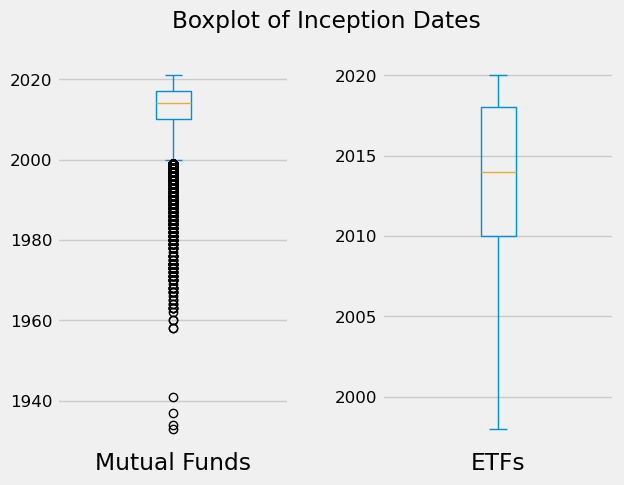

In [78]:
plt.subplots_adjust(hspace=.4, wspace=.4)

plt.subplot(121)
mf_train.inception_date.dt.year.plot.box()
plt.xticks([])
plt.yticks(fontsize=12)
plt.xlabel('Mutual Funds')

plt.subplot(122)
etf_train.inception_date.dt.year.plot.box()
plt.xticks([])
plt.yticks(fontsize=12)
plt.xlabel('ETFs')

plt.suptitle('Boxplot of Inception Dates')
plt.show()

**Equity Style & Size**

Estimates of Location & Variability: Equity Size Score and Equity Style Score

In [79]:
pd.concat([mf_equity.equity_size_score.describe().rename('MFs: Equity Size'), 
           etf_equity.equity_size_score.describe().rename('ETFs: Equity Size'),
           mf_equity.equity_style_score.describe().rename('MFs: Equity Style'), 
           etf_equity.equity_style_score.describe().rename('ETFs: Equity Style')], 
           axis=1)

MFs: Equity Size  ETFs: Equity Size  MFs: Equity Style  \
count      18294.000000        3900.000000       18294.000000   
mean         246.138899         266.100313         157.106333   
std           78.592531          64.656226          48.957776   
min         -166.040000          -3.430000          -0.190000   
25%          205.680000         243.552500         125.160000   
50%          255.480000         280.945000         155.760000   
75%          298.150000         300.400000         188.310000   
max          419.250000         424.600000         342.730000   

       ETFs: Equity Style  
count         3900.000000  
mean           143.263531  
std             41.345951  
min            -15.040000  
25%            127.725000  
50%            149.250000  
75%            162.790000  
max            314.820000

Equity Style - Value Counts:

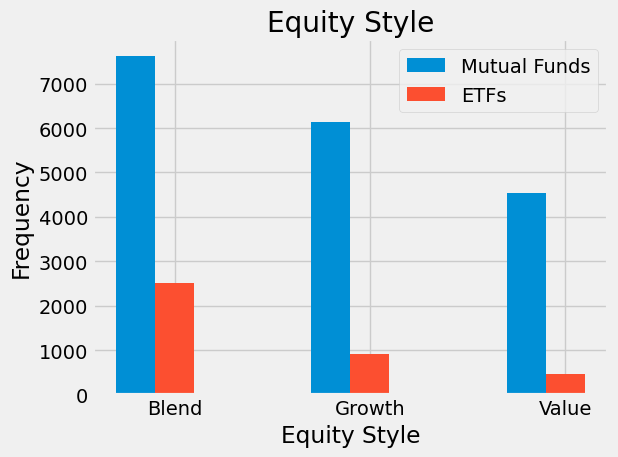

In [80]:
x = list(mf_equity.equity_style.value_counts().index)
y1 = list(mf_equity.equity_style.value_counts())
y2 = list(etf_equity.equity_style.value_counts())

# Set the position of the bars on the x-axis
bar_width = 0.2
index = np.arange(len(x))

# Plot the bars
plt.bar(index, y1, bar_width, label='Mutual Funds')
plt.bar(index + bar_width, y2, bar_width, label='ETFs')

# Customize the chart
plt.xlabel('Equity Style')
plt.ylabel('Frequency')
plt.title('Equity Style')
plt.xticks(index + bar_width, x)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()


Distribution of Equity Style Score:

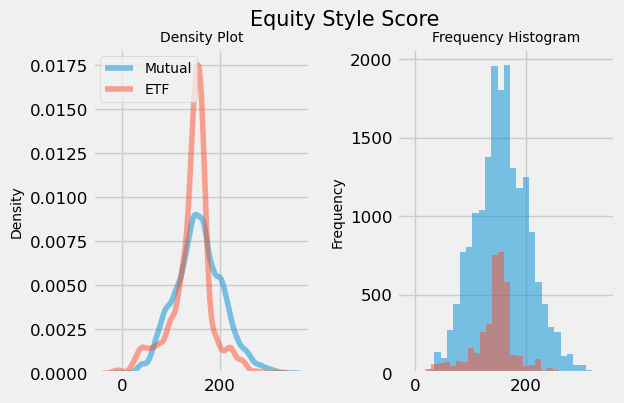

In [81]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(wspace=.4)

plt.subplot(121)
sns.kdeplot(mf_equity, x='equity_style_score', label='Mutual', alpha=0.5)
sns.kdeplot(etf_equity, x='equity_style_score', label='ETF', alpha=0.5)
plt.xlabel('')
plt.ylabel('Density', size=10)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Density Plot', size=10)
plt.legend(loc='upper left', fontsize=10)

plt.subplot(122)
plt.hist(mf_equity.equity_style_score, bins=30, alpha=0.5)
plt.hist(etf_equity.equity_style_score, bins=30, alpha=0.5)
plt.ylabel('Frequency', size=10)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Frequency Histogram', size=10)

# Display the chart
plt.suptitle('Equity Style Score\n', size=15)
plt.show()

Equity Style by Fund Returns:

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/812501368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'source'] = 'Mutual Funds'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/812501368.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'source'] = 'ETFs'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/812501368.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

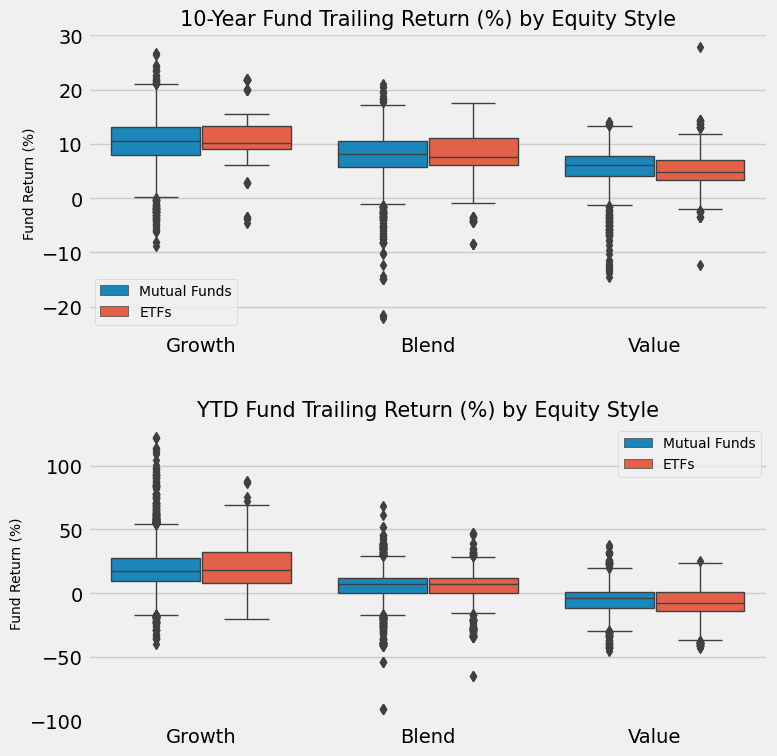

In [82]:
plt.figure(figsize=(8, 8))

plt.subplot(211)
df1 = mf_equity[['equity_style', 'fund_trailing_return_10years']]
df2 = etf_equity[['equity_style', 'fund_trailing_return_10years']]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'

combined_df = pd.concat([df1, df2], ignore_index=True)
sns.boxplot(data=combined_df, x='equity_style', 
            y='fund_trailing_return_10years', hue='source',
            linewidth=1)
plt.xlabel('')
plt.ylabel('Fund Return (%)', fontsize=10)
plt.title('10-Year Fund Trailing Return (%) by Equity Style', size=15)
plt.legend(fontsize=10)
plt.suptitle('')

plt.subplot(212)
df1 = mf_equity[['equity_style', 'fund_trailing_return_ytd']]
df2 = etf_equity[['equity_style', 'fund_trailing_return_ytd']]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'

combined_df = pd.concat([df1, df2], ignore_index=True)
sns.boxplot(data=combined_df, x='equity_style', 
            y='fund_trailing_return_ytd', hue='source',
            linewidth=1)
plt.xlabel('')
plt.ylabel('Fund Return (%)', fontsize=10)
plt.title('\nYTD Fund Trailing Return (%) by Equity Style', size=15)
plt.legend(fontsize=10)
plt.suptitle('')

plt.tight_layout()
plt.show()

Equity Style by Equity Style Score:

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/623640694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'source'] = 'Mutual Funds'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/623640694.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'source'] = 'ETFs'


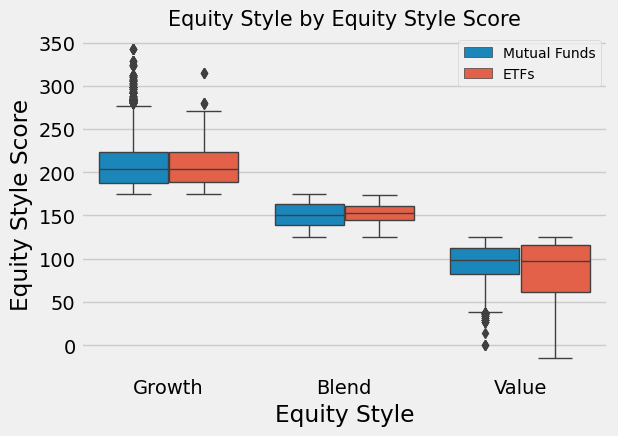

In [83]:
df1 = mf_equity[['equity_style', 'equity_style_score']]
df2 = etf_equity[['equity_style', 'equity_style_score']]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'

combined_df = pd.concat([df1, df2], ignore_index=True)

sns.boxplot(data=combined_df, x='equity_style', 
            y='equity_style_score', hue='source',
            linewidth=1)

plt.xlabel('Equity Style')
plt.ylabel('Equity Style Score')
plt.title('Equity Style by Equity Style Score', size=15)
plt.suptitle('')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

Equity Sizes - Value Counts:

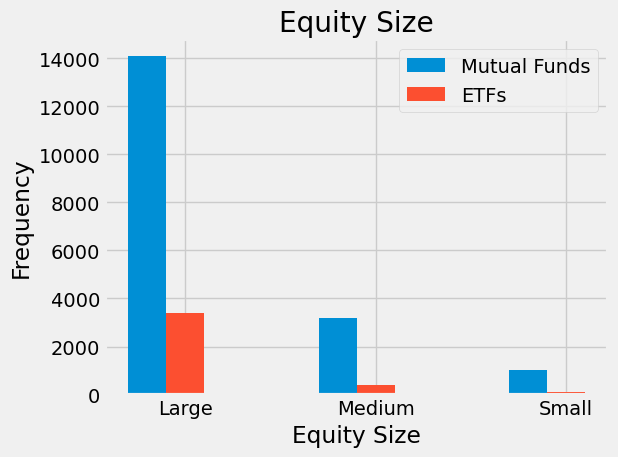

In [84]:
x = list(mf_equity.equity_size.value_counts().index)
y1 = list(mf_equity.equity_size.value_counts())
y2 = list(etf_equity.equity_size.value_counts())

# Set the position of the bars on the x-axis
bar_width = 0.2
index = np.arange(len(x))

# Plot the bars
plt.bar(index, y1, bar_width, label='Mutual Funds')
plt.bar(index + bar_width, y2, bar_width, label='ETFs')

# Customize the chart
plt.xlabel('Equity Size')
plt.ylabel('Frequency')
plt.title('Equity Size')
plt.xticks(index + bar_width, x)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()


Distribution of Equity Size Score:

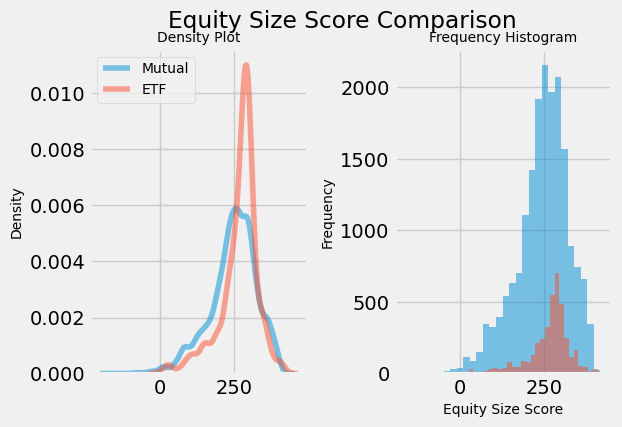

In [85]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(wspace=.4)

plt.subplot(121)
sns.kdeplot(mf_equity, x='equity_size_score', label='Mutual', alpha=0.5)
sns.kdeplot(etf_equity, x='equity_size_score', label='ETF', alpha=0.5)
plt.xlabel('')
plt.ylabel('Density', size=10)
plt.title('Density Plot', size=10)
plt.legend(loc='upper left', fontsize=10)

plt.subplot(122)
plt.hist(mf_equity.equity_size_score, bins=30, alpha=0.5)
plt.hist(etf_equity.equity_size_score, bins=30, alpha=0.5)
plt.xlabel('Equity Size Score', size=10)
plt.ylabel('Frequency', size=10)
plt.title('Frequency Histogram', size=10)

plt.suptitle('Equity Size Score Comparison')
plt.show()

Equity Size by Fund Returns:

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/2069848771.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'source'] = 'Mutual Funds'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/2069848771.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'source'] = 'ETFs'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/2069848771.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

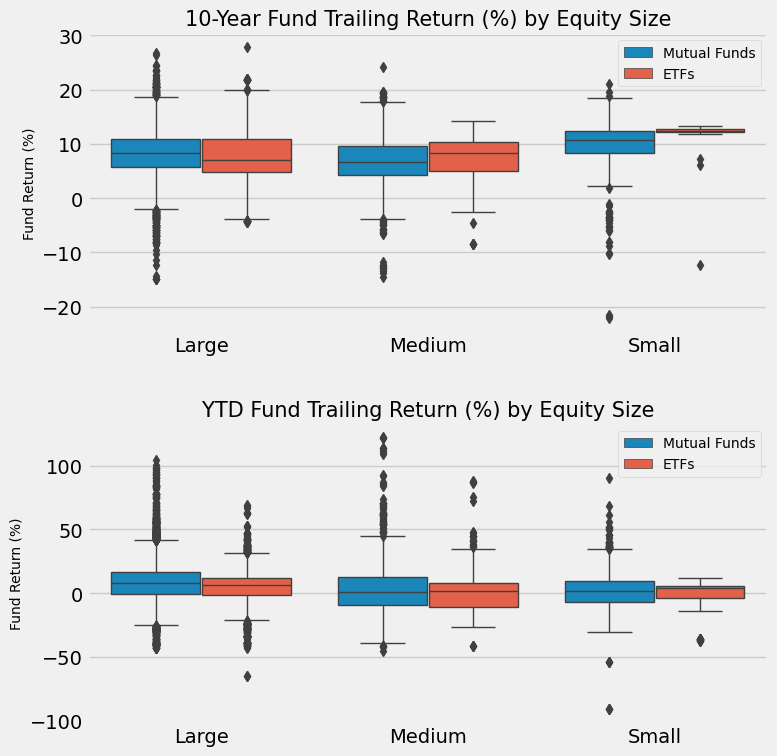

In [86]:
plt.figure(figsize=(8, 8))

plt.subplot(211)
df1 = mf_equity[['equity_size', 'fund_trailing_return_10years']]
df2 = etf_equity[['equity_size', 'fund_trailing_return_10years']]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'

combined_df = pd.concat([df1, df2], ignore_index=True)
sns.boxplot(data=combined_df, x='equity_size', 
            y='fund_trailing_return_10years', hue='source',
            linewidth=1)
plt.xlabel('')
plt.ylabel('Fund Return (%)', fontsize=10)
plt.title('10-Year Fund Trailing Return (%) by Equity Size', size=15)
plt.legend(fontsize=10)
plt.suptitle('')

plt.subplot(212)
df1 = mf_equity[['equity_size', 'fund_trailing_return_ytd']]
df2 = etf_equity[['equity_size', 'fund_trailing_return_ytd']]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'

combined_df = pd.concat([df1, df2], ignore_index=True)
sns.boxplot(data=combined_df, x='equity_size', 
            y='fund_trailing_return_ytd', hue='source',
            linewidth=1)
plt.xlabel('')
plt.ylabel('Fund Return (%)', fontsize=10)
plt.title('\nYTD Fund Trailing Return (%) by Equity Size', size=15)
plt.legend(fontsize=10)
plt.suptitle('')

plt.tight_layout()
plt.show()

Equity Size by Equity Size Score:

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/3506926018.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'source'] = 'Mutual Funds'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/3506926018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'source'] = 'ETFs'


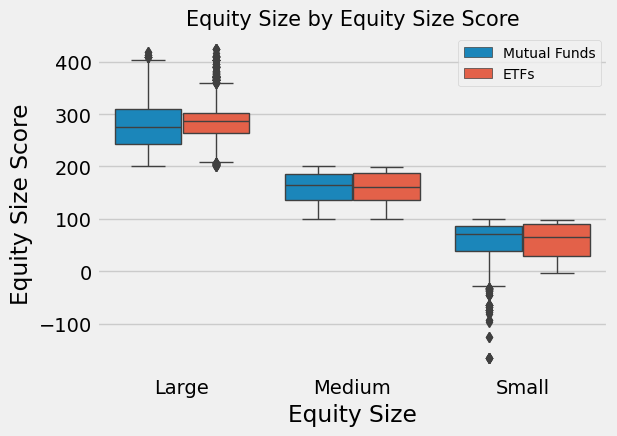

In [87]:
df1 = mf_equity[['equity_size', 'equity_size_score']]
df2 = etf_equity[['equity_size', 'equity_size_score']]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'

combined_df = pd.concat([df1, df2], ignore_index=True)

sns.boxplot(data=combined_df, x='equity_size', 
            y='equity_size_score', hue='source',
            linewidth=1)

plt.xlabel('Equity Size')
plt.ylabel('Equity Size Score')
plt.title('Equity Size by Equity Size Score', size=15)
plt.suptitle('')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

**Historical Earnings & Returns**

Estimates of Location and Variability - Historical Earnings and Returns:

In [88]:
pd.concat([mf_equity.historical_earnings_growth.describe().rename('MFs: Historical Earnings Growth'), 
           etf_equity.historical_earnings_growth.describe().rename('ETFs: Historical Earnings Growth'),
           mf_equity.roe.describe().rename('MFs: ROE'), 
           etf_equity.roe.describe().rename('ETFs: ROE'),
           mf_equity.roa.describe().rename('MFs: ROA'), 
           etf_equity.roa.describe().rename('ETFs: ROA'),
           mf_equity.roic.describe().rename('MFs: ROIC'), 
           etf_equity.roic.describe().rename('ETFs: ROIC')], 
           axis=1)

MFs: Historical Earnings Growth  ETFs: Historical Earnings Growth  \
count                     18289.000000                       3885.000000   
mean                          6.323513                          3.872263   
std                          10.618813                          9.037711   
min                         -42.820000                        -25.980000   
25%                           0.690000                         -1.580000   
50%                           5.410000                          3.820000   
75%                          10.710000                          9.290000   
max                         223.540000                         91.490000   

           MFs: ROE    ETFs: ROE      MFs: ROA    ETFs: ROA     MFs: ROIC  \
count  18125.000000  3880.000000  18125.000000  3880.000000  17801.000000   
mean      16.425628    15.368760      6.342508     5.446075     10.432586   
std        7.019191     7.910988      3.071647     3.098104      5.068996   
min      -23.590000   -16.150000    -22.240000   -20.440000    -44.980000   
25%       12.310000    10.340000      4.680000     3.727500      7.870000   
50%       16.530000    14.720000      6.680000     5.300000     10.940000   
75%       20.690000    20.870000      8.240000     7.540000     13.430000   
max       40.290000    43.480000     16.920000    14.600000     38.570000   

        ETFs: ROIC  
count  3758.000000  
mean      9.582621  
std       5.189600  
min     -56.940000  
25%       7.090000  
50%       9.785000  
75%      12.937500  
max      26.340000

**Distribution of Historical Earnings Growth**

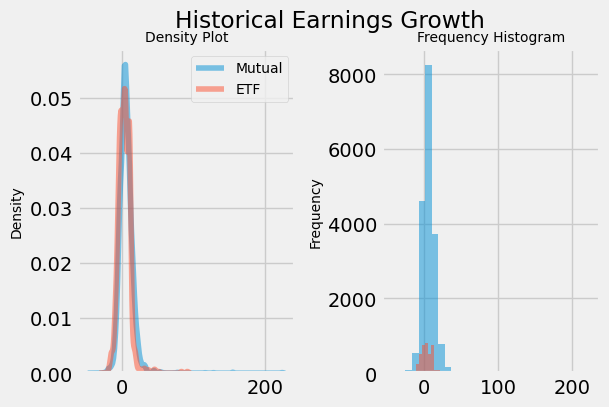

In [89]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(wspace=.4)

plt.subplot(121)
sns.kdeplot(mf_equity, x='historical_earnings_growth', label='Mutual', alpha=0.5)
sns.kdeplot(etf_equity, x='historical_earnings_growth', label='ETF', alpha=0.5)
plt.xlabel('')
plt.ylabel('Density', size=10)
plt.title('Density Plot', size=10)
plt.legend(loc='upper right', fontsize=10)

plt.subplot(122)
plt.hist(mf_equity.historical_earnings_growth, bins=30, alpha=0.5)
plt.hist(etf_equity.historical_earnings_growth, bins=30, alpha=0.5)
plt.ylabel('Frequency', size=10)
plt.title('Frequency Histogram', size=10)

plt.suptitle('Historical Earnings Growth')
plt.show()

Visualize outliers:

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/4102107771.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'source'] = 'Mutual Funds'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/4102107771.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'source'] = 'ETFs'


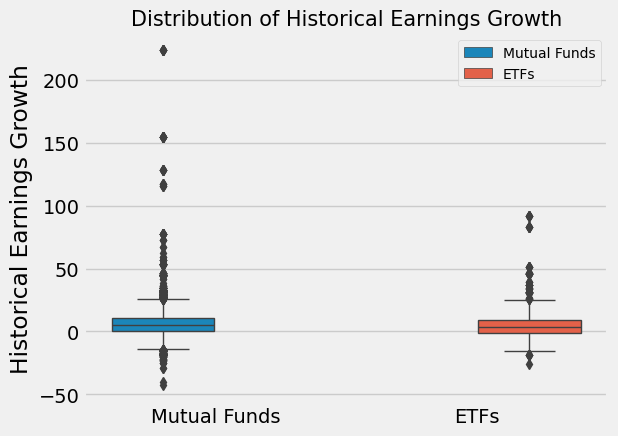

In [90]:
df1 = mf_equity[['historical_earnings_growth']]
df2 = etf_equity[['historical_earnings_growth']]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'
combined_df = pd.concat([df1, df2], ignore_index=True)

sns.boxplot(data=combined_df, x='source', y='historical_earnings_growth', hue='source',
            linewidth=1)

plt.xlabel('')
plt.ylabel('Historical Earnings Growth')
plt.title('Distribution of Historical Earnings Growth', size=15)
plt.suptitle('')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

**Compare Returns Features**

Distribution of Return on Assets:

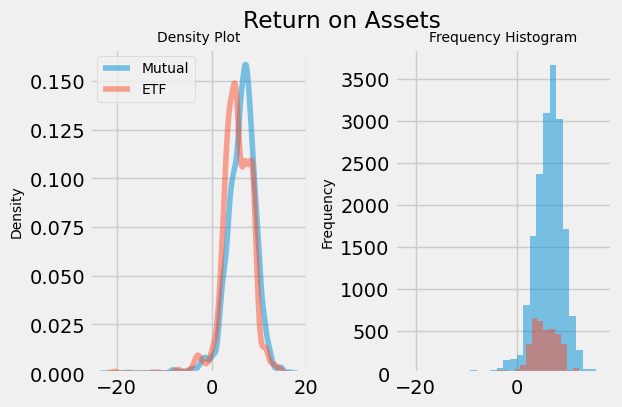

In [91]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(wspace=.4)

plt.subplot(121)
sns.kdeplot(mf_equity, x='roa', label='Mutual', alpha=0.5)
sns.kdeplot(etf_equity, x='roa', label='ETF', alpha=0.5)
plt.xlabel('')
plt.ylabel('Density', size=10)
plt.title('Density Plot', size=10)
plt.legend(loc='upper left', fontsize=10)

plt.subplot(122)
plt.hist(mf_equity.roa, bins=30, alpha=0.5)
plt.hist(etf_equity.roa, bins=30, alpha=0.5)
plt.ylabel('Frequency', size=10)
plt.title('Frequency Histogram', size=10)

plt.suptitle('Return on Assets')
plt.show()

Visualize outliers:

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/251080354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'source'] = 'Mutual Funds'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/251080354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'source'] = 'ETFs'


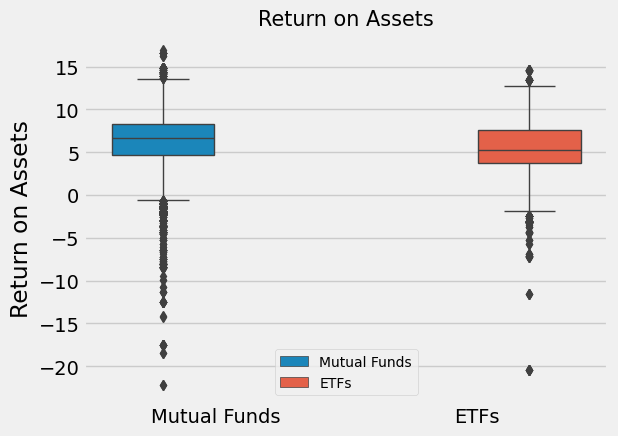

In [92]:
df1 = mf_equity[['roa']]
df2 = etf_equity[['roa']]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'
combined_df = pd.concat([df1, df2], ignore_index=True)

sns.boxplot(data=combined_df, x='source', y='roa', hue='source', linewidth=1)

plt.xlabel('')
plt.ylabel('Return on Assets')
plt.title('Return on Assets', size=15)
plt.suptitle('')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

Relationship between Return on Assets and Trailing Returns

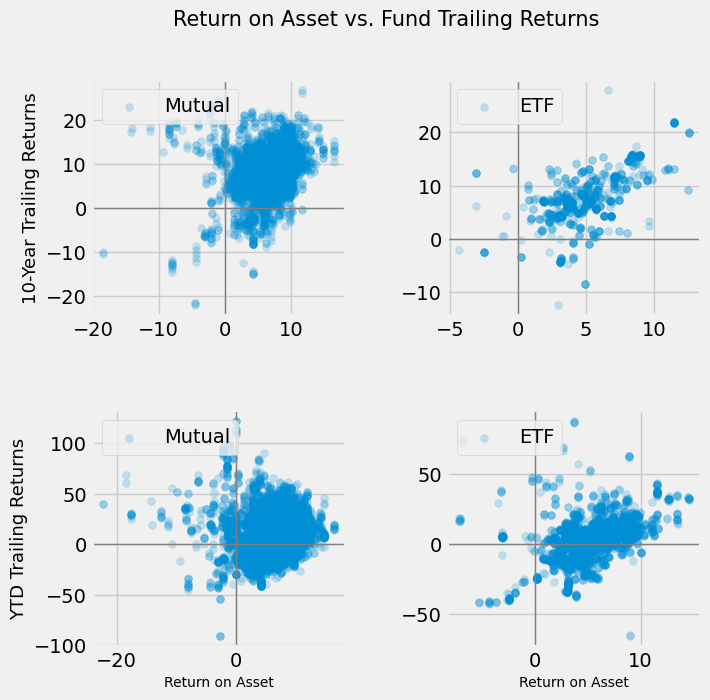

In [93]:
plt.figure(figsize=(7, 7))
plt.subplots_adjust(wspace=.4, hspace=.4)

plt.subplot(221)
plt.scatter(mf_equity.roa, mf_equity.fund_trailing_return_10years, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.ylabel('10-Year Trailing Returns', size=13)
plt.legend(loc='upper left')

plt.subplot(222)
plt.scatter(etf_equity.roa, etf_equity.fund_trailing_return_10years, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.legend(loc='upper left')

plt.subplot(223)
plt.scatter(mf_equity.roa, mf_equity.fund_trailing_return_ytd, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlabel('Return on Asset', size=10)
plt.ylabel('YTD Trailing Returns', size=13)
plt.legend(loc='upper left')

plt.subplot(224)
plt.scatter(etf_equity.roa, etf_equity.fund_trailing_return_ytd, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlabel('Return on Asset', size=10)
plt.legend(loc='upper left')

plt.suptitle('Return on Asset vs. Fund Trailing Returns', size=15)
plt.show()

Distribution of Return on Equity:

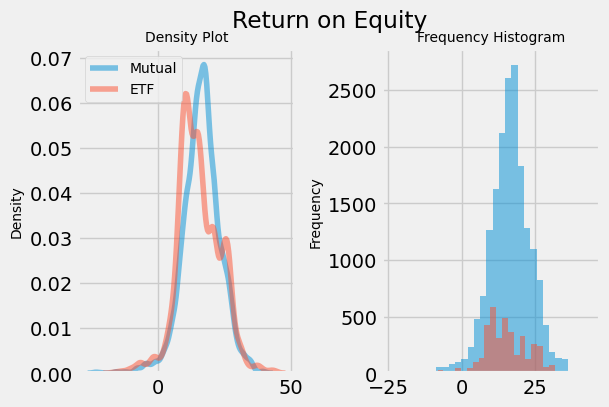

In [94]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(wspace=.4)

plt.subplot(121)
sns.kdeplot(mf_equity, x='roe', label='Mutual', alpha=0.5)
sns.kdeplot(etf_equity, x='roe', label='ETF', alpha=0.5)
plt.xlabel('')
plt.ylabel('Density', size=10)
plt.title('Density Plot', size=10)
plt.legend(loc='upper left', fontsize=10)

plt.subplot(122)
plt.hist(mf_equity.roe, bins=30, alpha=0.5)
plt.hist(etf_equity.roe, bins=30, alpha=0.5)
plt.ylabel('Frequency', size=10)
plt.title('Frequency Histogram', size=10)

plt.suptitle('Return on Equity')
plt.show()

Visualize outliers:

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/2780635414.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'source'] = 'Mutual Funds'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/2780635414.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'source'] = 'ETFs'


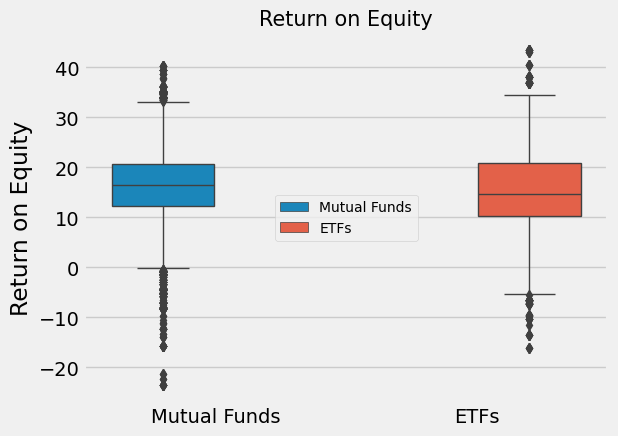

In [95]:
df1 = mf_equity[['roe']]
df2 = etf_equity[['roe']]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'
combined_df = pd.concat([df1, df2], ignore_index=True)

sns.boxplot(data=combined_df, x='source', y='roe', hue='source', linewidth=1)

plt.xlabel('')
plt.ylabel('Return on Equity')
plt.title('Return on Equity', size=15)
plt.suptitle('')
plt.legend(loc='center', fontsize=10)
plt.tight_layout()
plt.show()

Relationship between Return on Equity and Trailing Returns:

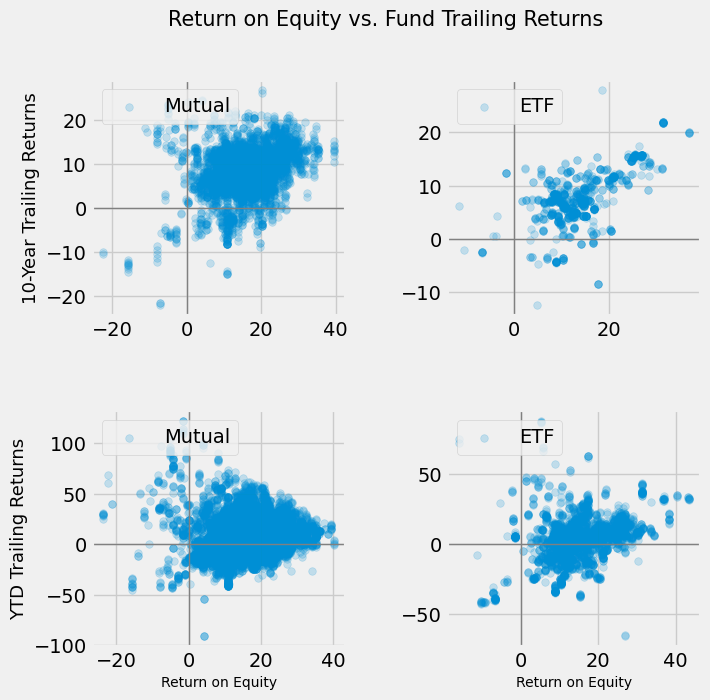

In [96]:
plt.figure(figsize=(7, 7))
plt.subplots_adjust(wspace=.4, hspace=.4)

plt.subplot(221)
plt.scatter(mf_equity.roe, mf_equity.fund_trailing_return_10years, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.ylabel('10-Year Trailing Returns', size=13)
plt.legend(loc='upper left')

plt.subplot(222)
plt.scatter(etf_equity.roe, etf_equity.fund_trailing_return_10years, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.legend(loc='upper left')

plt.subplot(223)
plt.scatter(mf_equity.roe, mf_equity.fund_trailing_return_ytd, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlabel('Return on Equity', size=10)
plt.ylabel('YTD Trailing Returns', size=13)
plt.legend(loc='upper left')

plt.subplot(224)
plt.scatter(etf_equity.roe, etf_equity.fund_trailing_return_ytd, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlabel('Return on Equity', size=10)
plt.legend(loc='upper left')

plt.suptitle('Return on Equity vs. Fund Trailing Returns', size=15)
plt.show()

Distribution of Return on Investment:

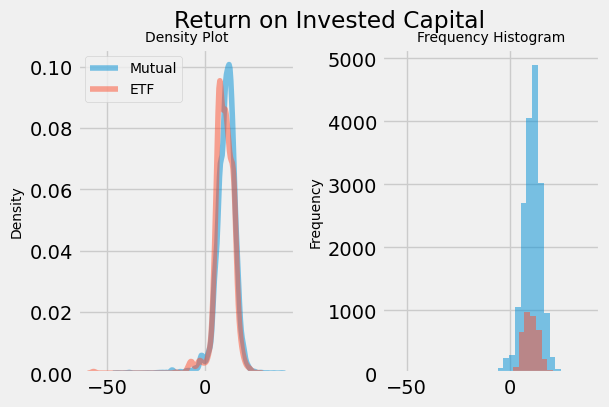

In [97]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(wspace=.4)

plt.subplot(121)
sns.kdeplot(mf_equity, x='roic', label='Mutual', alpha=0.5)
sns.kdeplot(etf_equity, x='roic', label='ETF', alpha=0.5)
plt.xlabel('')
plt.ylabel('Density', size=10)
plt.title('Density Plot', size=10)
plt.legend(loc='upper left', fontsize=10)

plt.subplot(122)
plt.hist(mf_equity.roic, bins=30, alpha=0.5)
plt.hist(etf_equity.roic, bins=30, alpha=0.5)
plt.ylabel('Frequency', size=10)
plt.title('Frequency Histogram', size=10)

plt.suptitle('Return on Invested Capital')
plt.show()

Visualize outliers:

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/2779982988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'source'] = 'Mutual Funds'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/2779982988.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'source'] = 'ETFs'


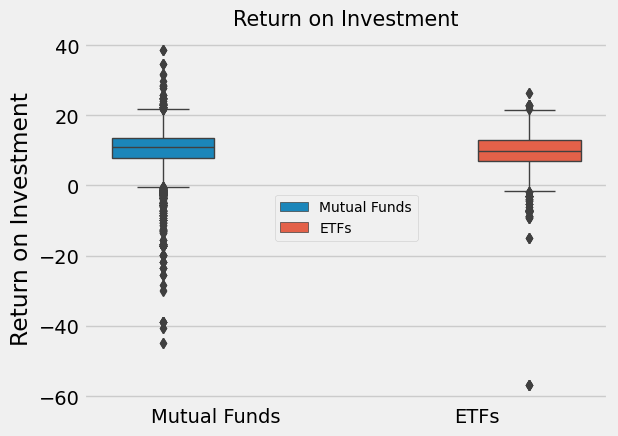

In [98]:
df1 = mf_equity[['roic']]
df2 = etf_equity[['roic']]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'
combined_df = pd.concat([df1, df2], ignore_index=True)

sns.boxplot(data=combined_df, x='source', y='roic', hue='source', linewidth=1)

plt.xlabel('')
plt.ylabel('Return on Investment')
plt.title('Return on Investment', size=15)
plt.suptitle('')
plt.legend(loc='center', fontsize=10)
plt.tight_layout()
plt.show()

Relationship between Return on Investment and Trailing Returns

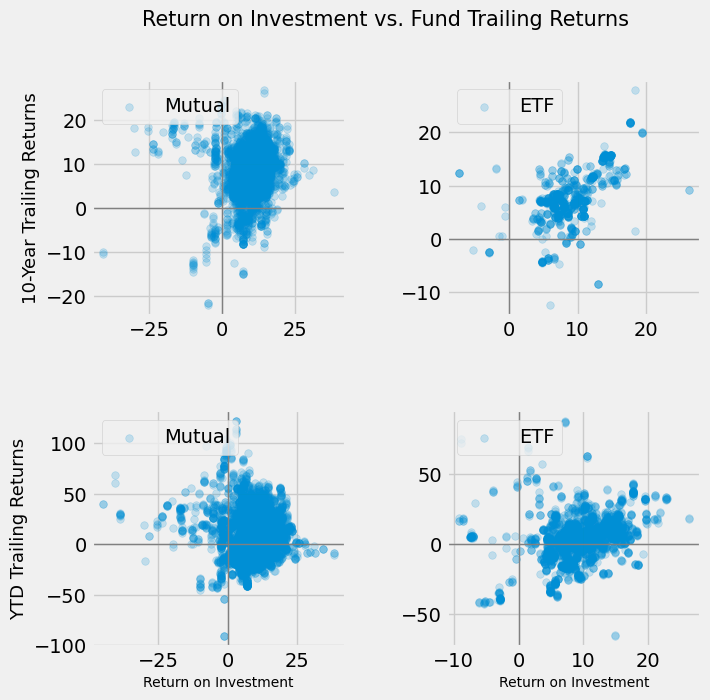

In [99]:
plt.figure(figsize=(7, 7))
plt.subplots_adjust(wspace=.4, hspace=.4)

plt.subplot(221)
plt.scatter(mf_equity.roic, mf_equity.fund_trailing_return_10years, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.ylabel('10-Year Trailing Returns', size=13)
plt.legend(loc='upper left')

plt.subplot(222)
plt.scatter(etf_equity.roic, etf_equity.fund_trailing_return_10years, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.legend(loc='upper left')

plt.subplot(223)
plt.scatter(mf_equity.roic, mf_equity.fund_trailing_return_ytd, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlabel('Return on Investment', size=10)
plt.ylabel('YTD Trailing Returns', size=13)
plt.legend(loc='upper left')

plt.subplot(224)
plt.scatter(etf_equity.roic, etf_equity.fund_trailing_return_ytd, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlabel('Return on Investment', size=10)
plt.legend(loc='upper left')

plt.suptitle('Return on Investment vs. Fund Trailing Returns', size=15)
plt.show()

Plot the CDF of Return features:

In [100]:
def Pmf(array):
    n = len(array)
    if isinstance(array, list):
        pmf = {val: array.count(val) / n for val in array}
    elif isinstance(array, pd.Series):
        pmf = {val: array.tolist().count(val) / n for ind, val in array.items()}
    elif isinstance(array, dict):
        d_n = sum(array.values())
        pmf = {key: val / d_n for key, val in array.items()}
    elif isinstance(array, np.ndarray):
        unique, frequency = np.unique(array, return_counts=True)
        pmf = dict(zip(unique, frequency / n))
    return pmf

def Cdf(obj):
    if isinstance(obj, dict):
        dw = obj
    else:
        dw = Counter(obj)

    xs, freqs = zip(*sorted(dw.items()))
    xs = np.asarray(xs)
    ps = np.cumsum(freqs, dtype=float)
    ps /= ps[-1]

    combined_dict = {key: value for key, value in zip(xs, ps)}
    return combined_dict

def PercentileRank(scores, your_score):
    count = 0
    for score in scores:
        if score <= your_score:
            count += 1
    percentile_rank = 100.0 * count / len(scores)
    return percentile_rank

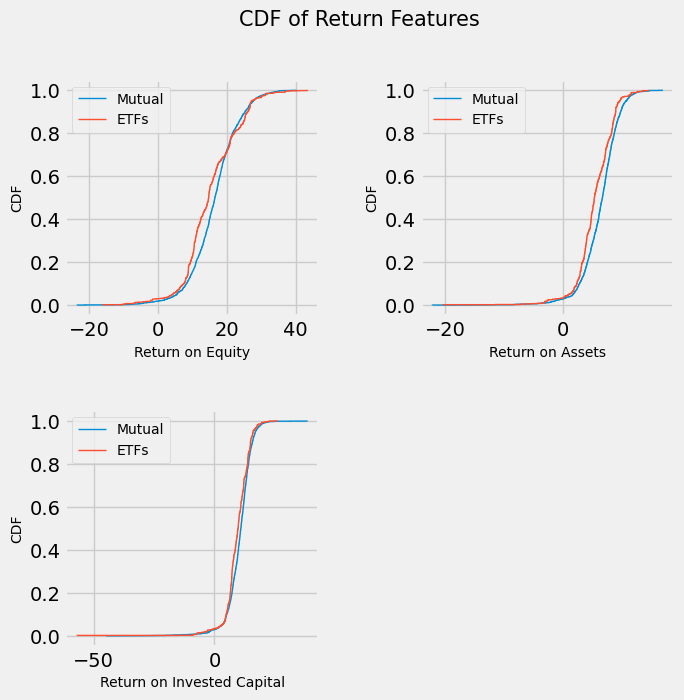

In [101]:
plt.figure(figsize=(7, 7))
plt.subplots_adjust(hspace=.4, wspace=.4)

plt.subplot(221)
mf_cdf = Cdf(mf_equity.roe.dropna())
etf_cdf = Cdf(etf_equity.roe.dropna())
plt.plot(mf_cdf.keys(), mf_cdf.values(), label='Mutual', drawstyle='steps', lw=1)
plt.plot(etf_cdf.keys(), etf_cdf.values(), label='ETFs', drawstyle='steps', lw=1)
plt.xlabel('Return on Equity', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.legend(fontsize=10)

plt.subplot(222)
mf_cdf = Cdf(mf_equity.roa.dropna())
etf_cdf = Cdf(etf_equity.roa.dropna())
plt.plot(mf_cdf.keys(), mf_cdf.values(), label='Mutual', drawstyle='steps', lw=1)
plt.plot(etf_cdf.keys(), etf_cdf.values(), label='ETFs', drawstyle='steps', lw=1)
plt.xlabel('Return on Assets', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.legend(fontsize=10)

plt.subplot(223)
mf_cdf = Cdf(mf_equity.roic.dropna())
etf_cdf = Cdf(etf_equity.roic.dropna())
plt.plot(mf_cdf.keys(), mf_cdf.values(), label='Mutual', drawstyle='steps', lw=1)
plt.plot(etf_cdf.keys(), etf_cdf.values(), label='ETFs', drawstyle='steps', lw=1)
plt.xlabel('Return on Invested Capital', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.legend(fontsize=10)

plt.suptitle('CDF of Return Features', fontsize=15)
plt.show()

Plot the percentile ranks:

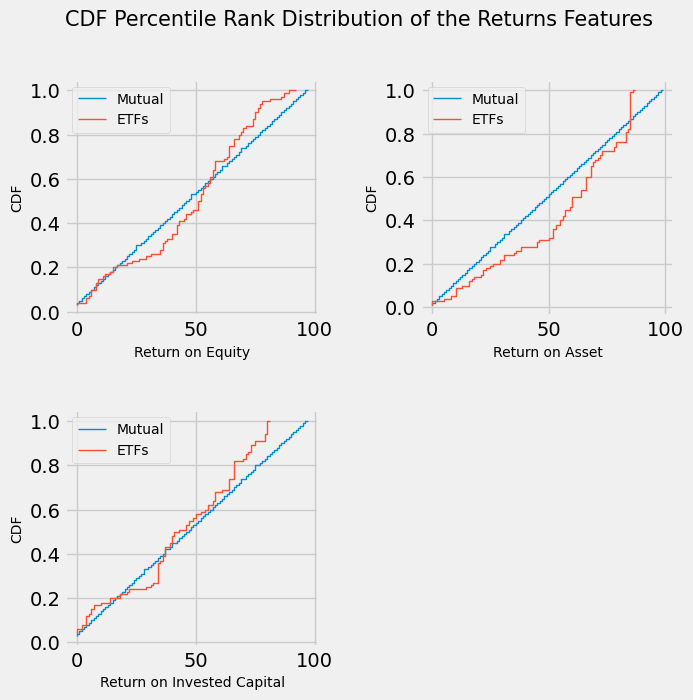

In [102]:
plt.figure(figsize=(7, 7))
plt.subplots_adjust(hspace=.4, wspace=.4)

plt.subplot(221)
mf_sample = np.random.choice(mf_equity.roe, 100, replace=True)
etf_sample = np.random.choice(etf_equity.roe, 100, replace=True)

mf_ranks = [PercentileRank(mf_sample, x) for x in mf_sample]
etf_ranks = [PercentileRank(etf_sample, x) for x in mf_sample]

mf_cdf = Cdf(mf_ranks)
etf_cdf = Cdf(etf_ranks)

plt.plot(mf_cdf.keys(), mf_cdf.values(), label='Mutual', drawstyle='steps', lw=1)
plt.plot(etf_cdf.keys(), etf_cdf.values(), label='ETFs', drawstyle='steps', lw=1)
plt.xlabel('Return on Equity', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.legend(fontsize=10)

plt.subplot(222)
mf_sample = np.random.choice(mf_equity.roa, 100, replace=True)
etf_sample = np.random.choice(etf_equity.roa, 100, replace=True)

mf_ranks = [PercentileRank(mf_sample, x) for x in mf_sample]
etf_ranks = [PercentileRank(etf_sample, x) for x in mf_sample]

mf_cdf = Cdf(mf_ranks)
etf_cdf = Cdf(etf_ranks)

plt.plot(mf_cdf.keys(), mf_cdf.values(), label='Mutual', drawstyle='steps', lw=1)
plt.plot(etf_cdf.keys(), etf_cdf.values(), label='ETFs', drawstyle='steps', lw=1)
plt.xlabel('Return on Asset', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.legend(fontsize=10)

plt.subplot(223)
mf_sample = np.random.choice(mf_equity.roic, 100, replace=True)
etf_sample = np.random.choice(etf_equity.roic, 100, replace=True)

mf_ranks = [PercentileRank(mf_sample, x) for x in mf_sample]
etf_ranks = [PercentileRank(etf_sample, x) for x in mf_sample]

mf_cdf = Cdf(mf_ranks)
etf_cdf = Cdf(etf_ranks)

plt.plot(mf_cdf.keys(), mf_cdf.values(), label='Mutual', drawstyle='steps', lw=1)
plt.plot(etf_cdf.keys(), etf_cdf.values(), label='ETFs', drawstyle='steps', lw=1)
plt.xlabel('Return on Invested Capital', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.legend(fontsize=10)

plt.suptitle('CDF Percentile Rank Distribution of the Returns Features', fontsize=15)
plt.show()

Plot the normal probability plot:

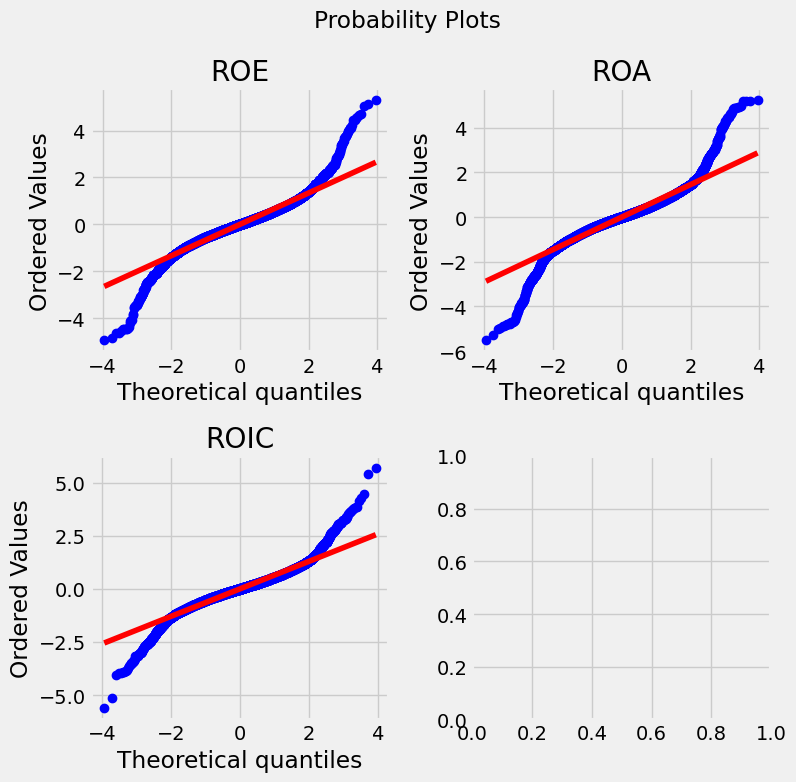

In [103]:
roe = mf_equity.roe
roe = np.diff(np.log(roe[roe > 0]))

roa = mf_equity.roa
roa = np.diff(np.log(roa[roa > 0]))

roic = mf_equity.roic
roic = np.diff(np.log(roic[roic > 0]))

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, df, name in zip(axes.ravel(), [roe, roa, roic], ['ROE', 'ROA', 'ROIC']):
    stats.probplot(df, plot=ax)
    ax.set_title(name)

plt.suptitle('Probability Plots')
plt.tight_layout()
plt.show()

In [104]:
def Var(xs, mu=None, ddof=0):
    xs = np.asarray(xs)
    if mu is None:
        mu = xs.mean()
    ds = xs - mu
    return np.dot(ds, ds) / (len(xs) - ddof)

def Std(xs, mu=None, ddof=0):
    var = Var(xs, mu, ddof)
    return math.sqrt(var)

def MeanVar(xs, ddof=0):
    xs = np.asarray(xs)
    mean = np.mean(xs)
    s2 = Var(xs, mean, ddof)
    return mean, s2

def Trim(t, p=0.01):
    n = int(p * len(t))
    t = sorted(t)[n:-n]
    return t

def TrimmedMean(t, p=0.01):
    t = Trim(t, p)
    return np.mean(t)

def TrimmedMeanVar(t, p=0.01, ddof=0):
    t = Trim(t, p)
    mu = np.mean(t)
    ds = t - mu
    var = np.dot(ds, ds) / (len(xs) - ddof)
    return mu, var

def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

def NormalProbability(ys, jitter=0):
    n = len(ys)
    xs = np.random.normal(0, 1, n)
    xs.sort()
    if jitter:
        ys = Jitter(ys, jitter)
    else:
        ys = np.array(ys)
    ys.sort()
    return xs, ys

def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

def NormalProbabilityPlot(sample):
    xs, ys = NormalProbability(sample)
    mean, var = MeanVar(sample)
    std = math.sqrt(var)
    fit = FitLine(xs, mean, std)
    plt.plot(*fit, label="model")
    xs, ys = NormalProbability(sample)
    plt.plot(xs, ys)

ROE
Mean: 16.425628
Var: 49.266
Std: 7.019
**********
ROA
Mean: 6.342508
Var: 9.434
Std: 3.072
**********
ROIC
Mean: 10.432586
Var: 25.693
Std: 5.069


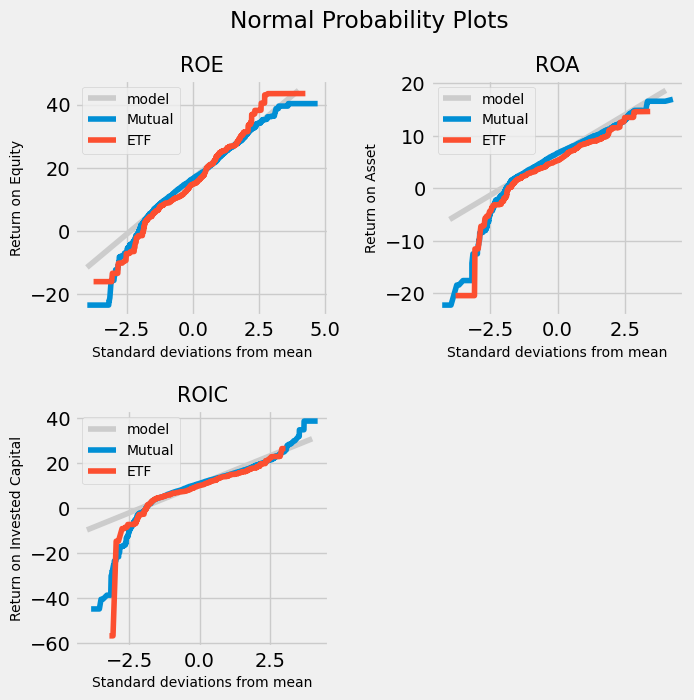

In [105]:
plt.figure(figsize=(7, 7))
plt.subplots_adjust(hspace=.4, wspace=.4)

plt.subplot(221)
mf = mf_equity.roe.dropna()
etf = etf_equity.roe.dropna()
mean, var = MeanVar(mf)
std = np.sqrt(var)
print(f'ROE\nMean: {mean:.6f}\nVar: {var:.3f}\nStd: {std:.3f}')
print('*'*10)

xs = [-4, 4]
fxs, fys = FitLine(xs, mean, std)
plt.plot(fxs, fys, linewidth=4, color="0.8", label='model')
xs, ys = NormalProbability(mf)
plt.plot(xs, ys, label="Mutual")
xs, ys = NormalProbability(etf)
plt.plot(xs, ys, label="ETF")

plt.title('ROE', fontsize=15)
plt.xlabel('Standard deviations from mean', fontsize=10)
plt.ylabel('Return on Equity', fontsize=10)
plt.legend(fontsize=10)

plt.subplot(222)
mf = mf_equity.roa.dropna()
etf = etf_equity.roa.dropna()
mean, var = MeanVar(mf)
std = np.sqrt(var)
print(f'ROA\nMean: {mean:.6f}\nVar: {var:.3f}\nStd: {std:.3f}')
print('*'*10)

xs = [-4, 4]
fxs, fys = FitLine(xs, mean, std)
plt.plot(fxs, fys, linewidth=4, color="0.8", label='model')
xs, ys = NormalProbability(mf)
plt.plot(xs, ys, label="Mutual")
xs, ys = NormalProbability(etf)
plt.plot(xs, ys, label="ETF")

plt.title('ROA', fontsize=15)
plt.xlabel('Standard deviations from mean', fontsize=10)
plt.ylabel('Return on Asset', fontsize=10)
plt.legend(fontsize=10)

plt.subplot(223)
mf = mf_equity.roic.dropna()
etf = etf_equity.roic.dropna()
mean, var = MeanVar(mf)
std = np.sqrt(var)
print(f'ROIC\nMean: {mean:.6f}\nVar: {var:.3f}\nStd: {std:.3f}')

xs = [-4, 4]
fxs, fys = FitLine(xs, mean, std)
plt.plot(fxs, fys, linewidth=4, color="0.8", label='model')
xs, ys = NormalProbability(mf)
plt.plot(xs, ys, label="Mutual")
xs, ys = NormalProbability(etf)
plt.plot(xs, ys, label="ETF")

plt.title('ROIC', fontsize=15)
plt.xlabel('Standard deviations from mean', fontsize=10)
plt.ylabel('Return on Invested Capital', fontsize=10)
plt.legend(fontsize=10)

plt.suptitle('Normal Probability Plots')
plt.show()

**Relationship between Equity Style & Size and Returns Features**

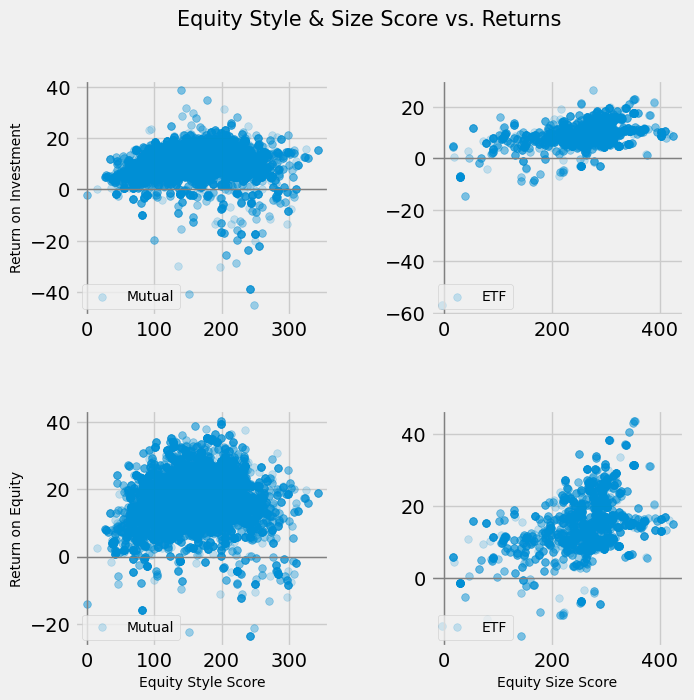

In [106]:
plt.figure(figsize=(7, 7))
plt.subplots_adjust(hspace=.4, wspace=.4)

plt.subplot(221)
plt.scatter(mf_equity.equity_style_score, mf_equity.roic, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
# plt.xlabel('Equity Style Score', size=10)
plt.ylabel('Return on Investment', size=10)
plt.legend(loc='lower left', fontsize=10)

plt.subplot(222)
plt.scatter(etf_equity.equity_size_score, etf_equity.roic, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
# plt.xlabel('Equity Size Score', size=10)
plt.legend(loc='lower left', fontsize=10)

plt.subplot(223)
plt.scatter(mf_equity.equity_style_score, mf_equity.roe, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlabel('Equity Style Score', size=10)
plt.ylabel('Return on Equity', size=10)
plt.legend(loc='lower left', fontsize=10)

plt.subplot(224)
plt.scatter(etf_equity.equity_size_score, etf_equity.roe, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlabel('Equity Size Score', size=10)
plt.legend(loc='lower left', fontsize=10)

plt.suptitle('Equity Style & Size Score vs. Returns', size=15)
plt.show()

Percentile Relationships:

In [107]:
def Value(xs, ps, p):
    if p < 0 or p > 1:
        raise ValueError("Probability p must be in range [0, 1]")
    xs = list(xs)
    ps = list(ps)
    index = bisect.bisect_left(ps, p)
    return xs[index]

def Percentile(cdf, p):
    return Value(cdf.keys(), cdf.values(), p / 100)

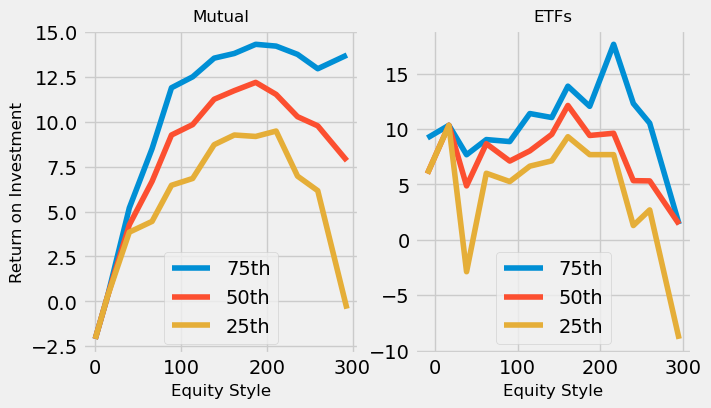

In [108]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['equity_style_score', 'roic'])
bins = np.arange(0, 300, 25)
indices = np.digitize(mf.equity_style_score, bins)
groups = mf.groupby(indices)

eq = [group.equity_style_score.mean() for i, group in groups]
cdfs = [Cdf(group.roic) for i, group in groups]

for percent in [75, 50, 25]:
    roic = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, roic, label=label)

plt.legend()
plt.xlabel('Equity Style', size=12)
plt.ylabel('Return on Investment', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['equity_style_score', 'roic'])
bins = np.arange(0, 300, 25)
indices = np.digitize(etf.equity_style_score, bins)
groups = etf.groupby(indices)

eq = [group.equity_style_score.mean() for i, group in groups]
cdfs = [Cdf(group.roic) for i, group in groups]

for percent in [75, 50, 25]:
    roic = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, roic, label=label)

plt.legend()
plt.xlabel('Equity Style', size=12)
plt.title('ETFs', size=12)

plt.show()

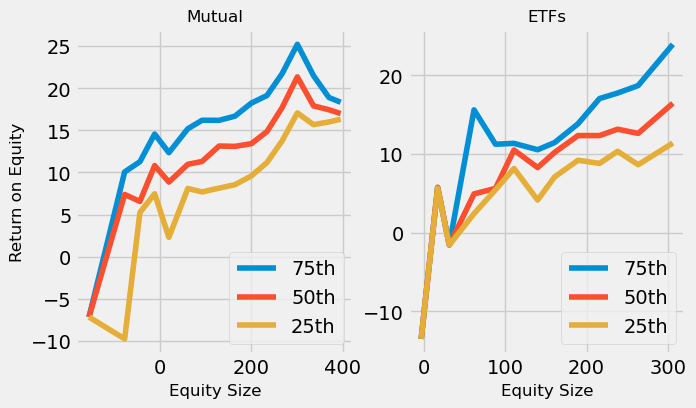

In [109]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['equity_size_score', 'roe'])
bins = np.arange(-100, 400, 35)
indices = np.digitize(mf.equity_size_score, bins)
groups = mf.groupby(indices)

eq = [group.equity_size_score.mean() for i, group in groups]
cdfs = [Cdf(group.roe) for i, group in groups]

for percent in [75, 50, 25]:
    roe = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, roe, label=label)

plt.legend()
plt.xlabel('Equity Size', size=12)
plt.ylabel('Return on Equity', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['equity_size_score', 'roe'])
bins = np.arange(0, 300, 25)
indices = np.digitize(etf.equity_size_score, bins)
groups = etf.groupby(indices)

eq = [group.equity_size_score.mean() for i, group in groups]
cdfs = [Cdf(group.roe) for i, group in groups]

for percent in [75, 50, 25]:
    roe = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, roe, label=label)

plt.legend()
plt.xlabel('Equity Size', size=12)
plt.title('ETFs', size=12)

plt.show()

**Ratings**

All 3 ratings features have the same visual representation.

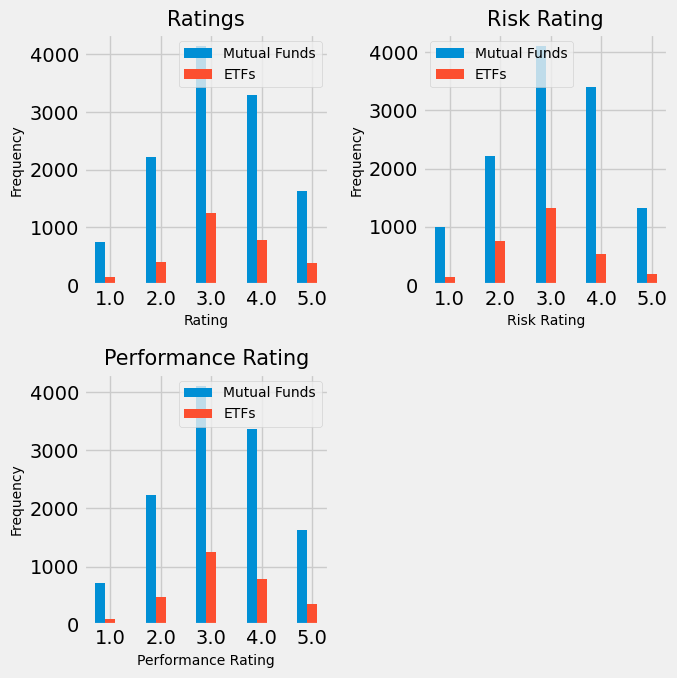

In [110]:
plt.figure(figsize=(7, 7))
plt.subplots_adjust(hspace=.4, wspace=.4)

plt.subplot(221)
x = list(mf_equity.rating.value_counts().index.sort_values())
y1 = list(mf_equity.rating.value_counts().sort_index())
y2 = list(etf_equity.rating.value_counts().sort_index())

bar_width = 0.2
index = np.arange(len(x))

plt.bar(index, y1, bar_width, label='Mutual Funds')
plt.bar(index + bar_width, y2, bar_width, label='ETFs')

plt.xlabel('Rating', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Ratings', fontsize=15)
plt.xticks(index + bar_width, x)
plt.legend(fontsize=10)

plt.subplot(222)
x = list(mf_equity.risk_rating.value_counts().index.sort_values())
y1 = list(mf_equity.risk_rating.value_counts().sort_index())
y2 = list(etf_equity.risk_rating.value_counts().sort_index())

bar_width = 0.2
index = np.arange(len(x))

plt.bar(index, y1, bar_width, label='Mutual Funds')
plt.bar(index + bar_width, y2, bar_width, label='ETFs')

plt.xlabel('Risk Rating', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Risk Rating', fontsize=15)
plt.xticks(index + bar_width, x)
plt.legend(fontsize=10)

plt.subplot(223)
x = list(mf_equity.performance_rating.value_counts().index.sort_values())
y1 = list(mf_equity.performance_rating.value_counts().sort_index())
y2 = list(etf_equity.performance_rating.value_counts().sort_index())

bar_width = 0.2
index = np.arange(len(x))

plt.bar(index, y1, bar_width, label='Mutual Funds')
plt.bar(index + bar_width, y2, bar_width, label='ETFs')

plt.xlabel('Performance Rating', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Performance Rating', fontsize=15)
plt.xticks(index + bar_width, x)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()


**ESG Scores and Fund Returns**

Environmental Score:

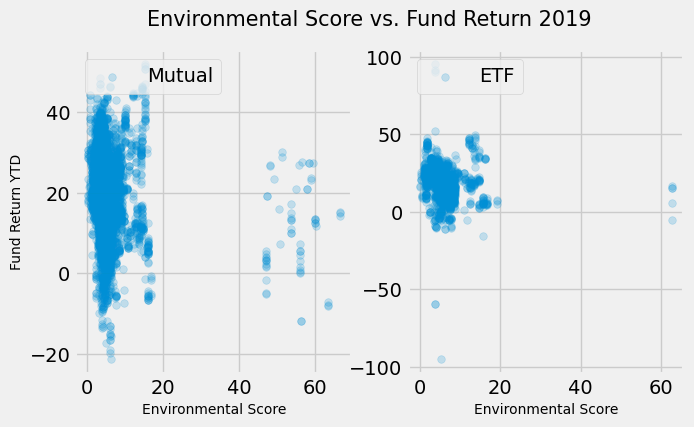

In [111]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
plt.scatter(mf_equity.environmental_score, mf_equity.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.xlabel('Environmental Score', size=10)
plt.ylabel('Fund Return YTD', size=10)
plt.legend(loc='upper left')

plt.subplot(122)
plt.scatter(etf_equity.environmental_score, etf_equity.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.xlabel('Environmental Score', size=10)
plt.legend(loc='upper left')

plt.suptitle('Environmental Score vs. Fund Return 2019', size=15)
plt.show()

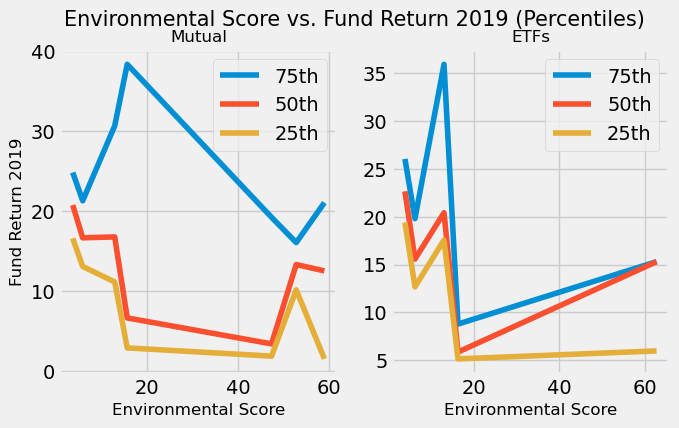

In [112]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['environmental_score', 'fund_return_2019'])
bins = np.arange(0, 60, 5)
indices = np.digitize(mf.environmental_score, bins)
groups = mf.groupby(indices)

eq = [group.environmental_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Environmental Score', size=12)
plt.ylabel('Fund Return 2019', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['environmental_score', 'fund_return_2019'])
bins = np.arange(0, 60, 5)
indices = np.digitize(etf.environmental_score, bins)
groups = etf.groupby(indices)

eq = [group.environmental_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Environmental Score', size=12)
plt.title('ETFs', size=12)

plt.suptitle('Environmental Score vs. Fund Return 2019 (Percentiles)', size=15)
plt.show()

Trimmed Outliers:

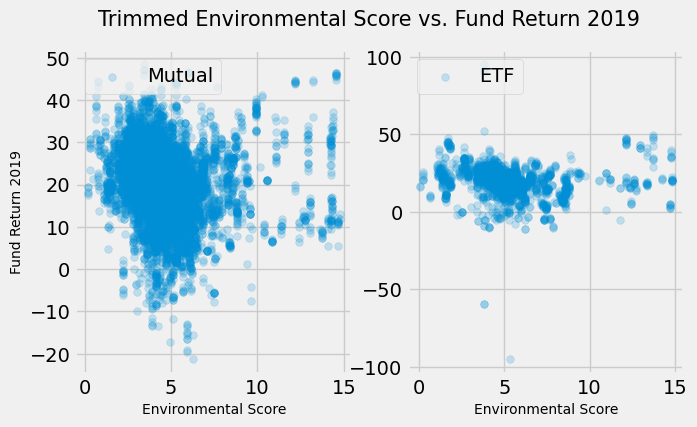

In [113]:
mf = mf_equity.dropna(subset=['environmental_score', 'fund_return_2019'])
mf = mf.loc[mf.environmental_score <= 15] # Remove outliers
etf = etf_equity.dropna(subset=['environmental_score', 'fund_return_2019'])
etf = etf.loc[etf.environmental_score <= 15] # Remove outliers

plt.figure(figsize=(7, 4))

plt.subplot(121)
plt.scatter(mf.environmental_score, mf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.xlabel('Environmental Score', size=10)
plt.ylabel('Fund Return 2019', size=10)
plt.legend(loc='upper left')

plt.subplot(122)
plt.scatter(etf.environmental_score, etf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.xlabel('Environmental Score', size=10)
plt.legend(loc='upper left')

plt.suptitle('Trimmed Environmental Score vs. Fund Return 2019', size=15)
plt.show()

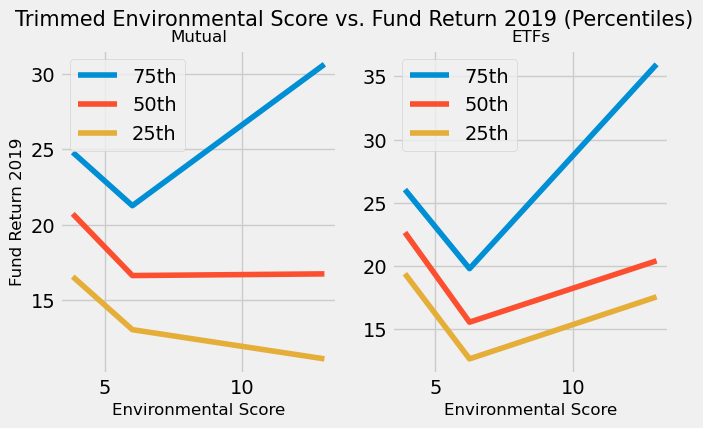

In [114]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['environmental_score', 'fund_return_2019'])
mf = mf.loc[mf.environmental_score <= 15] # Remove outliers
bins = np.arange(0, 60, 5)
indices = np.digitize(mf.environmental_score, bins)
groups = mf.groupby(indices)

eq = [group.environmental_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Environmental Score', size=12)
plt.ylabel('Fund Return 2019', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['environmental_score', 'fund_return_2019'])
etf = etf.loc[etf.environmental_score <= 15] # Remove outliers
bins = np.arange(0, 60, 5)
indices = np.digitize(etf.environmental_score, bins)
groups = etf.groupby(indices)

eq = [group.environmental_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Environmental Score', size=12)
plt.title('ETFs', size=12)

plt.suptitle('Trimmed Environmental Score vs. Fund Return 2019 (Percentiles)', size=15)
plt.show()

Social Score:

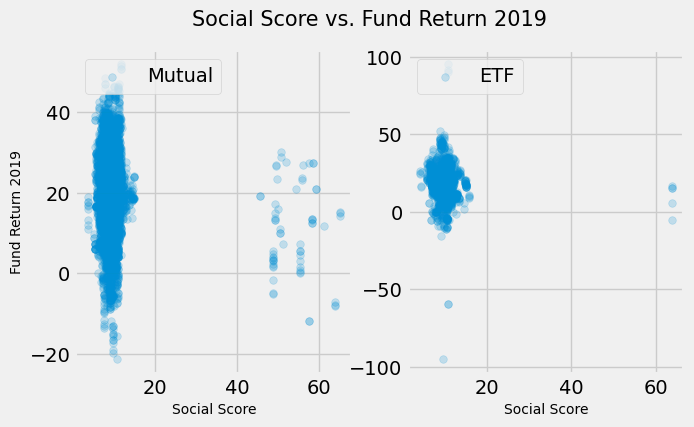

In [115]:
plt.figure(figsize=(7, 4))

mf = mf_equity.dropna(subset=['social_score', 'fund_return_2019'])
etf = etf_equity.dropna(subset=['social_score', 'fund_return_2019'])

plt.subplot(121)
plt.scatter(mf.social_score, mf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.xlabel('Social Score', size=10)
plt.ylabel('Fund Return 2019', size=10)
plt.legend(loc='upper left')

plt.subplot(122)
plt.scatter(etf.social_score, etf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.xlabel('Social Score', size=10)
plt.legend(loc='upper left')

plt.suptitle('Social Score vs. Fund Return 2019', size=15)
plt.show()

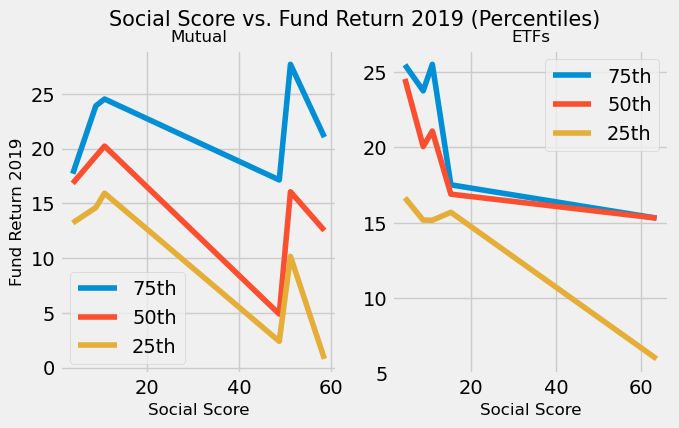

In [116]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['social_score', 'fund_return_2019'])
bins = np.arange(0, 60, 5)
indices = np.digitize(mf.social_score, bins)
groups = mf.groupby(indices)

eq = [group.social_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Social Score', size=12)
plt.ylabel('Fund Return 2019', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['social_score', 'fund_return_2019'])
bins = np.arange(0, 60, 5)
indices = np.digitize(etf.social_score, bins)
groups = etf.groupby(indices)

eq = [group.social_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Social Score', size=12)
plt.title('ETFs', size=12)

plt.suptitle('Social Score vs. Fund Return 2019 (Percentiles)', size=15)
plt.show()

Trimmed Outliers:

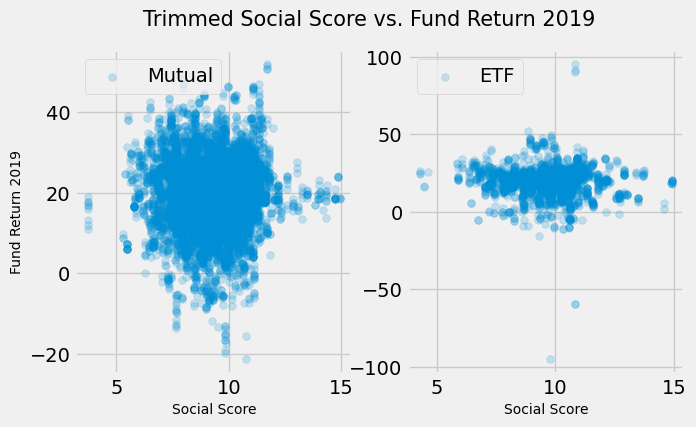

In [117]:
plt.figure(figsize=(7, 4))

mf = mf_equity.dropna(subset=['social_score', 'fund_return_2019'])
mf = mf.loc[mf.social_score <= 15] # Remove outliers
etf = etf_equity.dropna(subset=['social_score', 'fund_return_2019'])
etf = etf.loc[etf.social_score <= 15] # Remove outliers

plt.subplot(121)
plt.scatter(mf.social_score, mf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.xlabel('Social Score', size=10)
plt.ylabel('Fund Return 2019', size=10)
plt.legend(loc='upper left')

plt.subplot(122)
plt.scatter(etf.social_score, etf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.xlabel('Social Score', size=10)
plt.legend(loc='upper left')

plt.suptitle('Trimmed Social Score vs. Fund Return 2019', size=15)
plt.show()

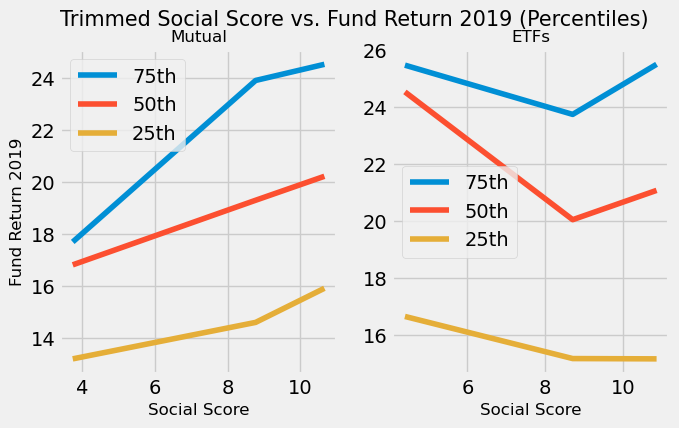

In [118]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['social_score', 'fund_return_2019'])
mf = mf.loc[mf.social_score <= 15] # Remove outliers
bins = np.arange(0, 60, 5)
indices = np.digitize(mf.social_score, bins)
groups = mf.groupby(indices)

eq = [group.social_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Social Score', size=12)
plt.ylabel('Fund Return 2019', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['social_score', 'fund_return_2019'])
etf = etf.loc[etf.social_score <= 15]
bins = np.arange(0, 60, 5)
indices = np.digitize(etf.social_score, bins)
groups = etf.groupby(indices)

eq = [group.social_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Social Score', size=12)
plt.title('ETFs', size=12)

plt.suptitle('Trimmed Social Score vs. Fund Return 2019 (Percentiles)', size=15)
plt.show()

Governance Score:

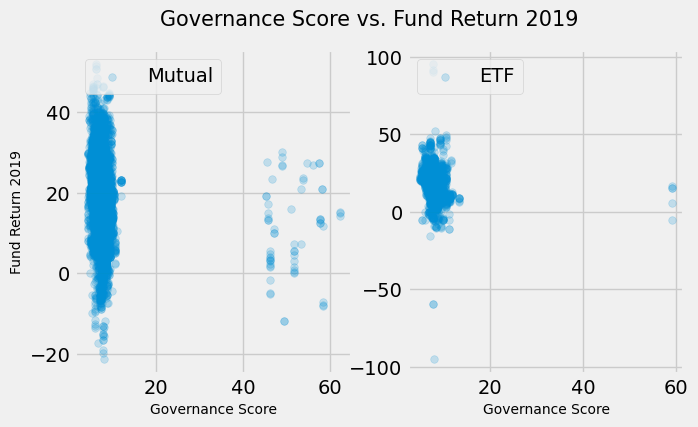

In [119]:
plt.figure(figsize=(7, 4))

mf = mf_equity.dropna(subset=['governance_score', 'fund_return_2019'])
etf = etf_equity.dropna(subset=['governance_score', 'fund_return_2019'])

plt.subplot(121)
plt.scatter(mf.governance_score, mf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.xlabel('Governance Score', size=10)
plt.ylabel('Fund Return 2019', size=10)
plt.legend(loc='upper left')

plt.subplot(122)
plt.scatter(etf.governance_score, etf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.xlabel('Governance Score', size=10)
plt.legend(loc='upper left')

plt.suptitle('Governance Score vs. Fund Return 2019', size=15)
plt.show()

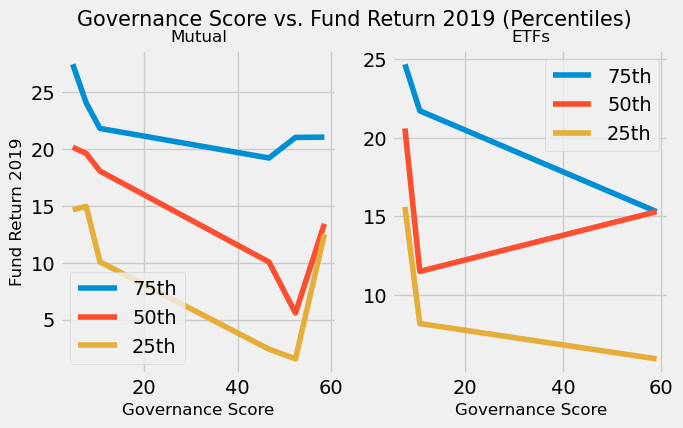

In [120]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['governance_score', 'fund_return_2019'])
bins = np.arange(0, 60, 5)
indices = np.digitize(mf.governance_score, bins)
groups = mf.groupby(indices)

eq = [group.governance_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Governance Score', size=12)
plt.ylabel('Fund Return 2019', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['governance_score', 'fund_return_2019'])
bins = np.arange(0, 60, 5)
indices = np.digitize(etf.governance_score, bins)
groups = etf.groupby(indices)

eq = [group.governance_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Governance Score', size=12)
plt.title('ETFs', size=12)

plt.suptitle('Governance Score vs. Fund Return 2019 (Percentiles)', size=15)
plt.show()

Trimmed Outliers:

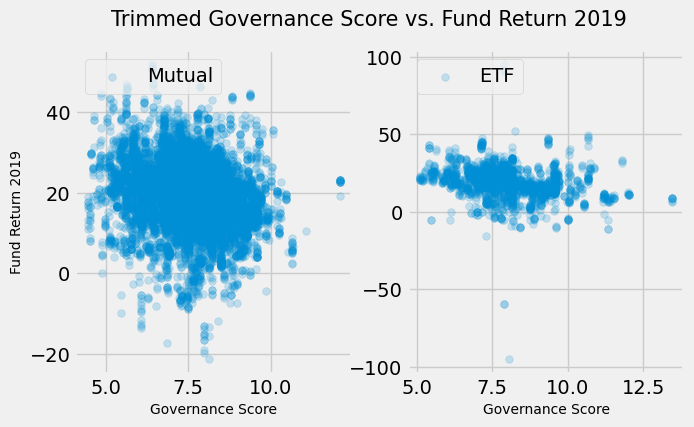

In [121]:
plt.figure(figsize=(7, 4))

mf = mf_equity.dropna(subset=['governance_score', 'fund_return_2019'])
mf = mf.loc[mf.governance_score <= 15] # Remove outliers
etf = etf_equity.dropna(subset=['governance_score', 'fund_return_2019'])
etf = etf.loc[etf.governance_score <= 15] # Remove outliers

plt.subplot(121)
plt.scatter(mf.governance_score, mf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.xlabel('Governance Score', size=10)
plt.ylabel('Fund Return 2019', size=10)
plt.legend(loc='upper left')

plt.subplot(122)
plt.scatter(etf.governance_score, etf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.xlabel('Governance Score', size=10)
plt.legend(loc='upper left')

plt.suptitle('Trimmed Governance Score vs. Fund Return 2019', size=15)
plt.show()

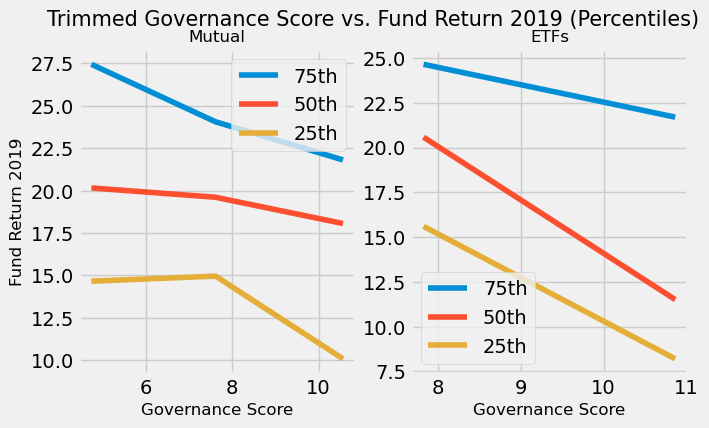

In [122]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['governance_score', 'fund_return_2019'])
mf = mf.loc[mf.governance_score <= 15] # Remove outliers
bins = np.arange(0, 60, 5)
indices = np.digitize(mf.governance_score, bins)
groups = mf.groupby(indices)

eq = [group.governance_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Governance Score', size=12)
plt.ylabel('Fund Return 2019', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['governance_score', 'fund_return_2019'])
etf = etf.loc[etf.governance_score <= 15] # Remove outliers
bins = np.arange(0, 60, 5)
indices = np.digitize(etf.governance_score, bins)
groups = etf.groupby(indices)

eq = [group.governance_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Governance Score', size=12)
plt.title('ETFs', size=12)

plt.suptitle('Trimmed Governance Score vs. Fund Return 2019 (Percentiles)', size=15)
plt.show()

Sustainability Score:

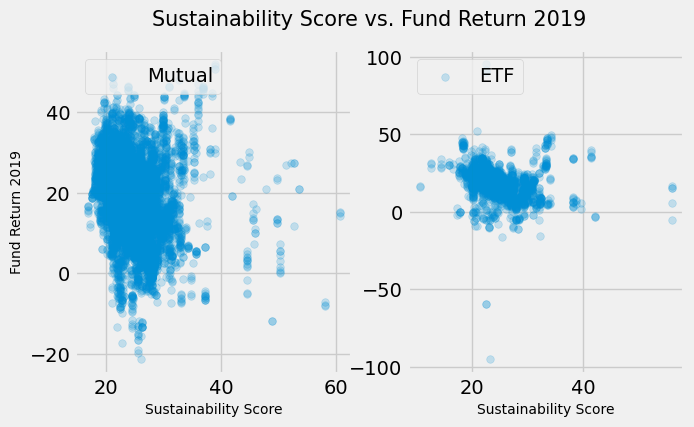

In [123]:
plt.figure(figsize=(7, 4))

mf = mf_equity.dropna(subset=['sustainability_score', 'fund_return_2019'])
etf = etf_equity.dropna(subset=['sustainability_score', 'fund_return_2019'])

plt.subplot(121)
plt.scatter(mf.sustainability_score, mf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.xlabel('Sustainability Score', size=10)
plt.ylabel('Fund Return 2019', size=10)
plt.legend(loc='upper left')

plt.subplot(122)
plt.scatter(etf.sustainability_score, etf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.xlabel('Sustainability Score', size=10)
plt.legend(loc='upper left')

plt.suptitle('Sustainability Score vs. Fund Return 2019', size=15)
plt.show()

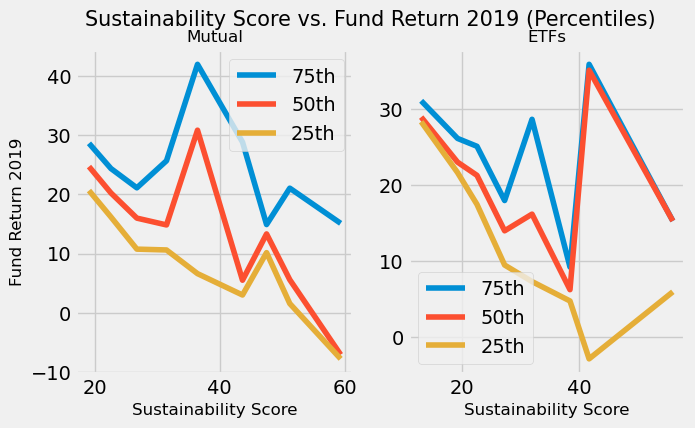

In [124]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['sustainability_score', 'fund_return_2019'])
bins = np.arange(0, 60, 5)
indices = np.digitize(mf.sustainability_score, bins)
groups = mf.groupby(indices)

eq = [group.sustainability_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Sustainability Score', size=12)
plt.ylabel('Fund Return 2019', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['sustainability_score', 'fund_return_2019'])
bins = np.arange(0, 60, 5)
indices = np.digitize(etf.sustainability_score, bins)
groups = etf.groupby(indices)

eq = [group.sustainability_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Sustainability Score', size=12)
plt.title('ETFs', size=12)

plt.suptitle('Sustainability Score vs. Fund Return 2019 (Percentiles)', size=15)
plt.show()

Trimmed Outliers:

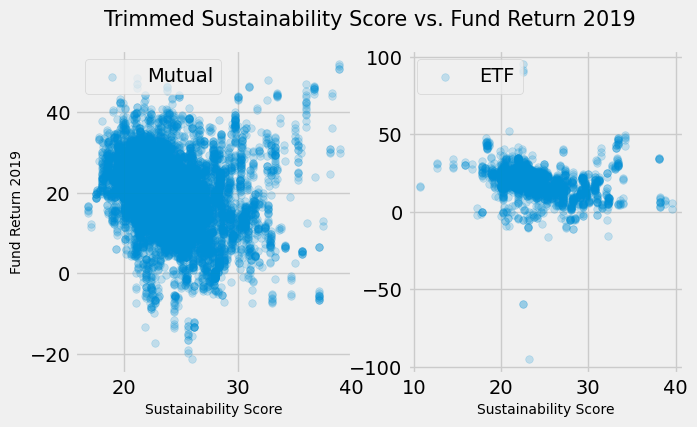

In [125]:
plt.figure(figsize=(7, 4))

mf = mf_equity.dropna(subset=['sustainability_score', 'fund_return_2019'])
mf = mf.loc[mf.sustainability_score <= 40] # Remove outliers
etf = etf_equity.dropna(subset=['sustainability_score', 'fund_return_2019'])
etf = etf.loc[etf.sustainability_score <= 40] # Remove outliers

plt.subplot(121)
plt.scatter(mf.sustainability_score, mf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.xlabel('Sustainability Score', size=10)
plt.ylabel('Fund Return 2019', size=10)
plt.legend(loc='upper left')

plt.subplot(122)
plt.scatter(etf.sustainability_score, etf.fund_return_2019, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.xlabel('Sustainability Score', size=10)
plt.legend(loc='upper left')

plt.suptitle('Trimmed Sustainability Score vs. Fund Return 2019', size=15)
plt.show()

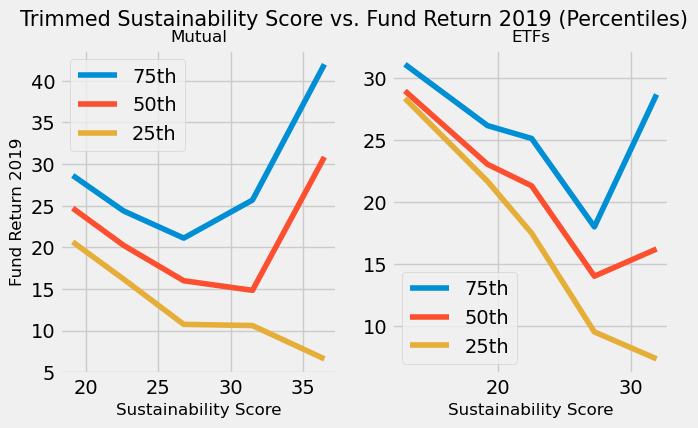

In [126]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['sustainability_score', 'fund_return_2019'])
mf = mf.loc[mf.sustainability_score <= 40] # Remove outliers
bins = np.arange(0, 60, 5)
indices = np.digitize(mf.sustainability_score, bins)
groups = mf.groupby(indices)

eq = [group.sustainability_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Sustainability Score', size=12)
plt.ylabel('Fund Return 2019', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['sustainability_score', 'fund_return_2019'])
etf = etf.loc[etf.sustainability_score <= 35] # Remove outliers
bins = np.arange(0, 60, 5)
indices = np.digitize(etf.sustainability_score, bins)
groups = etf.groupby(indices)

eq = [group.sustainability_score.mean() for i, group in groups]
cdfs = [Cdf(group.fund_return_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Sustainability Score', size=12)
plt.title('ETFs', size=12)

plt.suptitle('Trimmed Sustainability Score vs. Fund Return 2019 (Percentiles)', size=15)
plt.show()

Relationship between ESG and Average Returns for the Last 5 years:

In [127]:
annual_cols = ['fund_return_2019', 'fund_return_2018', 'fund_return_2017', 'fund_return_2016', 'fund_return_2015']
mf_equity['avg_fund_return_2015_2019'] = mf_equity[annual_cols].mean(axis=1)
etf_equity['avg_fund_return_2015_2019'] = etf_equity[annual_cols].mean(axis=1)


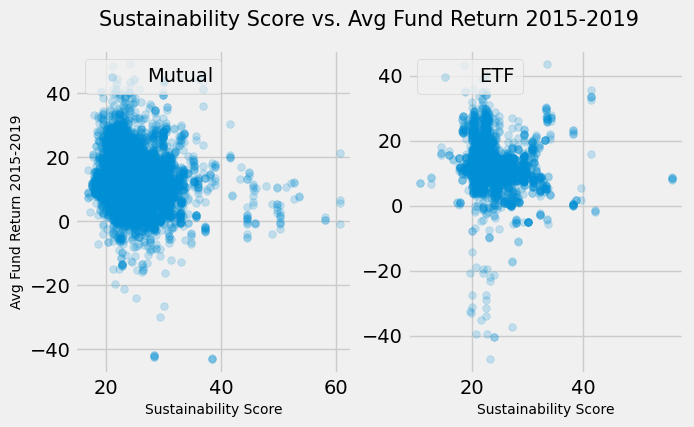

In [128]:
plt.figure(figsize=(7, 4))

mf = mf_equity.dropna(subset=['sustainability_score', 'avg_fund_return_2015_2019'])
etf = etf_equity.dropna(subset=['sustainability_score', 'avg_fund_return_2015_2019'])

plt.subplot(121)
plt.scatter(mf.sustainability_score, mf.avg_fund_return_2015_2019, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.xlabel('Sustainability Score', size=10)
plt.ylabel('Avg Fund Return 2015-2019', size=10)
plt.legend(loc='upper left')

plt.subplot(122)
plt.scatter(etf.sustainability_score, etf.avg_fund_return_2015_2019, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.xlabel('Sustainability Score', size=10)
plt.legend(loc='upper left')

plt.suptitle('Sustainability Score vs. Avg Fund Return 2015-2019', size=15)
plt.show()

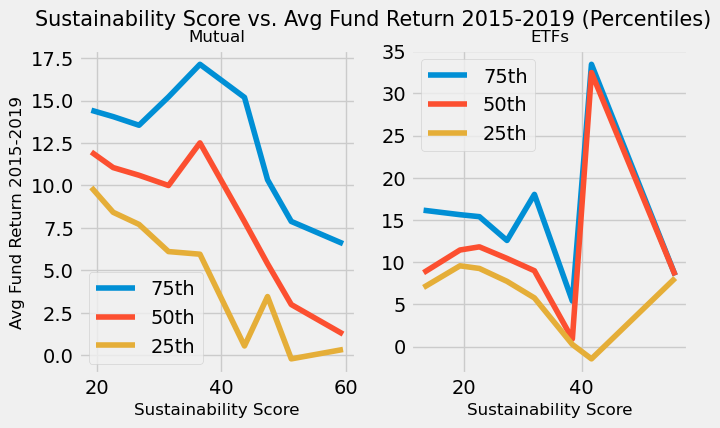

In [129]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['sustainability_score', 'avg_fund_return_2015_2019'])
bins = np.arange(0, 60, 5)
indices = np.digitize(mf.sustainability_score, bins)
groups = mf.groupby(indices)

eq = [group.sustainability_score.mean() for i, group in groups]
cdfs = [Cdf(group.avg_fund_return_2015_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Sustainability Score', size=12)
plt.ylabel('Avg Fund Return 2015-2019', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['sustainability_score', 'avg_fund_return_2015_2019'])
bins = np.arange(0, 60, 5)
indices = np.digitize(etf.sustainability_score, bins)
groups = etf.groupby(indices)

eq = [group.sustainability_score.mean() for i, group in groups]
cdfs = [Cdf(group.avg_fund_return_2015_2019) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Sustainability Score', size=12)
plt.title('ETFs', size=12)

plt.suptitle('Sustainability Score vs. Avg Fund Return 2015-2019 (Percentiles)', size=15)
plt.show()

**Quarterly Fund Performance: 2015 - 2020**

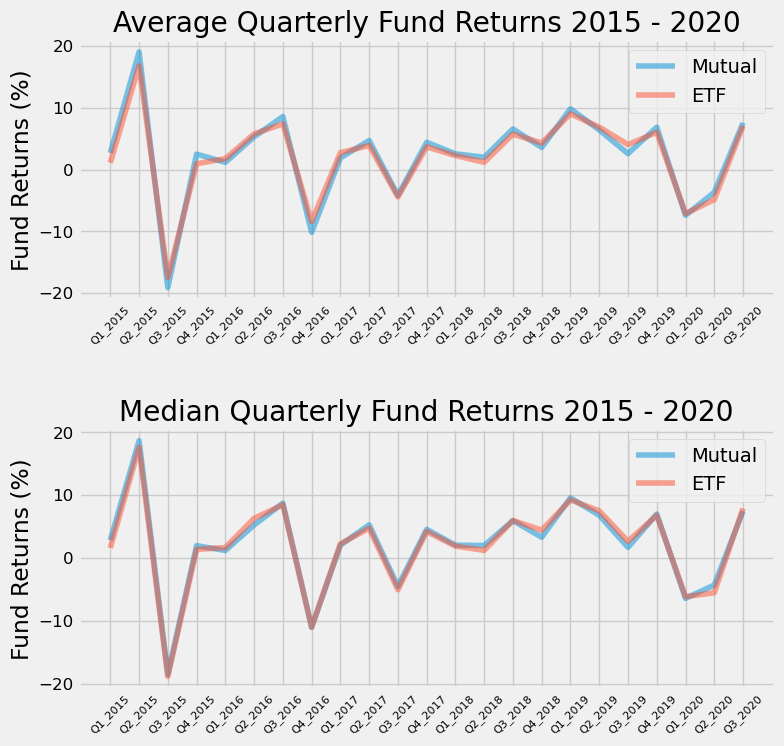

In [130]:
categories = ['Q1_2015', 'Q2_2015', 'Q3_2015', 'Q4_2015', 
              'Q1_2016', 'Q2_2016', 'Q3_2016', 'Q4_2016',
              'Q1_2017', 'Q2_2017', 'Q3_2017', 'Q4_2017',
              'Q1_2018', 'Q2_2018', 'Q3_2018', 'Q4_2018',
              'Q1_2019', 'Q2_2019', 'Q3_2019', 'Q4_2019',
              'Q1_2020', 'Q2_2020', 'Q3_2020']

plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=.5)

plt.subplot(211)
quarter_cols = [i for i in mf_equity.columns if '_q' in i]
mf_fund_average_quarters = mf_equity[quarter_cols].dropna().mean(axis=0)
etf_fund_average_quarters = etf_equity[quarter_cols].dropna().mean(axis=0)

plt.plot(categories, mf_fund_average_quarters, alpha=.5, label='Mutual')
plt.plot(categories, etf_fund_average_quarters, alpha=.5, label='ETF')
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=12)
plt.ylabel('Fund Returns (%)')
plt.legend()
plt.title('Average Quarterly Fund Returns 2015 - 2020')

plt.subplot(212)
quarter_cols = [i for i in mf_equity.columns if '_q' in i]
mf_fund_median_quarters = mf_equity[quarter_cols].dropna().median(axis=0)
etf_fund_median_quarters = etf_equity[quarter_cols].dropna().median(axis=0)

plt.plot(categories, mf_fund_median_quarters, alpha=.5, label='Mutual')
plt.plot(categories, etf_fund_median_quarters, alpha=.5, label='ETF')
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=12)
plt.ylabel('Fund Returns (%)')
plt.legend()
plt.title('\nMedian Quarterly Fund Returns 2015 - 2020')


plt.show()

**Annual Fund Performance: 2015 - 2019**

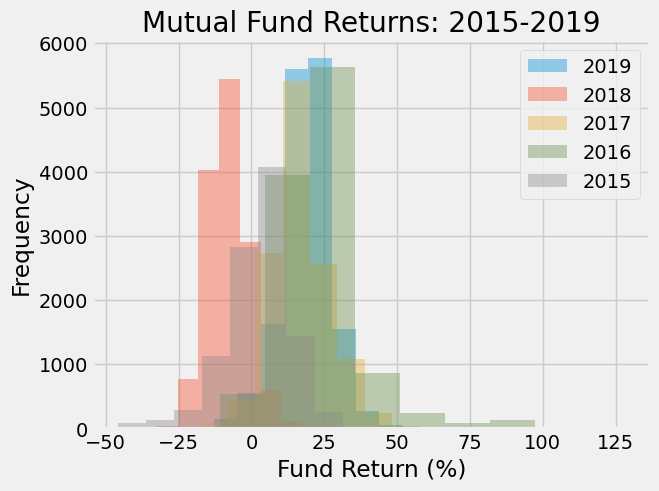

In [131]:
annual_cols = ['fund_return_2019', 'fund_return_2018', 'fund_return_2017', 'fund_return_2016', 'fund_return_2015']
plt.hist(mf_equity[annual_cols[0]], label='2019', alpha=.4)
plt.hist(mf_equity[annual_cols[1]], label='2018', alpha=.4)
plt.hist(mf_equity[annual_cols[2]], label='2017', alpha=.4)
plt.hist(mf_equity[annual_cols[3]], label='2016', alpha=.4)
plt.hist(mf_equity[annual_cols[4]], label='2015', alpha=.4)
plt.xlabel('Fund Return (%)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Mutual Fund Returns: 2015-2019')
plt.show()

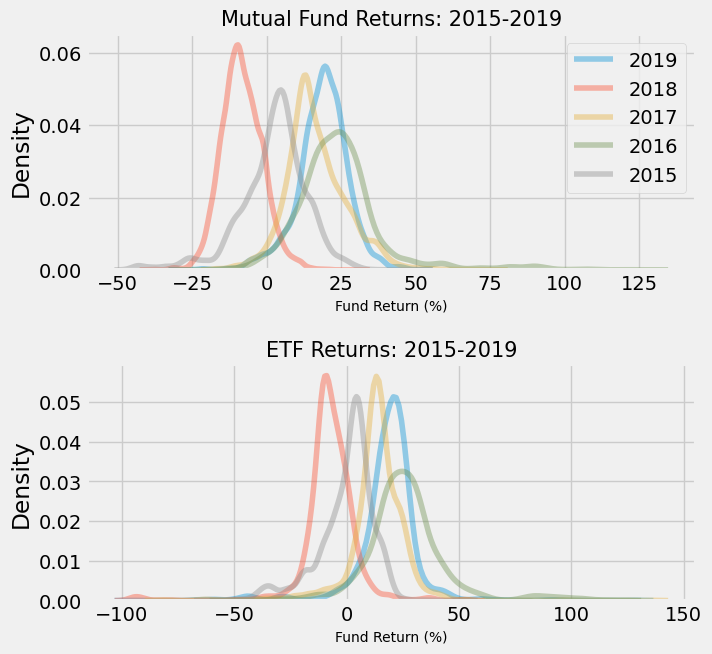

In [132]:
plt.figure(figsize=(7, 7))
plt.subplots_adjust(hspace=.4, wspace=.4)

plt.subplot(211)
sns.kdeplot(data=mf_equity, x=annual_cols[0], label='2019', alpha=.4)
sns.kdeplot(data=mf_equity, x=annual_cols[1], label='2018', alpha=.4)
sns.kdeplot(data=mf_equity, x=annual_cols[2], label='2017', alpha=.4)
sns.kdeplot(data=mf_equity, x=annual_cols[3], label='2016', alpha=.4)
sns.kdeplot(data=mf_equity, x=annual_cols[4], label='2015', alpha=.4)
plt.xlabel('Fund Return (%)', fontsize=10)
plt.legend()
plt.title('Mutual Fund Returns: 2015-2019', fontsize=15)

plt.subplot(212)
sns.kdeplot(data=etf_equity, x=annual_cols[0], label='2019', alpha=.4)
sns.kdeplot(data=etf_equity, x=annual_cols[1], label='2018', alpha=.4)
sns.kdeplot(data=etf_equity, x=annual_cols[2], label='2017', alpha=.4)
sns.kdeplot(data=etf_equity, x=annual_cols[3], label='2016', alpha=.4)
sns.kdeplot(data=etf_equity, x=annual_cols[4], label='2015', alpha=.4)
plt.xlabel('Fund Return (%)', fontsize=10)
# plt.legend()
plt.title('ETF Returns: 2015-2019', fontsize=15)

plt.show()

**Price Ratio Interactions**

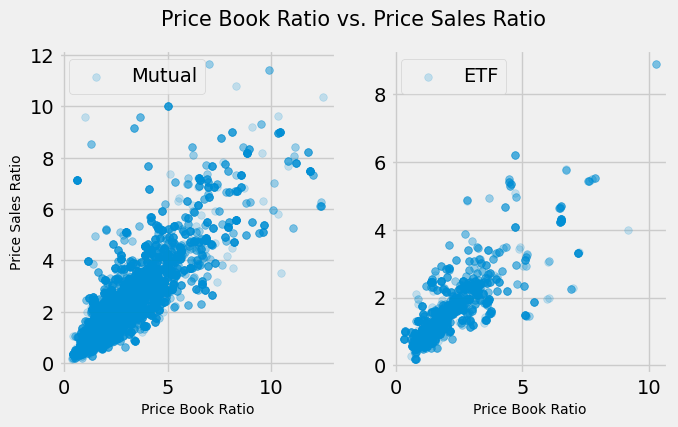

In [133]:
plt.figure(figsize=(7, 4))

mf = mf_equity.dropna(subset=['price_book_ratio', 'price_sales_ratio'])
etf = etf_equity.dropna(subset=['price_book_ratio', 'price_sales_ratio'])

plt.subplot(121)
plt.scatter(mf.price_book_ratio, mf.price_sales_ratio, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.xlabel('Price Book Ratio', size=10)
plt.ylabel('Price Sales Ratio', size=10)
plt.legend(loc='upper left')

plt.subplot(122)
plt.scatter(etf.price_book_ratio, etf.price_sales_ratio, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.xlabel('Price Book Ratio', size=10)
plt.legend(loc='upper left')

plt.suptitle('Price Book Ratio vs. Price Sales Ratio', size=15)
plt.show()

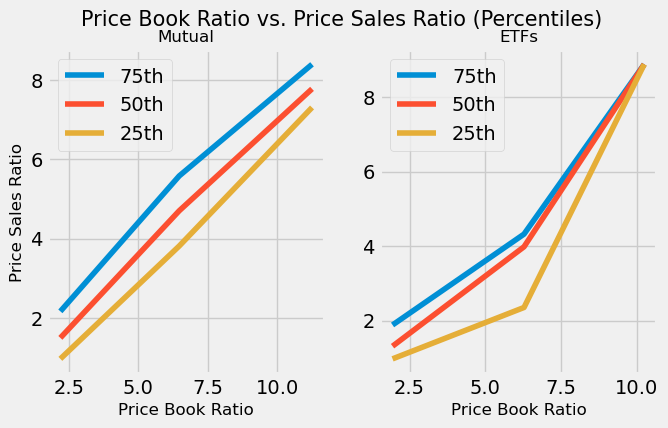

In [134]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
mf = mf_equity.dropna(subset=['price_book_ratio', 'price_sales_ratio'])
bins = np.arange(0, 60, 5)
indices = np.digitize(mf.price_book_ratio, bins)
groups = mf.groupby(indices)

eq = [group.price_book_ratio.mean() for i, group in groups]
cdfs = [Cdf(group.price_sales_ratio) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Price Book Ratio', size=12)
plt.ylabel('Price Sales Ratio', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
etf = etf_equity.dropna(subset=['price_book_ratio', 'price_sales_ratio'])
bins = np.arange(0, 60, 5)
indices = np.digitize(etf.price_book_ratio, bins)
groups = etf.groupby(indices)

eq = [group.price_book_ratio.mean() for i, group in groups]
cdfs = [Cdf(group.price_sales_ratio) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Price Book Ratio', size=12)
plt.title('ETFs', size=12)

plt.suptitle('Price Book Ratio vs. Price Sales Ratio (Percentiles)', size=15)
plt.show()

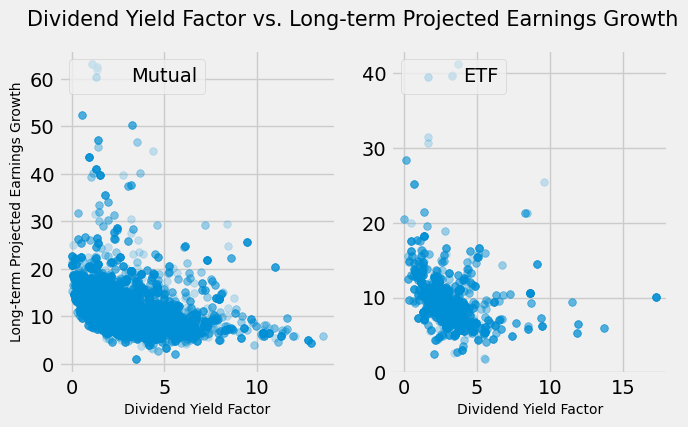

In [135]:
plt.figure(figsize=(7, 4))

mf = mf_equity.dropna(subset=['dividend_yield_factor', 'long_term_projected_earnings_growth'])
etf = etf_equity.dropna(subset=['dividend_yield_factor', 'long_term_projected_earnings_growth'])

plt.subplot(121)
plt.scatter(mf.dividend_yield_factor, mf.long_term_projected_earnings_growth, s=30, edgecolors=None, alpha=.2, label='Mutual')
plt.xlabel('Dividend Yield Factor', size=10)
plt.ylabel('Long-term Projected Earnings Growth', size=10)
plt.legend(loc='upper left')

plt.subplot(122)
plt.scatter(etf.dividend_yield_factor, etf.long_term_projected_earnings_growth, s=30, edgecolors=None, alpha=.2, label='ETF')
plt.xlabel('Dividend Yield Factor', size=10)
plt.legend(loc='upper left')

plt.suptitle('Dividend Yield Factor vs. Long-term Projected Earnings Growth', size=15)
plt.show()

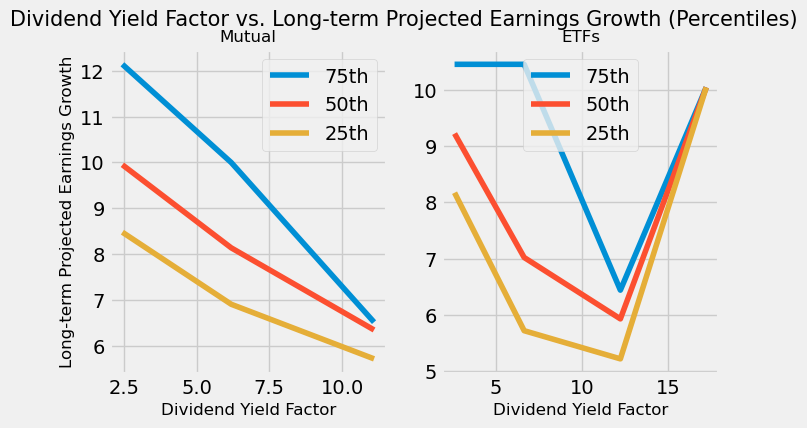

In [136]:
mf = mf_equity.dropna(subset=['dividend_yield_factor', 'long_term_projected_earnings_growth'])
etf = etf_equity.dropna(subset=['dividend_yield_factor', 'long_term_projected_earnings_growth'])

plt.figure(figsize=(7, 4))

plt.subplot(121)
bins = np.arange(0, 60, 5)
indices = np.digitize(mf.dividend_yield_factor, bins)
groups = mf.groupby(indices)

eq = [group.dividend_yield_factor.mean() for i, group in groups]
cdfs = [Cdf(group.long_term_projected_earnings_growth) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Dividend Yield Factor', size=12)
plt.ylabel('Long-term Projected Earnings Growth', size=12)
plt.title('Mutual', size=12)

plt.subplot(122)
bins = np.arange(0, 60, 5)
indices = np.digitize(etf.dividend_yield_factor, bins)
groups = etf.groupby(indices)

eq = [group.dividend_yield_factor.mean() for i, group in groups]
cdfs = [Cdf(group.long_term_projected_earnings_growth) for i, group in groups]

for percent in [75, 50, 25]:
    ftr = [Percentile(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(eq, ftr, label=label)

plt.legend()
plt.xlabel('Dividend Yield Factor', size=12)
plt.title('ETFs', size=12)

plt.suptitle('Dividend Yield Factor vs. Long-term Projected Earnings Growth (Percentiles)', size=15)
plt.show()

**Multivariate Relationships**

Equity Size, Price Cash Flow, Dividend Yield Factor

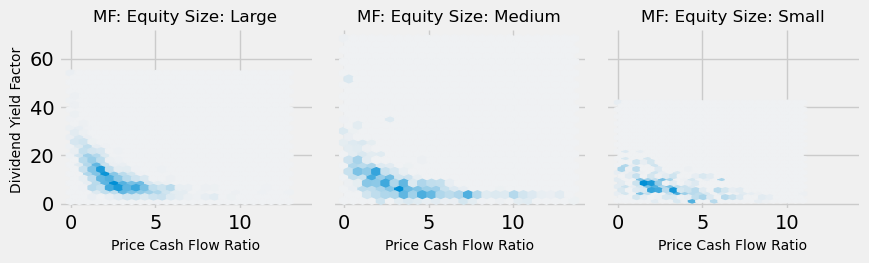

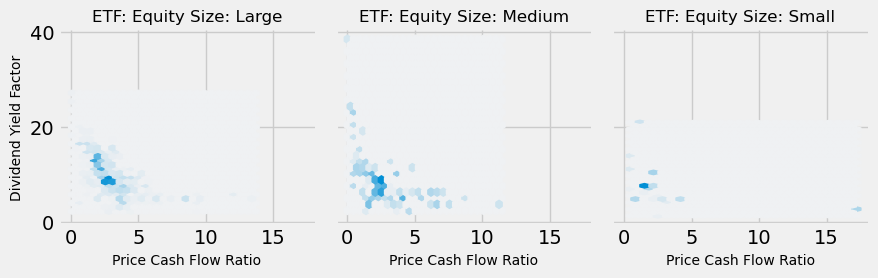

In [137]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(mf_equity, col='equity_size')
g.map(hexbin, 'dividend_yield_factor', 'price_cash_flow_ratio')
g.set_axis_labels('Price Cash Flow Ratio', 'Dividend Yield Factor', fontsize=10)
g.set_titles('MF: Equity Size: {col_name}', size=12);

h = sns.FacetGrid(etf_equity, col='equity_size')
h.map(hexbin, 'dividend_yield_factor', 'price_cash_flow_ratio')
h.set_axis_labels('Price Cash Flow Ratio', 'Dividend Yield Factor', fontsize=10)
h.set_titles('ETF: Equity Size: {col_name}', size=12)

plt.tight_layout()
plt.show()

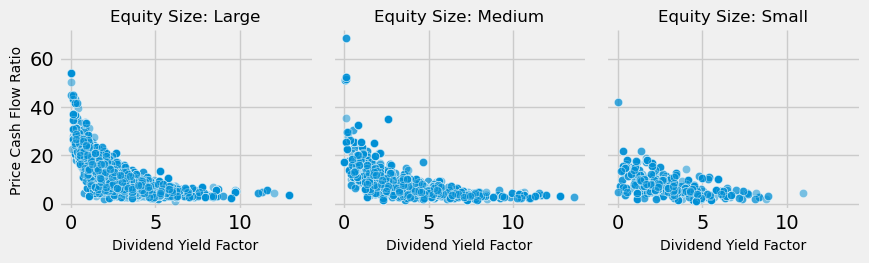

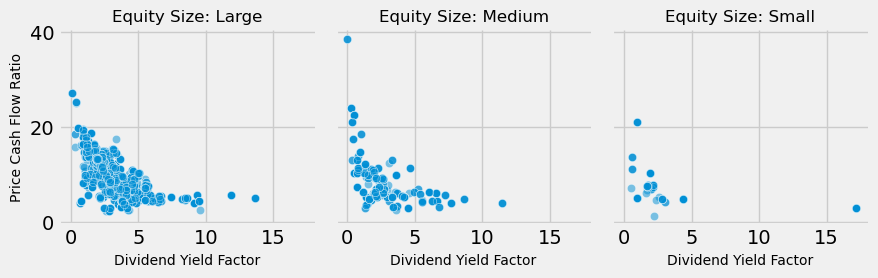

In [138]:
g = sns.FacetGrid(mf_equity, col='equity_size')
g.map(sns.scatterplot, 'dividend_yield_factor', 'price_cash_flow_ratio', alpha=.5)
g.set_axis_labels('Dividend Yield Factor', 'Price Cash Flow Ratio', fontsize=10)
g.set_titles('Equity Size: {col_name}', size=12)

h = sns.FacetGrid(etf_equity, col='equity_size')
h.map(sns.scatterplot, 'dividend_yield_factor', 'price_cash_flow_ratio', alpha=.5)
h.set_axis_labels('Dividend Yield Factor', 'Price Cash Flow Ratio', fontsize=10)
h.set_titles('Equity Size: {col_name}', size=12)

# plt.suptitle('Mutual Funds: Dividend Yield Factor vs Price Cash Flow Ratio by Equity Size')
plt.tight_layout()
plt.show()

**Relationship between Sectors and Fund Returns**

Sector vs Avg 5-Year Returns:

Sector columns have negative values which makes no sense. A fund can't be negatively invested in a sector. We'll filter those negative columns out:

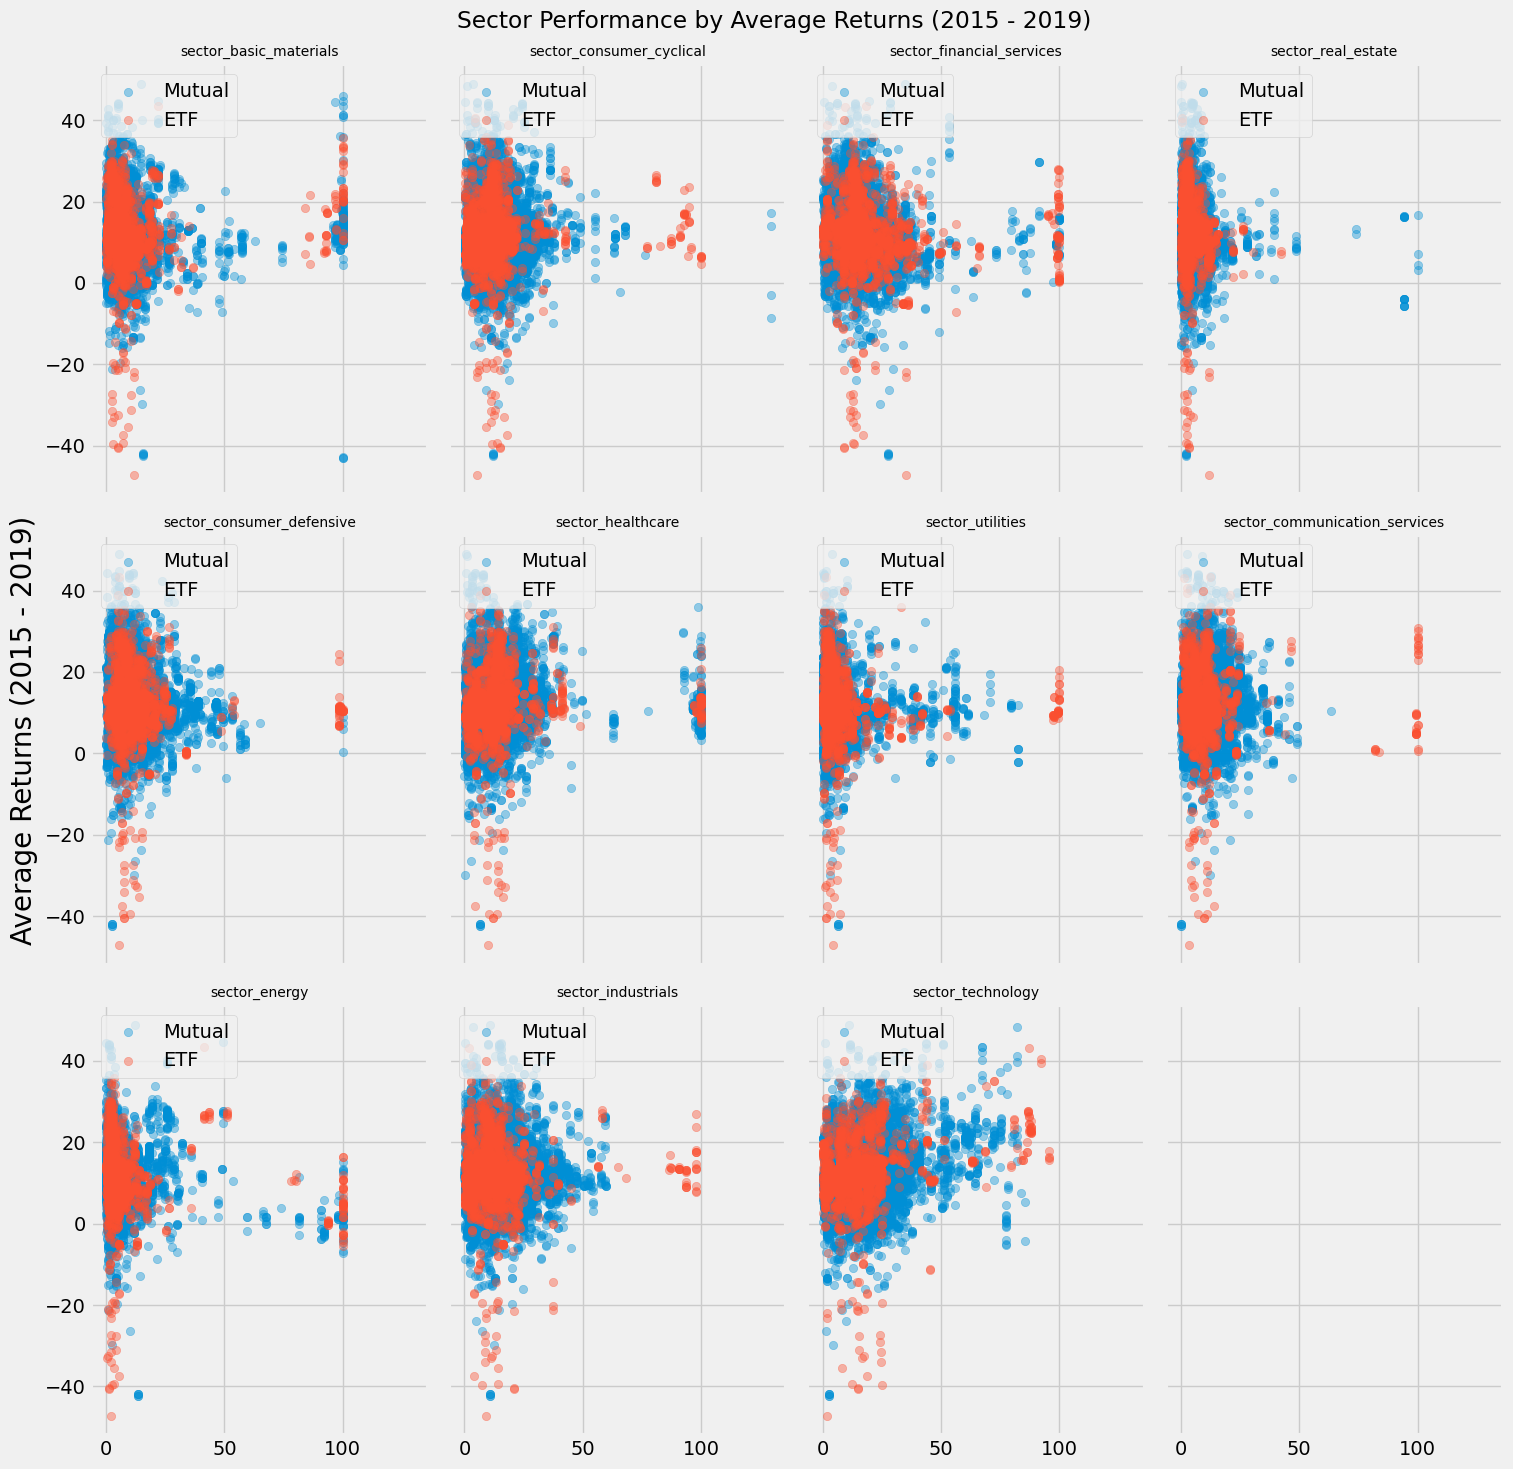

In [139]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.4, hspace=.6)
for sector, ax in zip(sector_cols, axes.ravel()):
    ax.scatter(mf_equity.loc[mf_equity[sector] >= 0, sector], mf_equity.loc[mf_equity[sector] >=0, 'avg_fund_return_2015_2019'], 
               alpha=.4, label='Mutual')
    ax.scatter(etf_equity.loc[etf_equity[sector] >= 0, sector], etf_equity.loc[etf_equity[sector] >=0, 'avg_fund_return_2015_2019'], 
               alpha=.4, label='ETF')
    ax.set_title(sector, size=10)
    ax.legend(loc='upper left')


# Set common labels
fig.text(0, 0.5, 'Average Returns (2015 - 2019)', ha='center', va='center', rotation='vertical', size=20)

plt.suptitle('Sector Performance by Average Returns (2015 - 2019)')
plt.tight_layout()
plt.show()

Sector Distribution:

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/360388154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'source'] = 'Mutual Funds'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/360388154.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'source'] = 'ETFs'


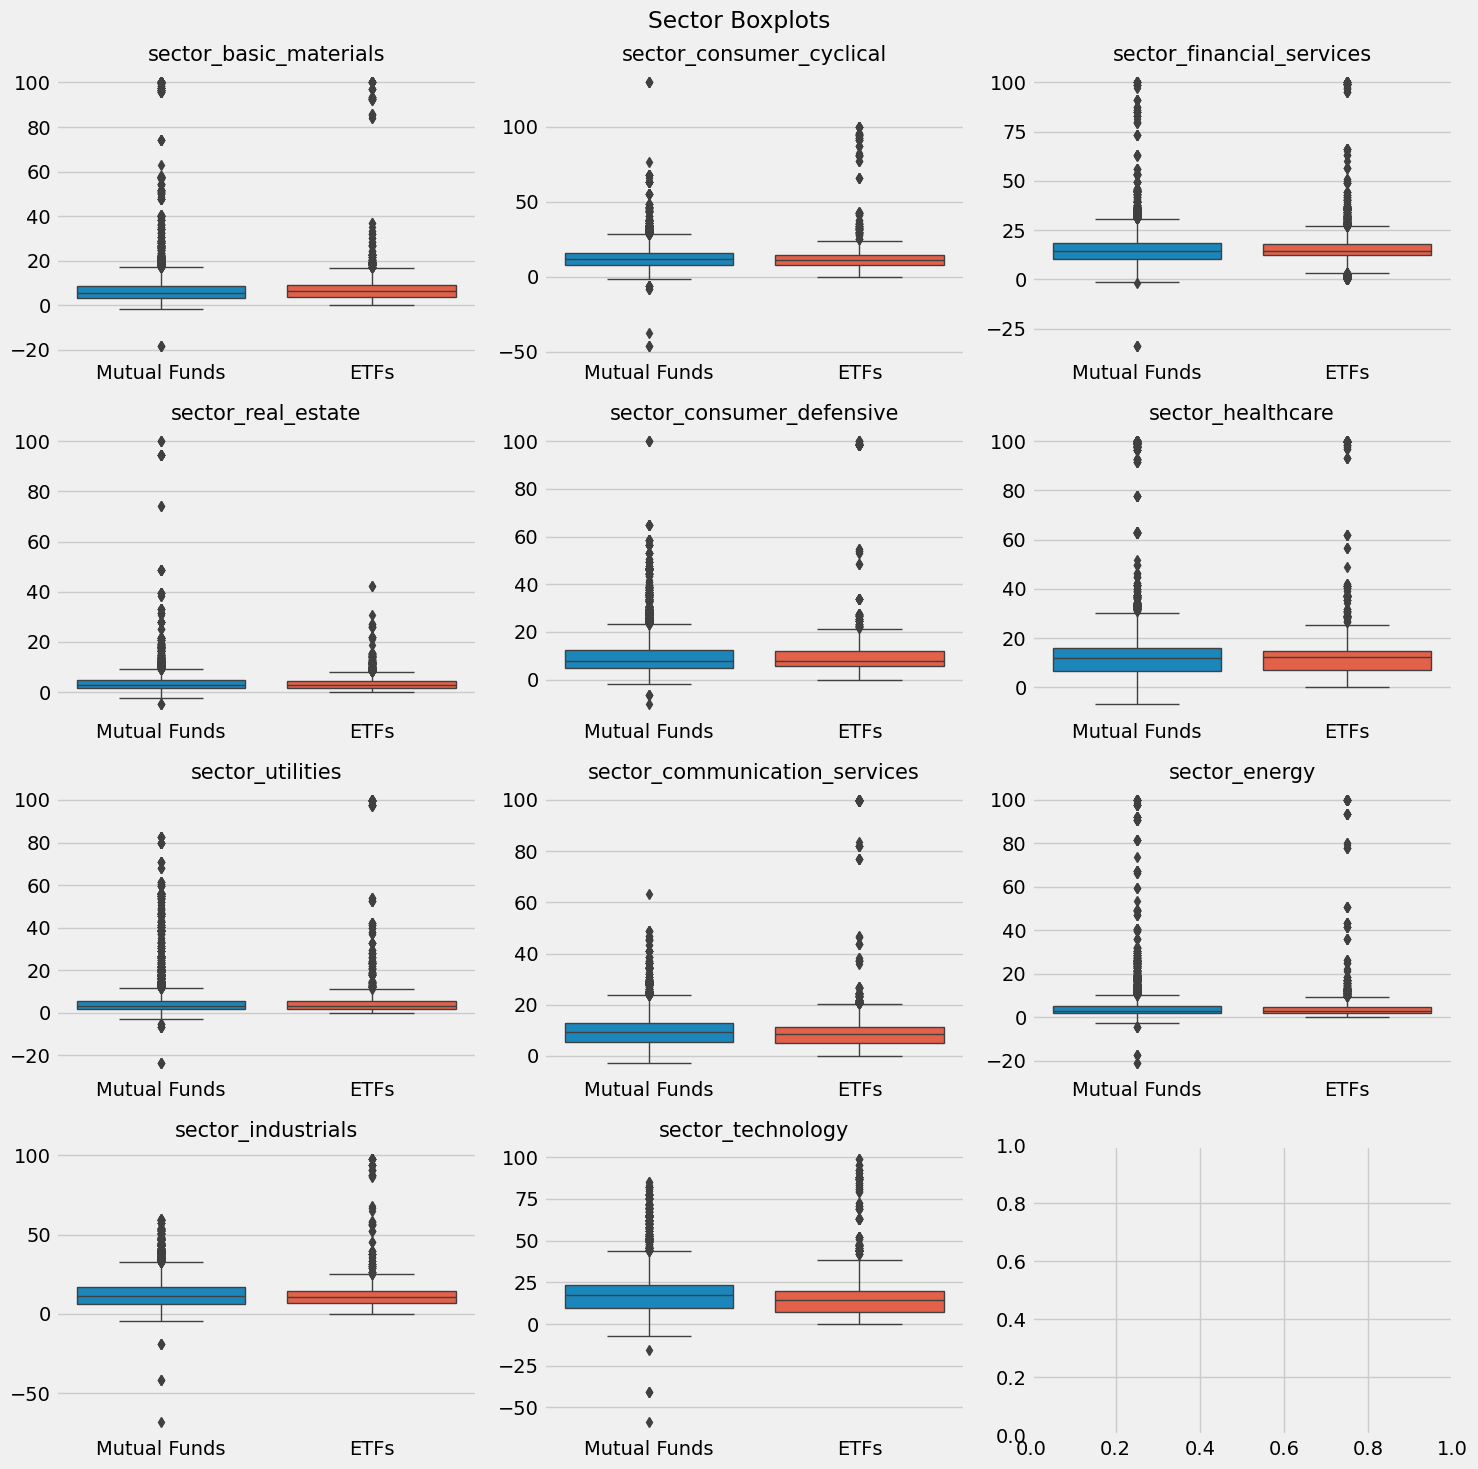

In [140]:
df1 = mf_equity[sector_cols]
df2 = etf_equity[sector_cols]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'
combined_df = pd.concat([df1, df2], ignore_index=True)
labels = ['Mutual', 'ETF']

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
plt.subplots_adjust(wspace=.6, hspace=.6)

for sector, ax in zip(sector_cols, axes.ravel()):
    sns.boxplot(data=combined_df, x='source', y=sector, linewidth=1, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(sector, size=15)

plt.suptitle('Sector Boxplots')
plt.tight_layout()
plt.show() 

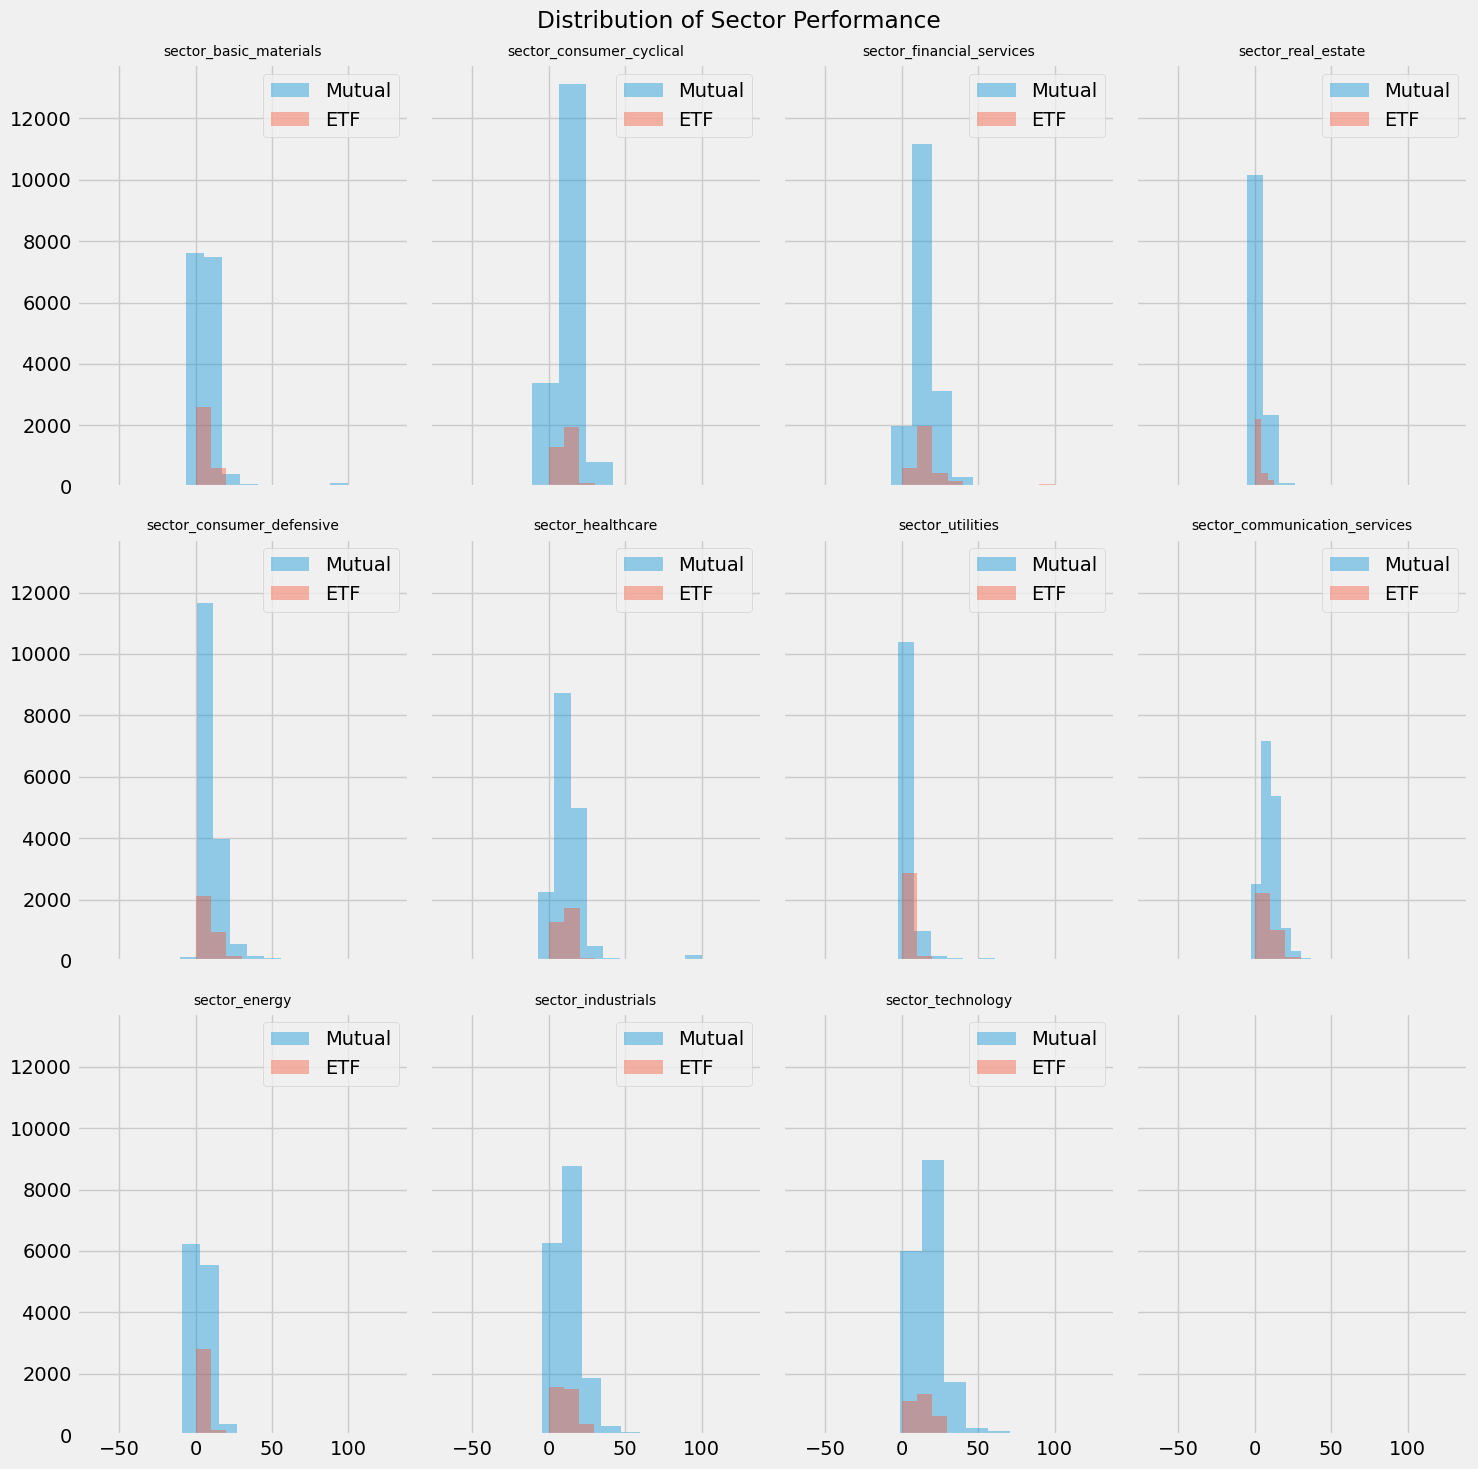

In [141]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.4, hspace=.4)
for sector, ax in zip(sector_cols, axes.ravel()):
    ax.hist(mf_equity[sector], alpha=.4, label='Mutual')
    ax.hist(etf_equity[sector], alpha=.4, label='ETF')
    ax.set_title(sector, size=10)
    ax.legend()

plt.suptitle('Distribution of Sector Performance')
plt.tight_layout()
plt.show()

**Relationship between Investment and Fund Returns**

Investment vs Avg 5-Year Returns:

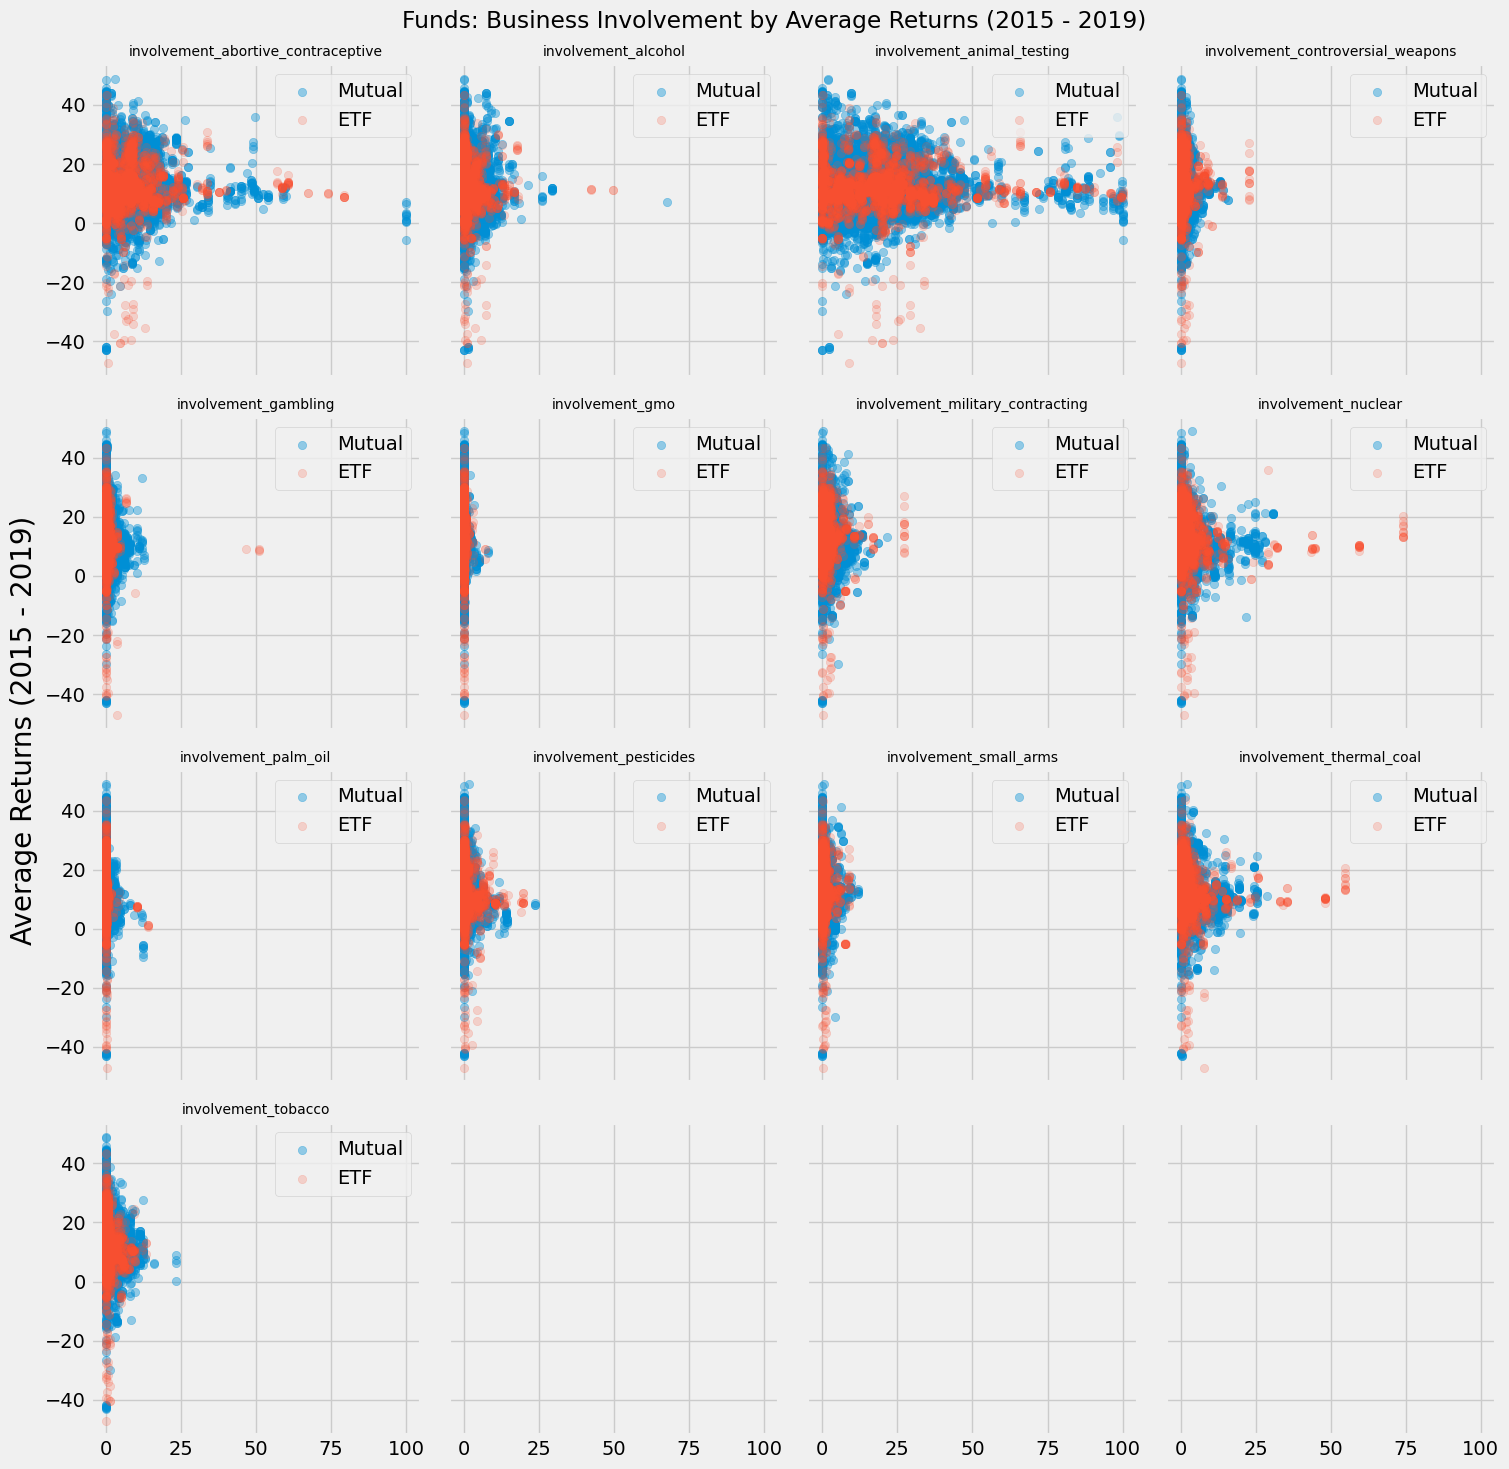

In [142]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.4, hspace=.4)
for invest, ax in zip(invest_cols, axes.ravel()):
    ax.scatter(mf_equity[invest], mf_equity.avg_fund_return_2015_2019, 
               alpha=.4, label='Mutual')
    ax.scatter(etf_equity[invest], etf_equity.avg_fund_return_2015_2019, 
               alpha=.2, label='ETF')
    ax.set_title(invest, size=10)
    ax.legend(loc='upper right')

# Set common labels
fig.text(0, 0.5, 'Average Returns (2015 - 2019)', ha='center', va='center', rotation='vertical', size=20)

plt.suptitle('Funds: Business Involvement by Average Returns (2015 - 2019)')
plt.tight_layout()
plt.show()

Distribution of investment features (Linear):

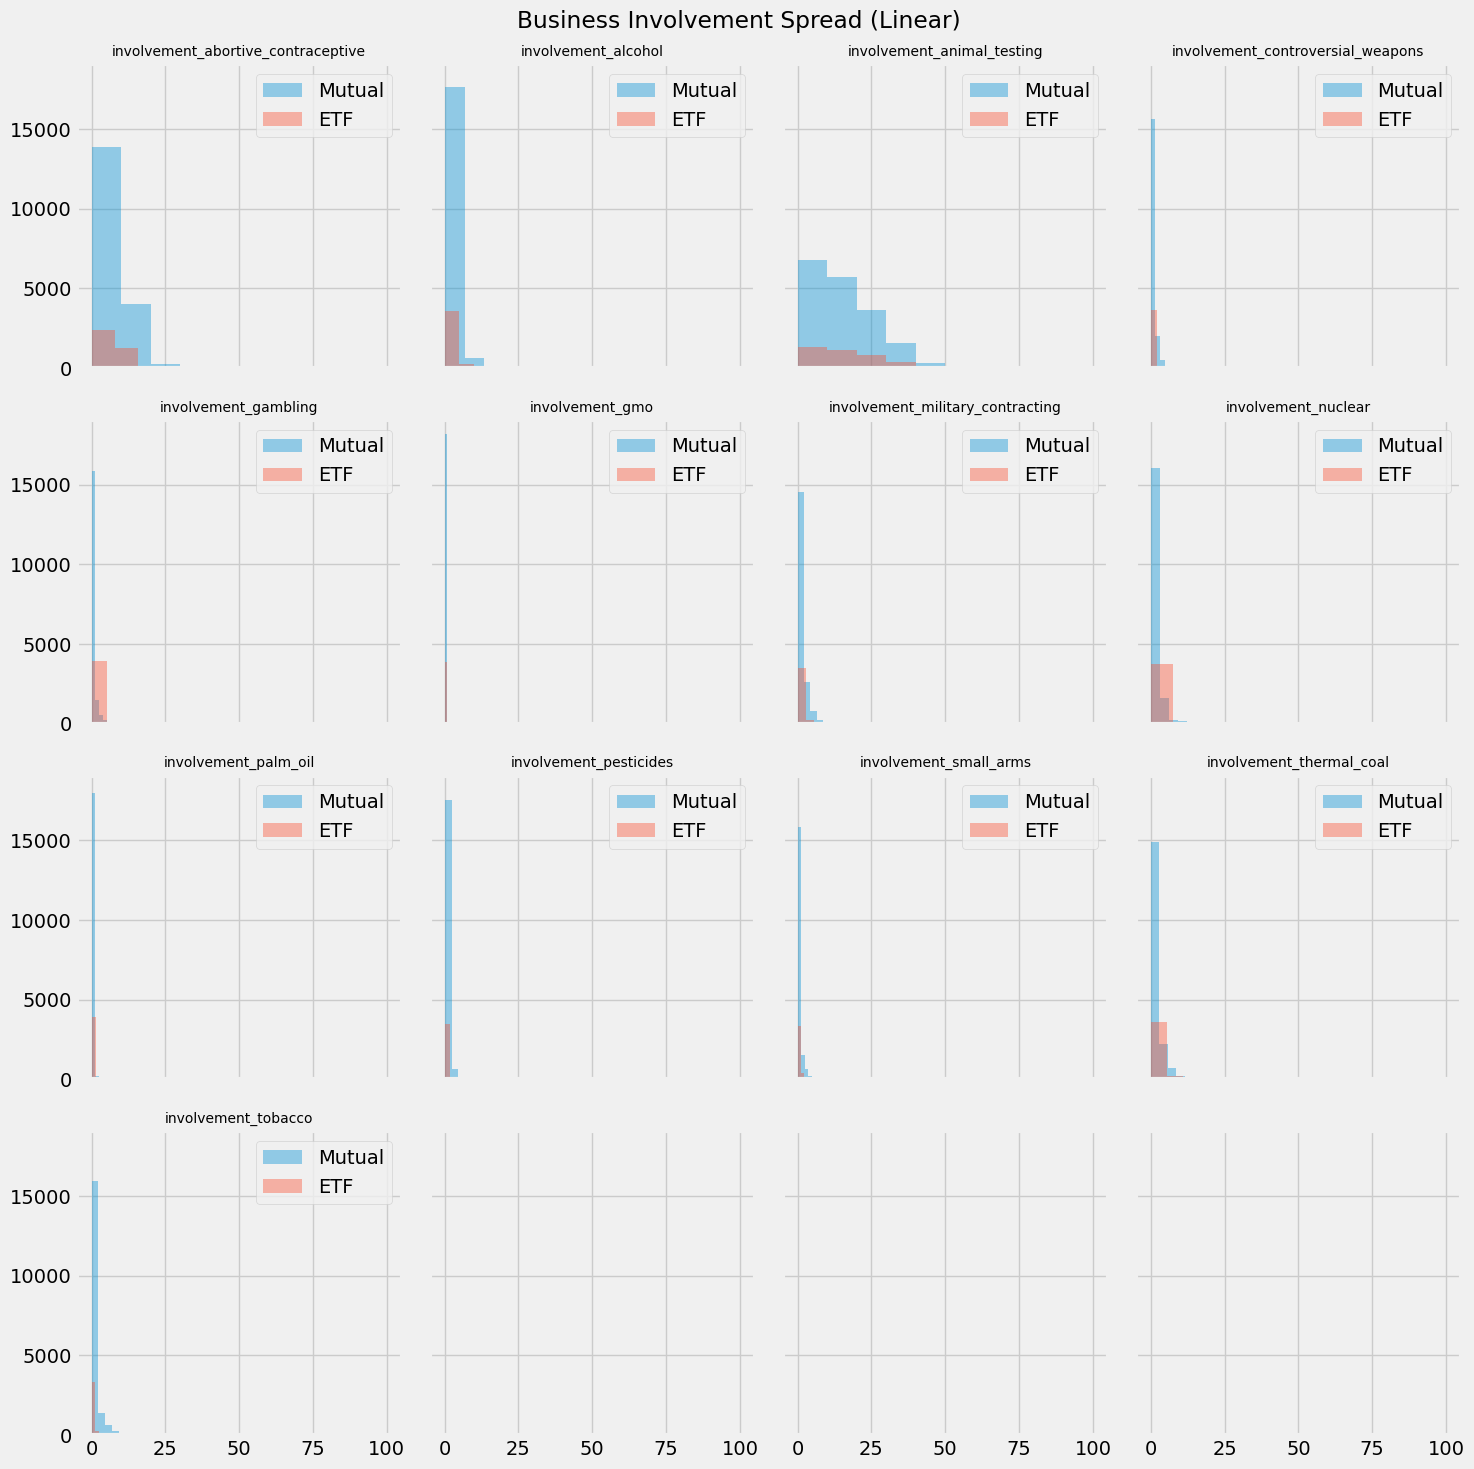

In [143]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.4, hspace=.4)
for invest, ax in zip(invest_cols, axes.ravel()):
    ax.hist(mf_equity[invest], alpha=.4, label='Mutual')
    ax.hist(etf_equity[invest], alpha=.4, label='ETF')
    ax.set_title(invest, size=10)
    ax.legend()

plt.suptitle('Business Involvement Spread (Linear)')
plt.tight_layout()
plt.show()

Distribution of investment features (Log):

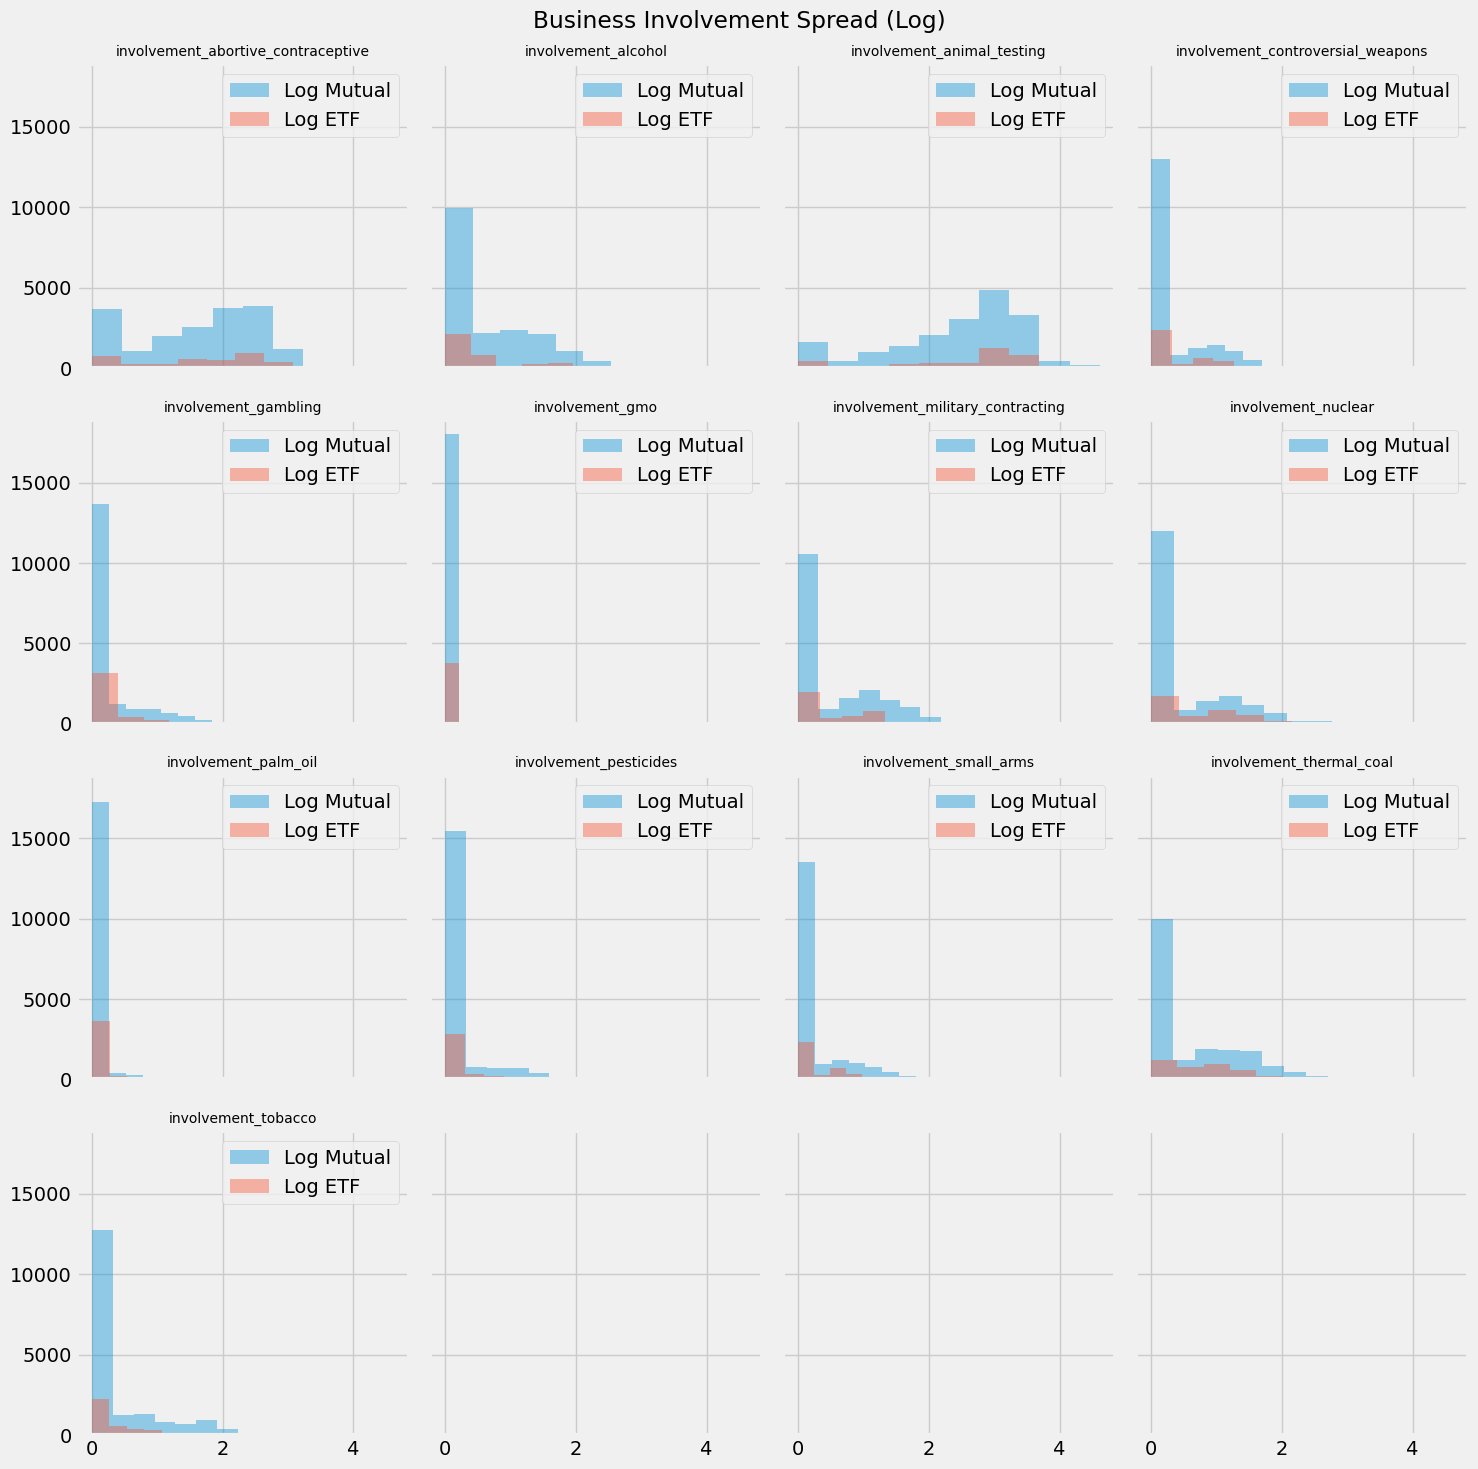

In [144]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.4, hspace=.4)
for invest, ax in zip(invest_cols, axes.ravel()):
    ax.hist(np.log(mf_equity[invest] + 1), alpha=.4, label='Log Mutual')
    ax.hist(np.log(etf_equity[invest] + 1), alpha=.4, label='Log ETF')
    ax.set_title(invest, size=10)
    ax.legend()

plt.suptitle('Business Involvement Spread (Log)')
plt.tight_layout()
plt.show()

Boxplot the above:

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/3224089992.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'source'] = 'Mutual Funds'
/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_15698/3224089992.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'source'] = 'ETFs'


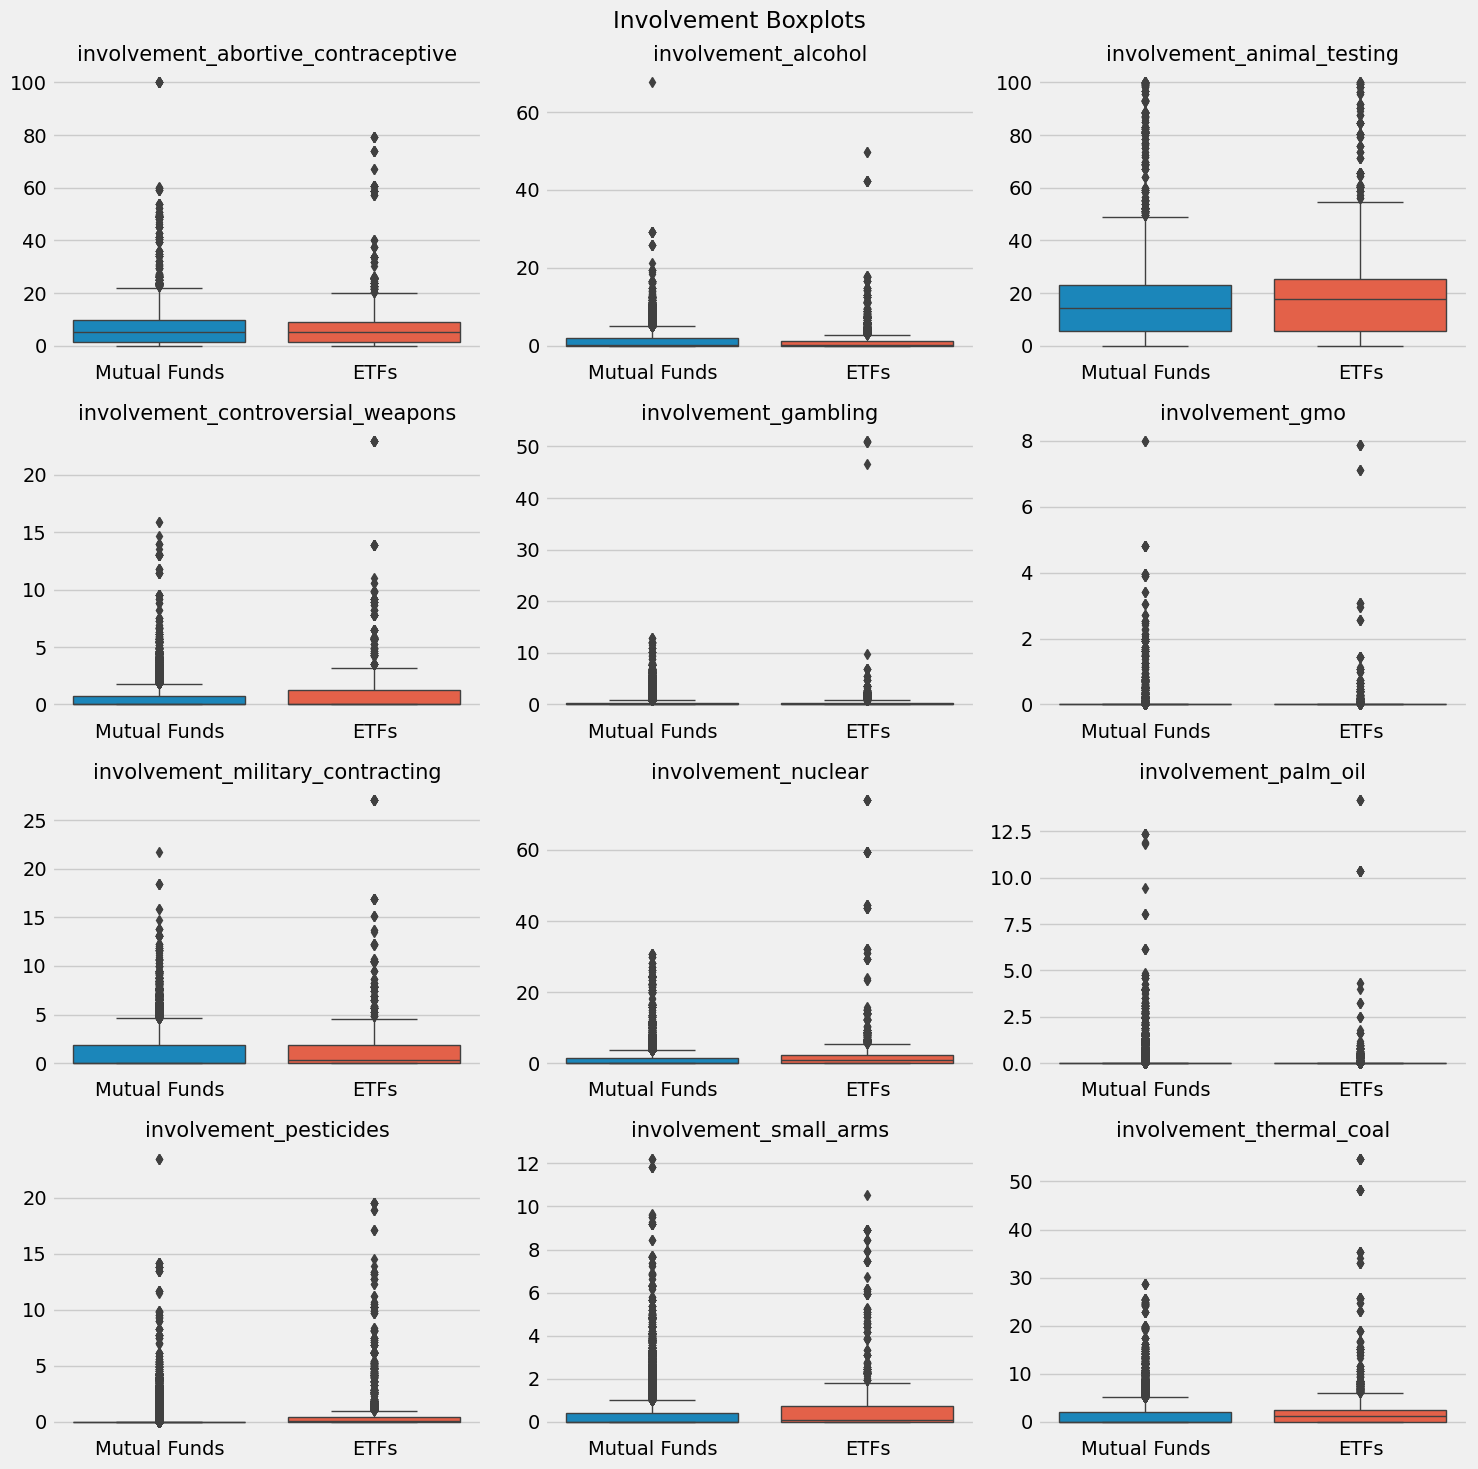

In [145]:
df1 = mf_equity[invest_cols]
df2 = etf_equity[invest_cols]
df1.loc[:, 'source'] = 'Mutual Funds'
df2.loc[:, 'source'] = 'ETFs'
combined_df = pd.concat([df1, df2], ignore_index=True)
labels = ['Mutual', 'ETF']

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
plt.subplots_adjust(wspace=.6, hspace=.6)

for invest, ax in zip(invest_cols, axes.ravel()):
    sns.boxplot(data=combined_df, x='source', y=invest, linewidth=1, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(invest, size=15)

plt.suptitle('Involvement Boxplots')
plt.tight_layout()
plt.show() 

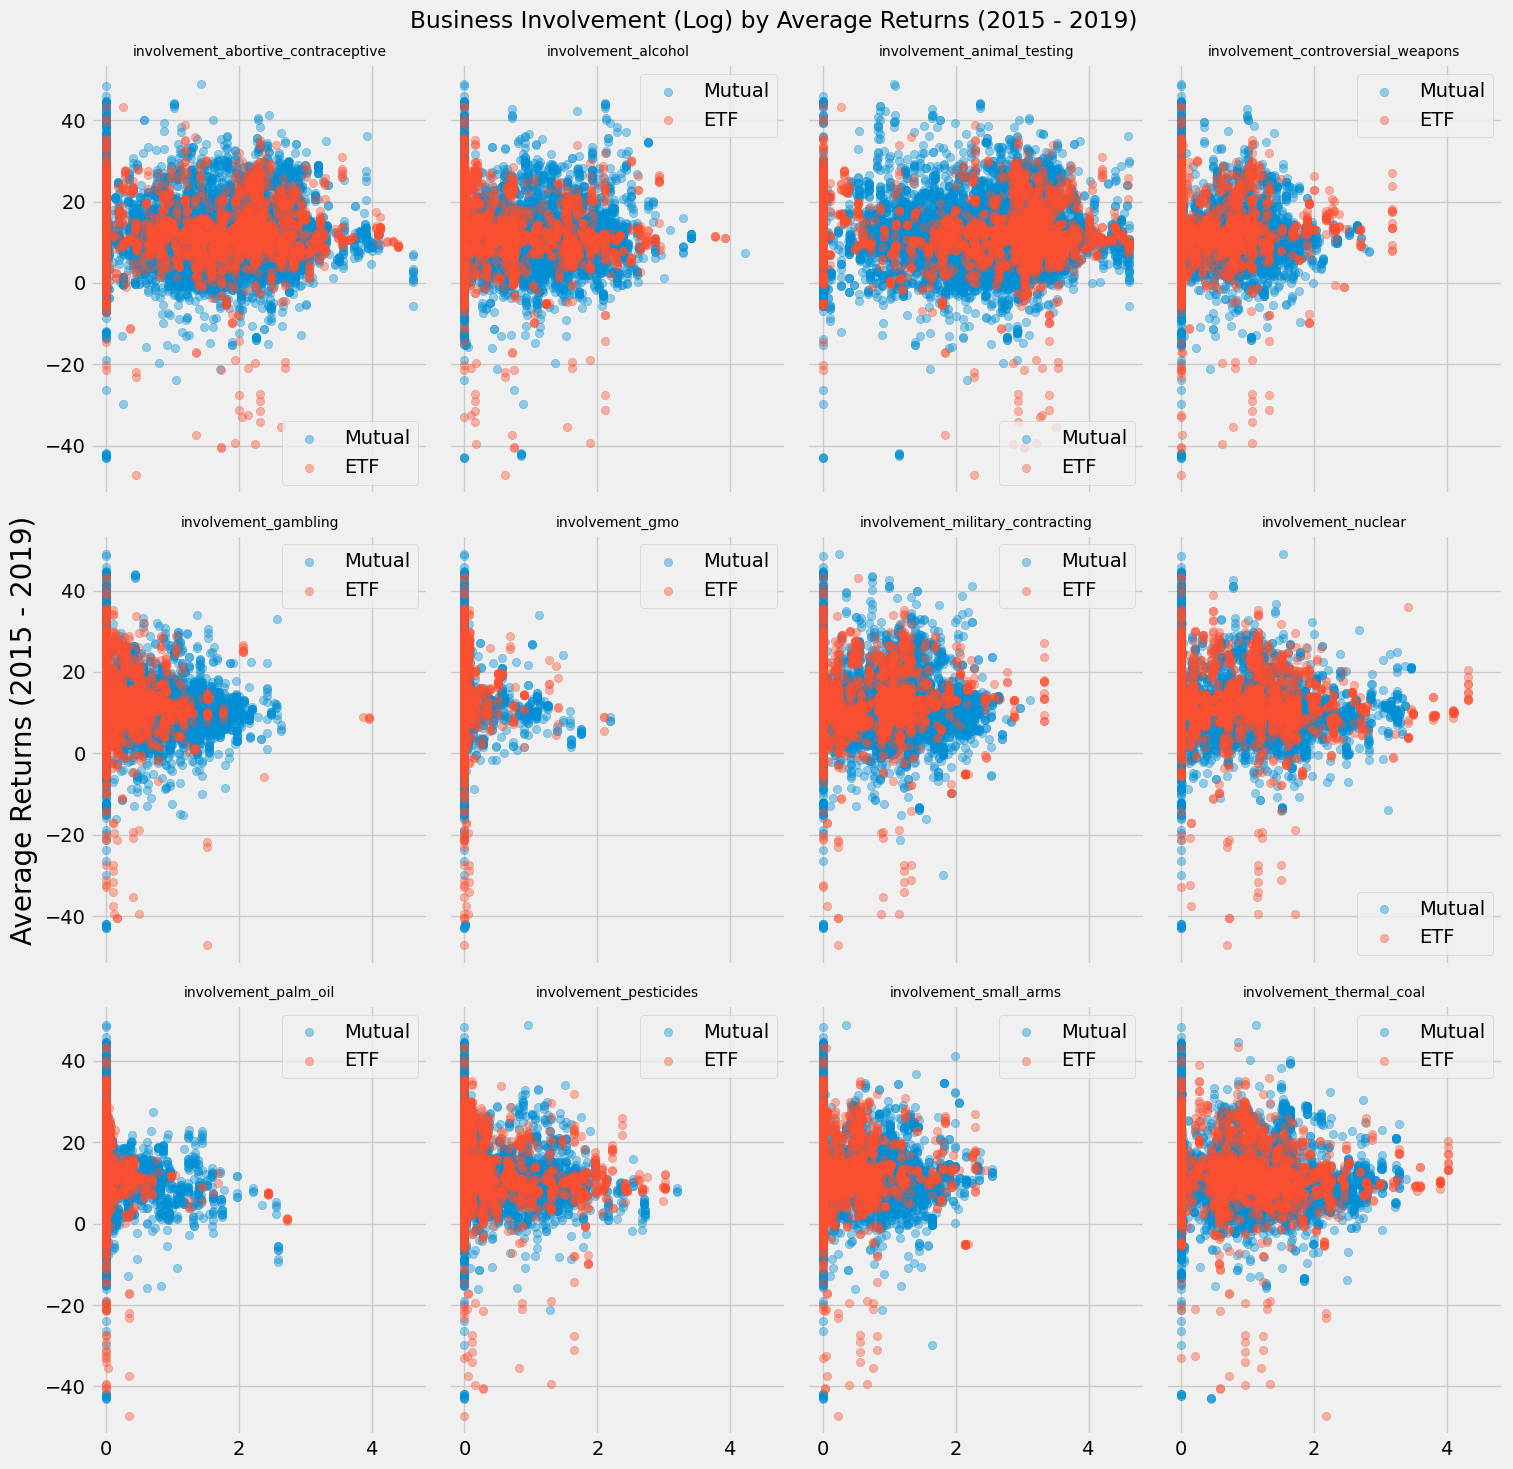

In [146]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.4, hspace=.4)
for invest, ax in zip(invest_cols, axes.ravel()):
    ax.scatter(np.log(mf_equity[invest] + 1), mf_equity.avg_fund_return_2015_2019, alpha=.4, label='Mutual')
    ax.scatter(np.log(etf_equity[invest] + 1), etf_equity.avg_fund_return_2015_2019, alpha=.4, label='ETF')
    ax.set_title(invest, size=10)
    ax.legend()

# Set common labels
fig.text(0, 0.5, 'Average Returns (2015 - 2019)', ha='center', va='center', rotation='vertical', size=20)

plt.suptitle('Business Involvement (Log) by Average Returns (2015 - 2019)')
plt.tight_layout()
plt.show()

**Countries**

In [ ]:
sns.boxplot(data=mf_equity, x='source', y=sector, linewidth=1, ax=ax)

In [ ]:
for i in mf_train.columns:
    if i == 'shareclass_size':
        print(mf_train[i].value_counts())

In [ ]:
for i in mf_equity.columns:
    print(i, mf_equity[i].dtype, mf_equity[i].isnull().sum())

### Correlations Analysis

- Pearson
- Spearman
- sns heatmap diverging palette
- plot_corr_ellipses

### Attribute Combinations

### Respond to Data Analytics Questions

**Potential Analysis Questions to Explore**
- What are the top-performing investment products in the market, based on risk-adjusted returns, over the past 1, 3, and 5 years?
- How do the risk levels of different investment products correlate with their performance?
- Are there any seasonal or cyclical trends in the performance of investment products that can be leveraged for marketing strategies?
- Which investment products have the highest customer satisfaction ratings?
- Are there any correlations between customer satisfaction and the performance of the investment products?
- How do the fees (management and expense fees) of different investment products impact their overall performance and customer satisfaction rate?
- Other relevant questions... [risk-adjusted returns, market share, and customer satisfaction]
- Top 10 Most and Least Performing Funds for 10, 3, 5 years
- Visualize Skewness and Kurtosis
- Visualize Anomaly Detection & Outliers

### Export Data for Tableau Dashboard

### Prepare the Data for ML Algorithm

-- Address missing values! Options are KNN or MICE

### Handling Categorical Data

### Feature Scaling

### Transformation Pipeline

### Training and Evaluation

### Cross-validation Metrics

### Testing and Evaluation

### Conclusion Report